In [1]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/zm/kkmsx86x44jd62c4wv0jdz1m0000gn/T/pip-req-build-o_53ez3g
  Running command git clone --filter=blob:none -q https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/zm/kkmsx86x44jd62c4wv0jdz1m0000gn/T/pip-req-build-o_53ez3g
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit 1d32470a9636755ce07e10a353bf9ce2dc4714fd
  Preparing metadata (setup.py) ... done
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If y

# Assignment - Bryan ATOK A KIKI

## Initiate the environment

In [4]:
# imports

import os, sys
import gym
import time

import text_flappy_bird_gym

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from tqdm import tqdm

matplotlib.style.use('fivethirtyeight')

In [5]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

## Agent n°1: Q-Learning

### Class definition

For the first agent, I will implement the Q-Learning algorithm with a $\epsilon$-greedy action selection to solve the FlappyBird problem

In [2]:
# First, I define the class for the agent
class QLearningAgentTer():
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor,   
        }
        
        """

        # Store the parameters provided in agent_init_info
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.eps_decay = agent_init_info["eps_decay"]
        self.step_size = agent_init_info["step_size"]
        self.step_size_decay = agent_init_info["step_size_decay"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        
        # Create a dictionary for action-value estimates
        self.q = {}


    def is_state_explored(self, state):
      if (state, 0) not in self.q:
            self.q[(state, 0)] = 0
        
      if (state, 1) not in self.q:
            self.q[(state, 1)] = 0



    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        self.is_state_explored(state)

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action

        return action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        self.is_state_explored(state)

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Perform an update
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[(self.prev_state, self.prev_action)])    


        # Decay for the step-size
        if self.step_size > 0.1:
                self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 
        
        self.prev_state = state
        self.prev_action = action
        return action
    

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.is_state_explored(state)

        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])     
        

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)



### Baseline

100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2857.56it/s]


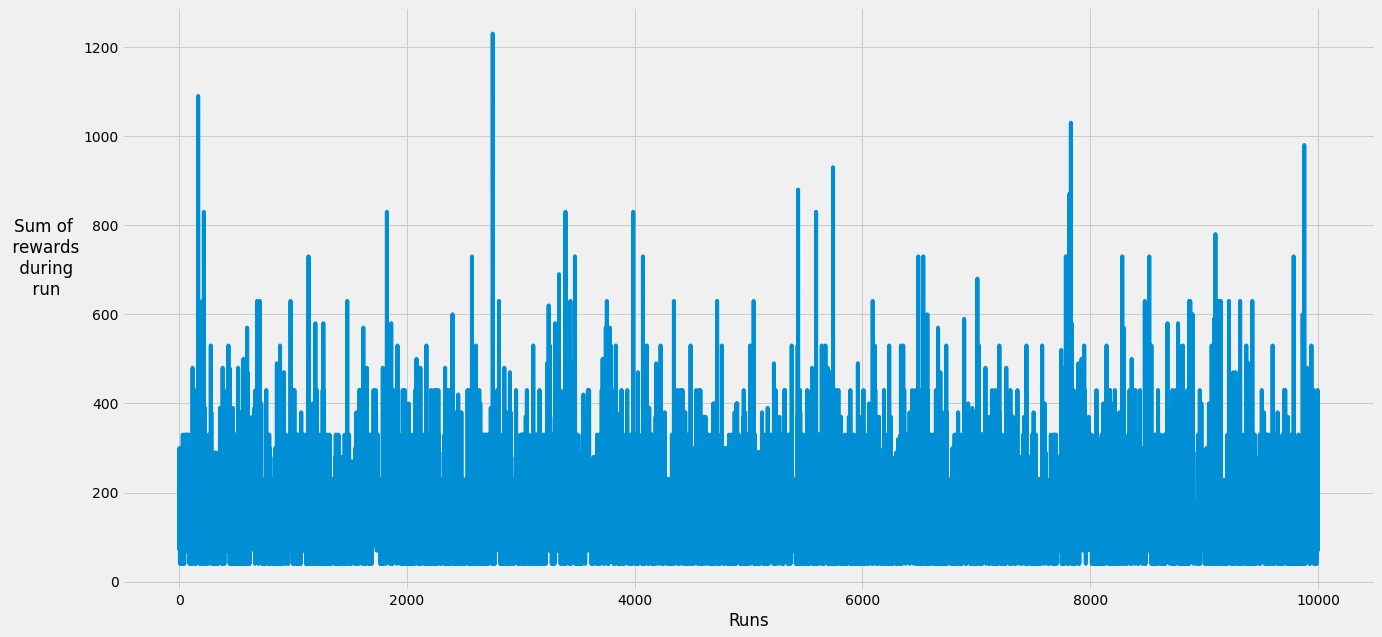

In [6]:
agent = QLearningAgentTer()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

all_reward_sums = [] # Contains sum of rewards during episode
all_state_visits = [] # Contains state visit counts during the last 10 episodes
all_scores = [] # Contains the scores obtained for each run
agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay":.999, "step_size": 0.7, "step_size_decay": 0.9999, "discount": 1.0}
agent_info["seed"] = 0
agent.agent_init(agent_info)

env_info = {}
num_runs = 10000 # The number of runs
num_episodes = 500 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(num_runs)):

    # Set the seed value to the current run index
    agent_info["seed"] = run

    # Initialize the environment
    state = env.reset()

    # Set done to False
    done = False

    reward_sums = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(num_episodes):
        if episode == 0:
      
            # Keep track of the visited states
            state = env.reset()
            action = agent.agent_start(state)

            state_visits[state] = 1
            state, reward, done, info = env.step(action)
            reward_sums.append(reward)

        else:
            while not done:
              action = agent.agent_step(reward, state)
              agent.epsilon = agent.epsilon * agent.eps_decay

              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1

              state, reward, done, info = env.step(action)
              reward_sums.append(reward)

              # If terminal state
              if done:
                action = agent.agent_end(reward)
                break

    all_reward_sums.append(np.sum(reward_sums))
    all_state_visits.append(state_visits)
    all_scores.append(info["score"])

# Plot the results
x = np.arange(num_runs)
plt.figure(figsize=(20, 10))
plt.plot(x, all_reward_sums)
plt.xlabel("Runs")
plt.ylabel("Sum of\n rewards\n during\n run",rotation=0, labelpad=40)
plt.show()

### Hyperparameter tuning

#### Step-Size

In [ ]:
agent = QLearningAgentTer()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["alpha = 0.4", "alpha = 0.5","alpha = 0.6", "alpha = 0.7","alpha = 0.8", "alpha = 0.9"]
step_sizes = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

every_scores = []
every_rewards = []

for step_size in tqdm(step_sizes):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay":1.0, "step_size": step_size, "step_size_decay": 1.0, "discount": 1.0}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)

100%|██████████| 6/6 [06:50<00:00, 68.49s/it]


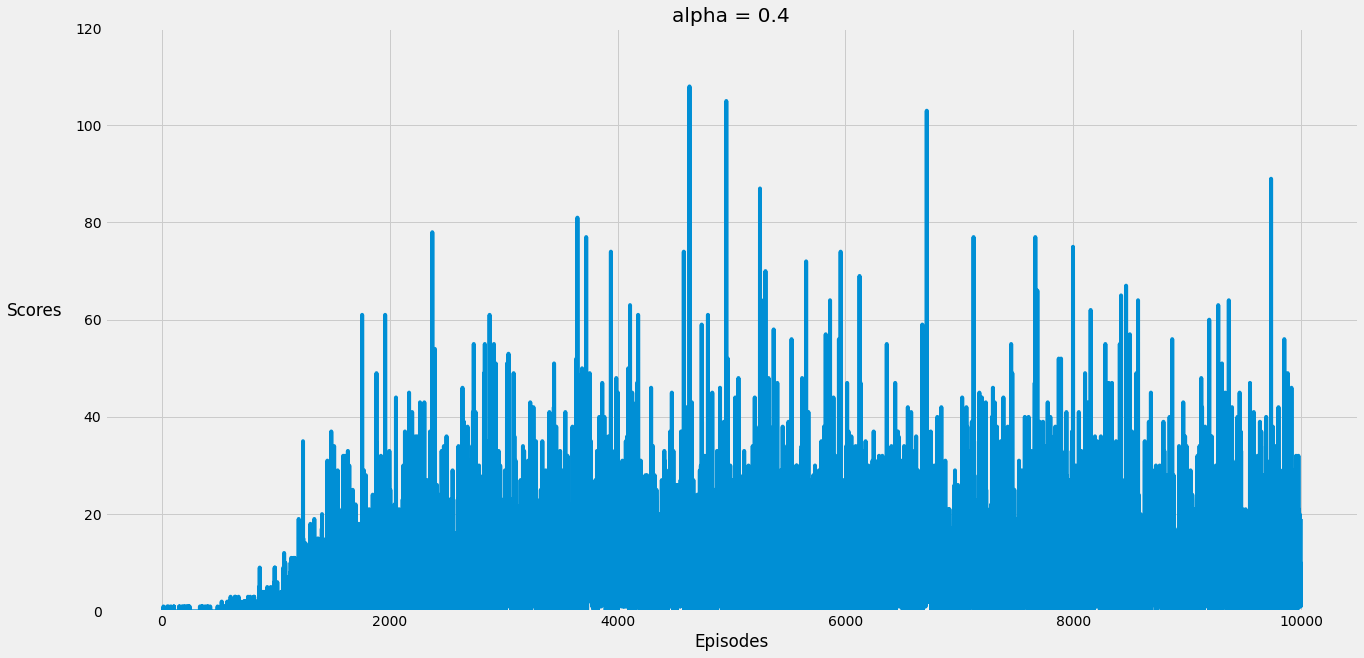

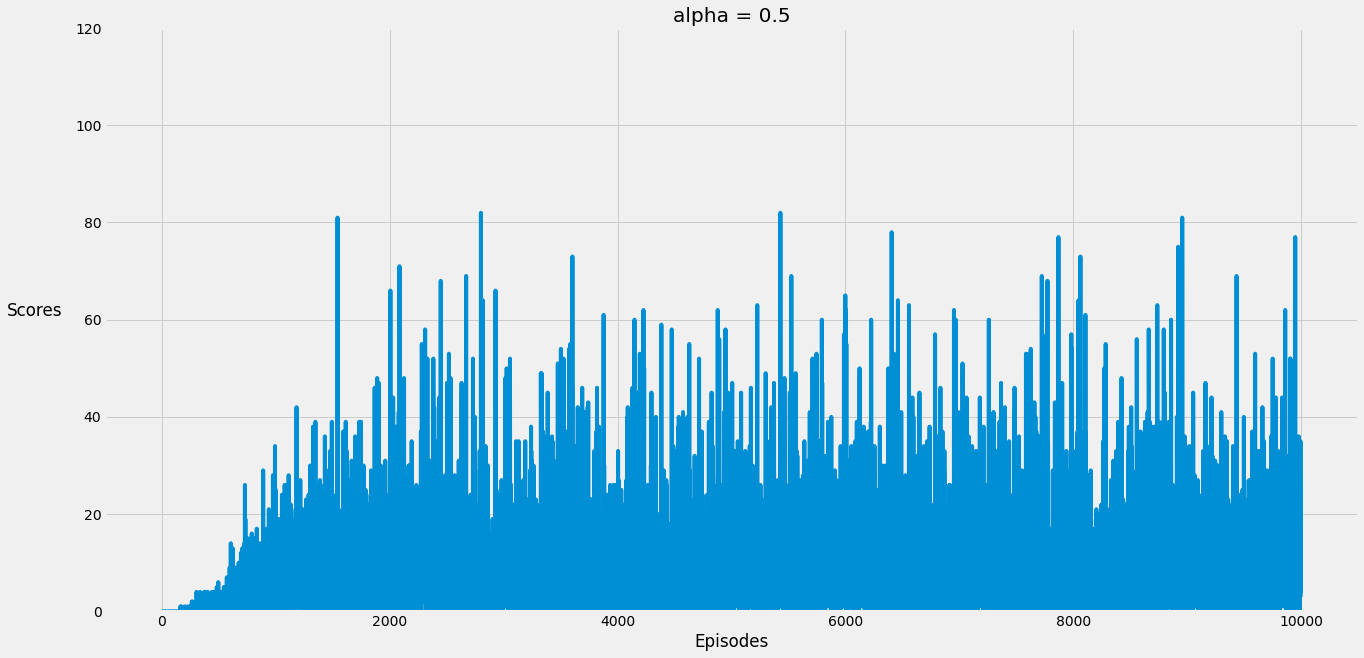

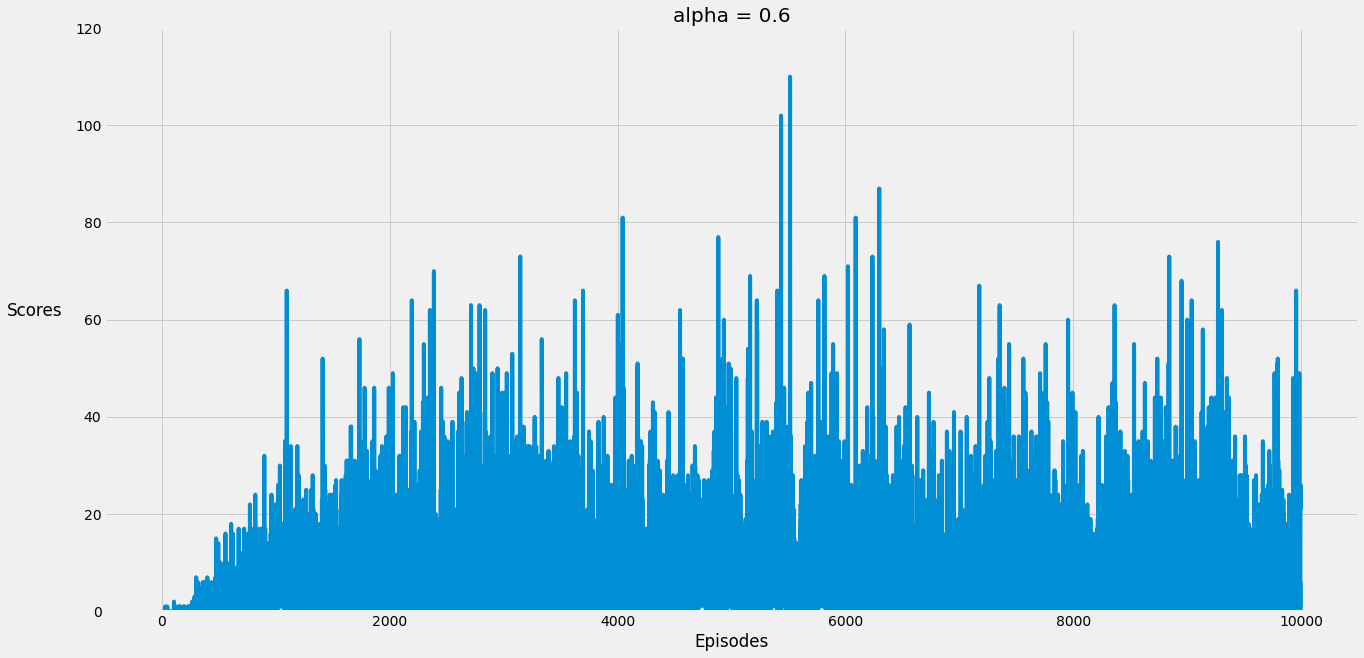

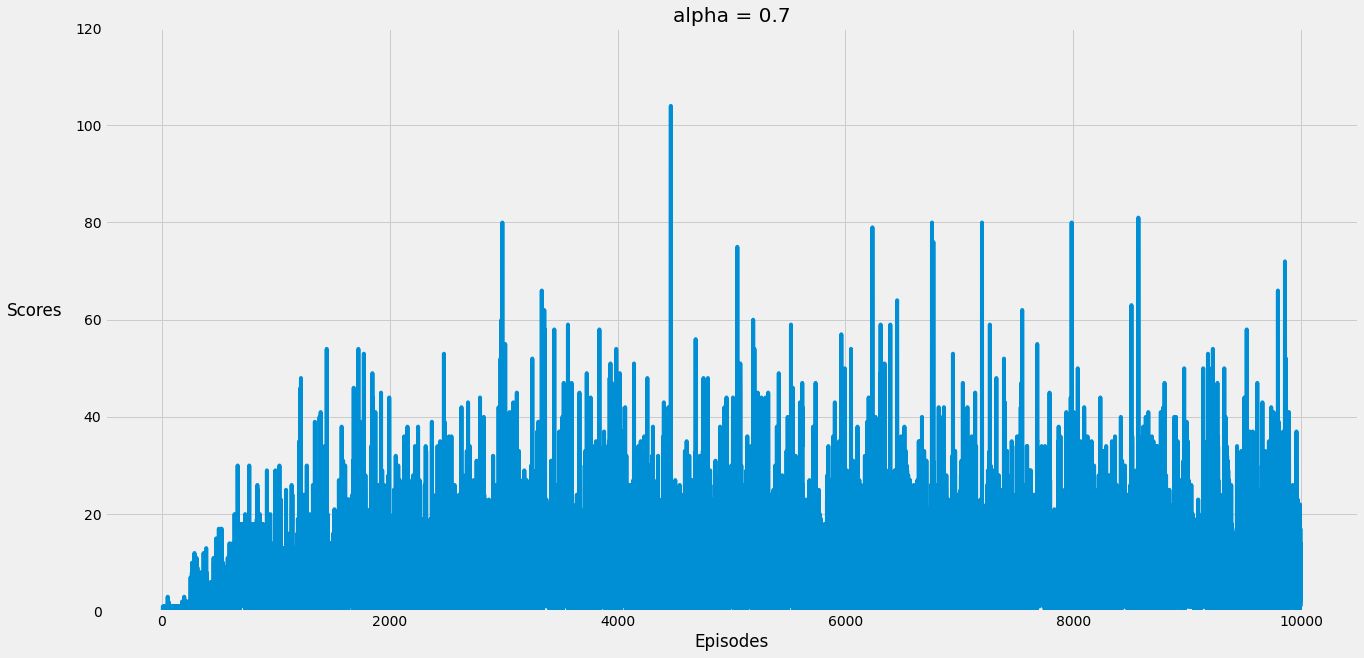

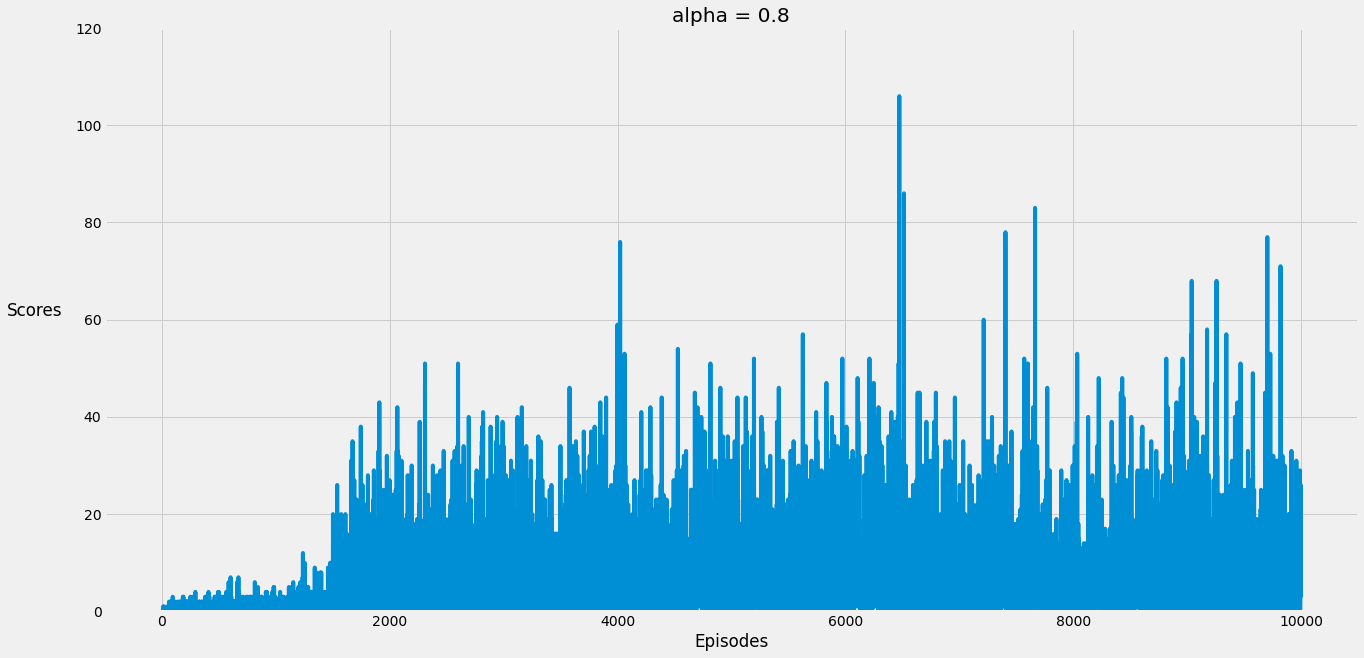

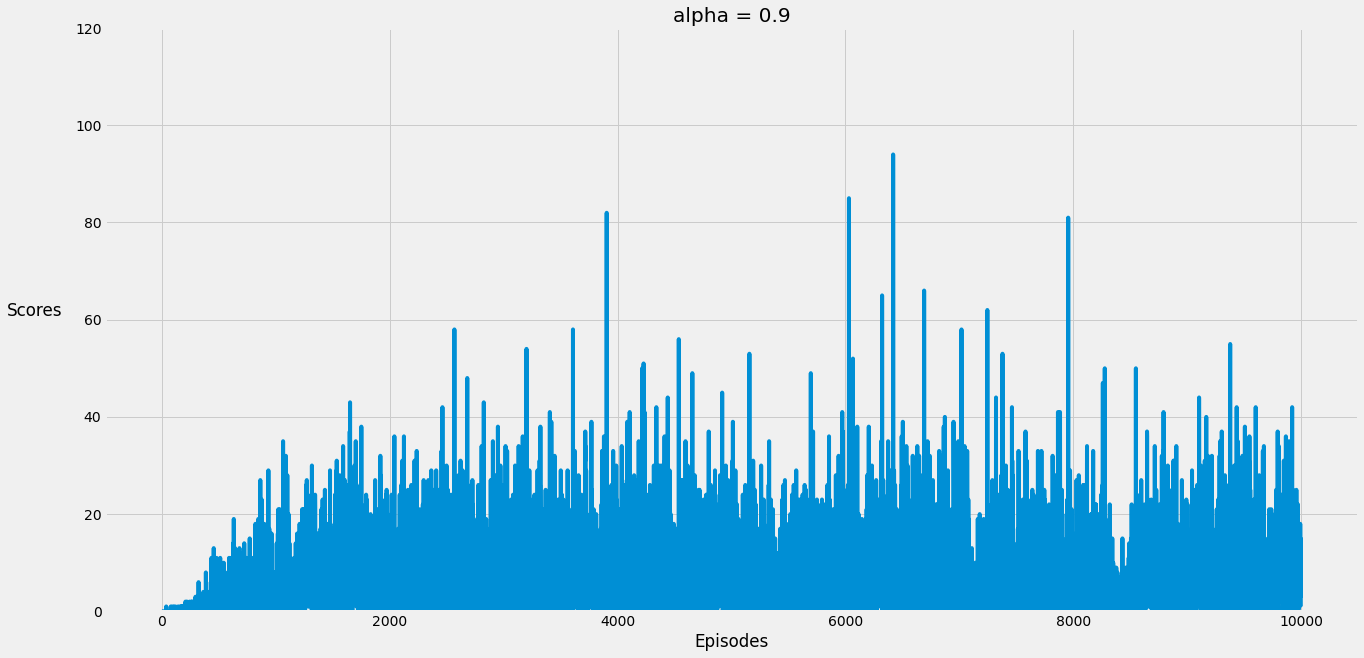

In [ ]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 120)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


alpha = 0.4
Mean:  8.2522
Median:  5.0
Max:  89
--------------------
alpha = 0.5
Mean:  8.6975
Median:  6.0
Max:  90
--------------------
alpha = 0.6
Mean:  8.1547
Median:  5.0
Max:  118
--------------------
alpha = 0.7
Mean:  8.3808
Median:  5.0
Max:  120
--------------------
alpha = 0.8
Mean:  7.9801
Median:  5.0
Max:  83
--------------------
alpha = 0.9
Mean:  7.0183
Median:  4.0
Max:  73
--------------------


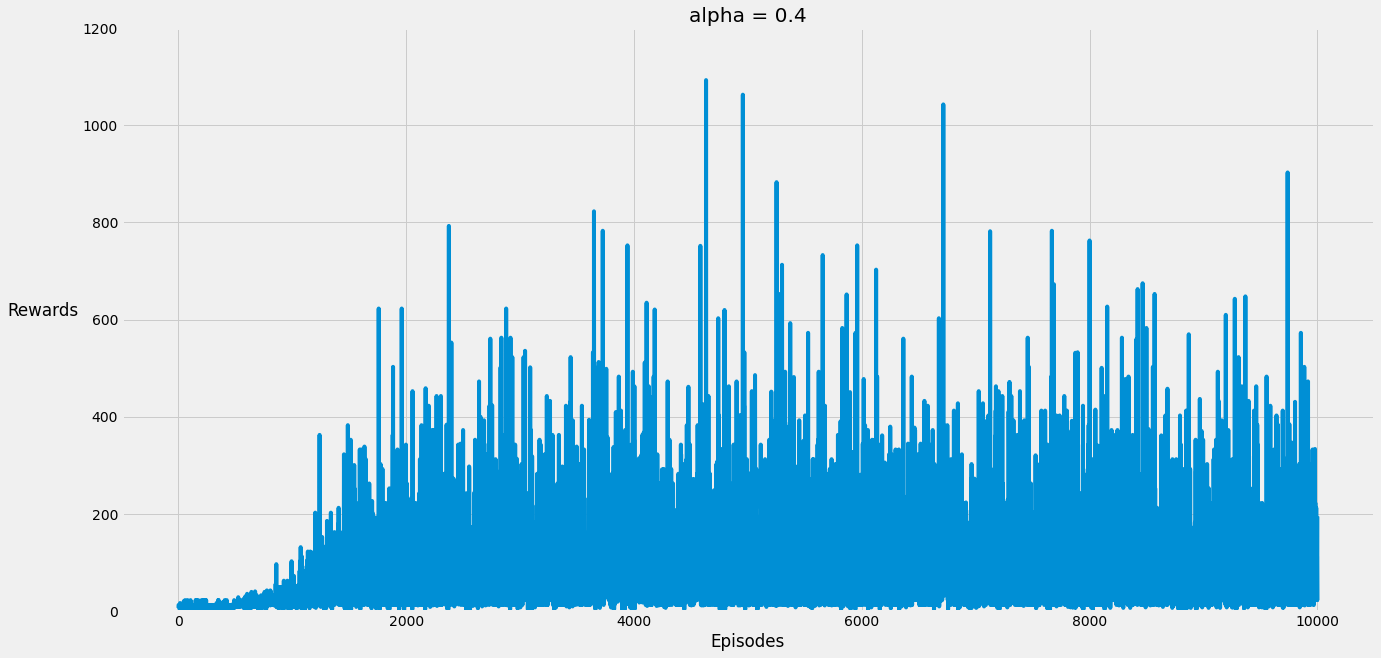

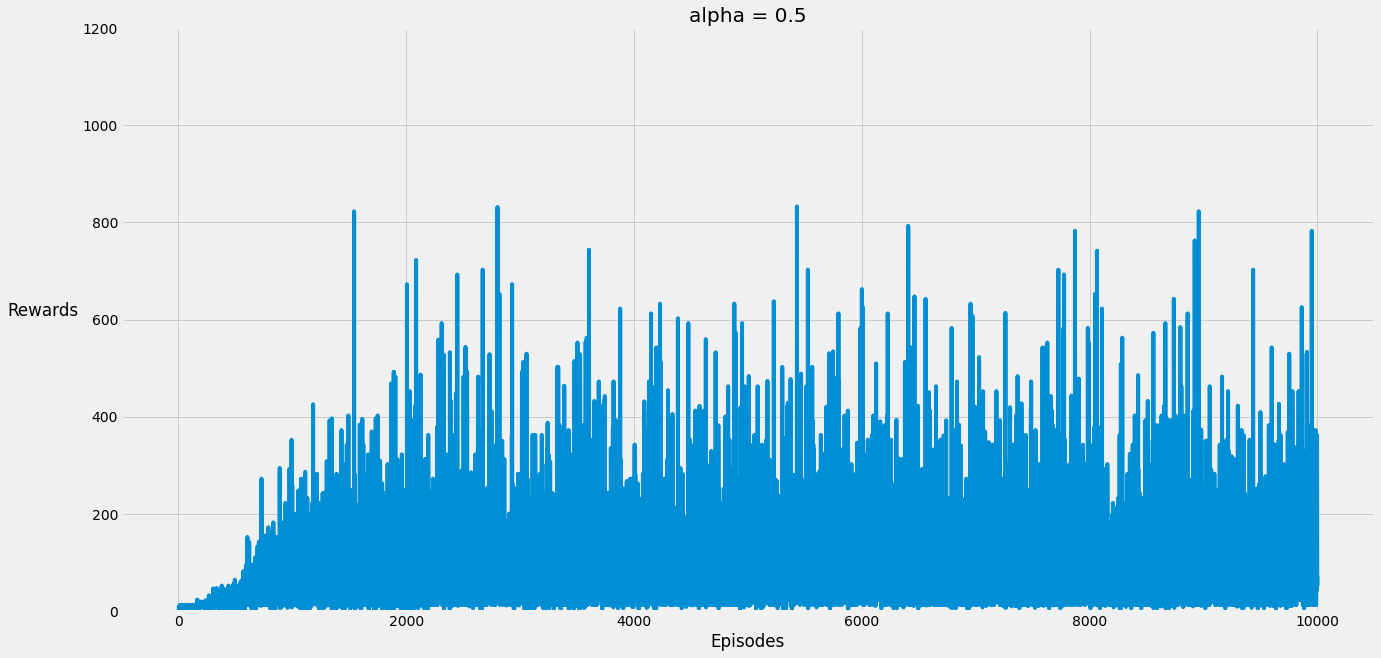

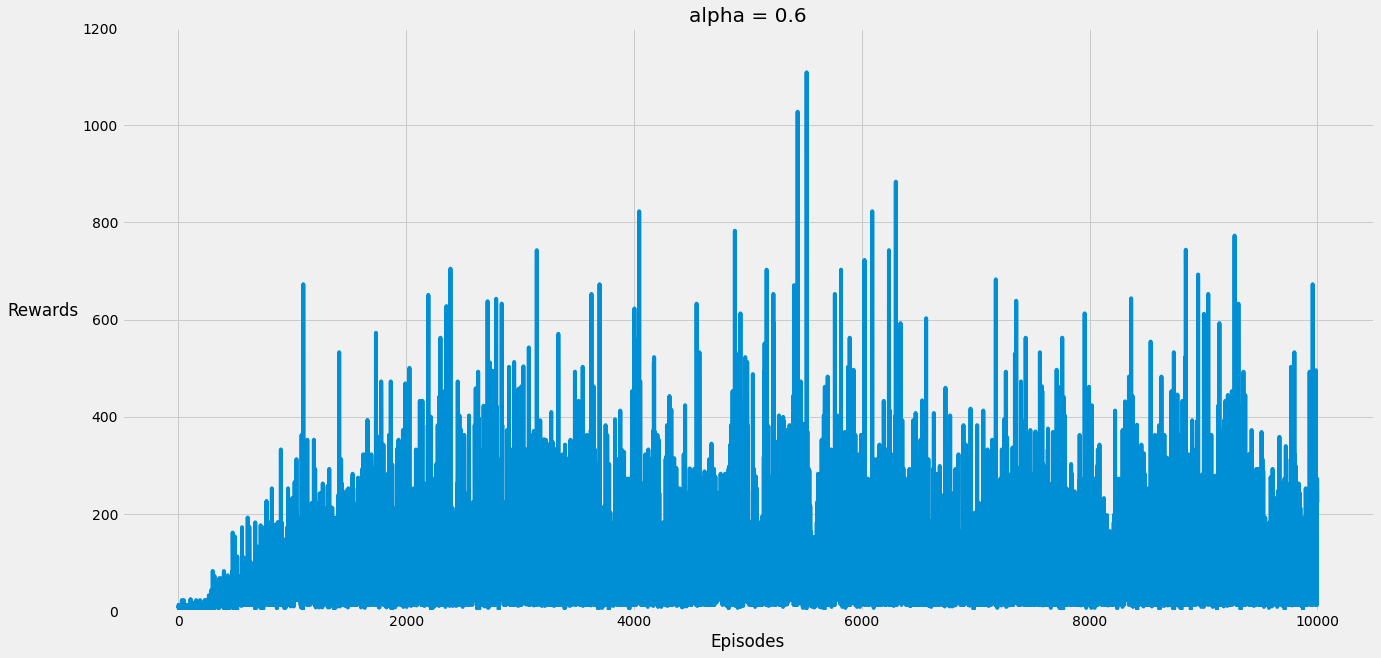

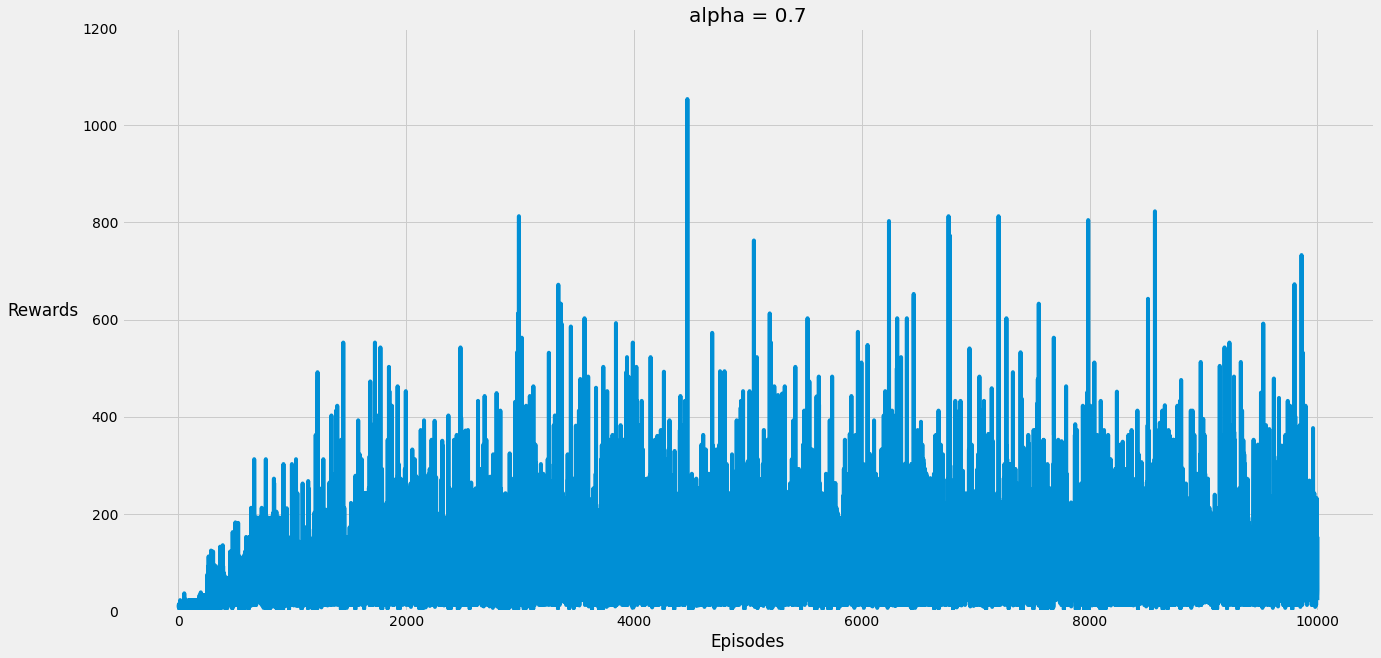

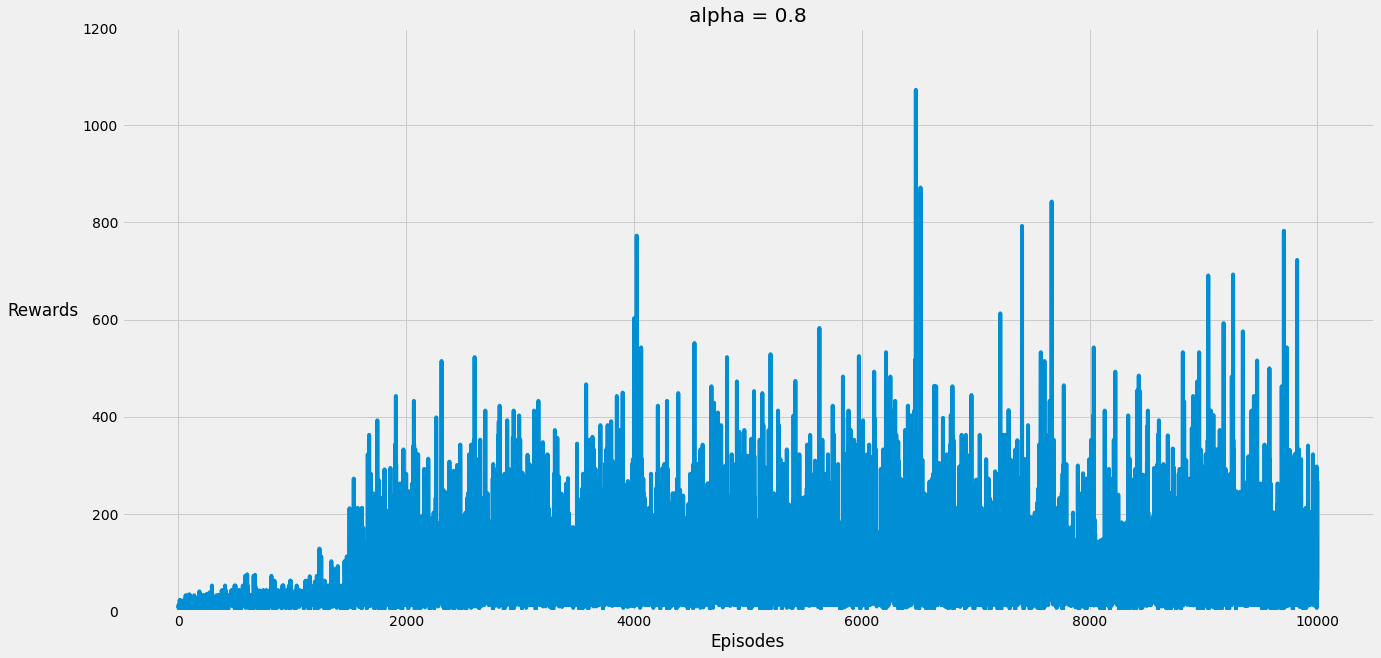

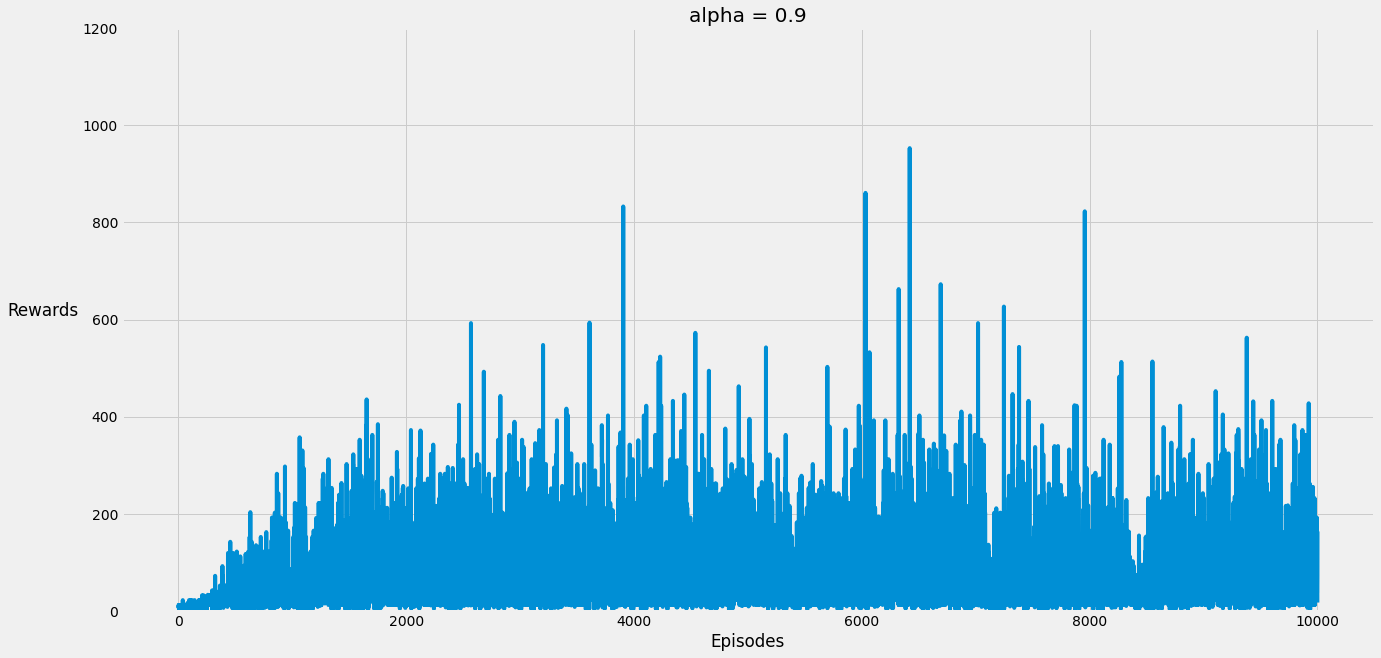

In [ ]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.ylim(0, 1200)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


alpha = 0.4
Mean:  96.9659
Median:  63.0
Max:  1093
--------------------
alpha = 0.5
Mean:  98.3076
Median:  63.0
Max:  833
--------------------
alpha = 0.6
Mean:  96.2002
Median:  63.0
Max:  1109
--------------------
alpha = 0.7
Mean:  97.2499
Median:  64.0
Max:  1054
--------------------
alpha = 0.8
Mean:  81.8541
Median:  53.0
Max:  1073
--------------------
alpha = 0.9
Mean:  78.0283
Median:  53.0
Max:  953
--------------------


Please see the results of the hyperparameter tuning of the step-size α after 10,000 runs of 500 episodes:


| Step-size α| Mean | Median | Max |
|------|------|------|------|
|   0.4 | 96.97 | 63 | 1,093 |
|   0.5 | 98.31 | 63 | 833 |
|   0.6 | 96.20 | 63 | 1,109 |
|   0.7 | 97.25 | 64 | 1,054 |
|   0.8 | 81.85 | 53 | 1,073 |
|   0.9 | 78.03 | 53 | 953 |

Based on the median and average scores, the step-size to use to optimise the agent is α=0.5.


#### Epsilon

In [ ]:
agent = QLearningAgentTer()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["epsilon = 0.05", "epsilon = 0.1","epsilon = 0.15", "epsilon = 0.2","epsilon = 0.25", "epsilon = 0.3"]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

every_scores = []
every_rewards = []


for epsilon in tqdm(epsilons):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": epsilon, "eps_decay":1.0, "step_size": 0.5, "step_size_decay": 1.0, "discount": 1.0}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)



100%|██████████| 6/6 [05:51<00:00, 58.62s/it]


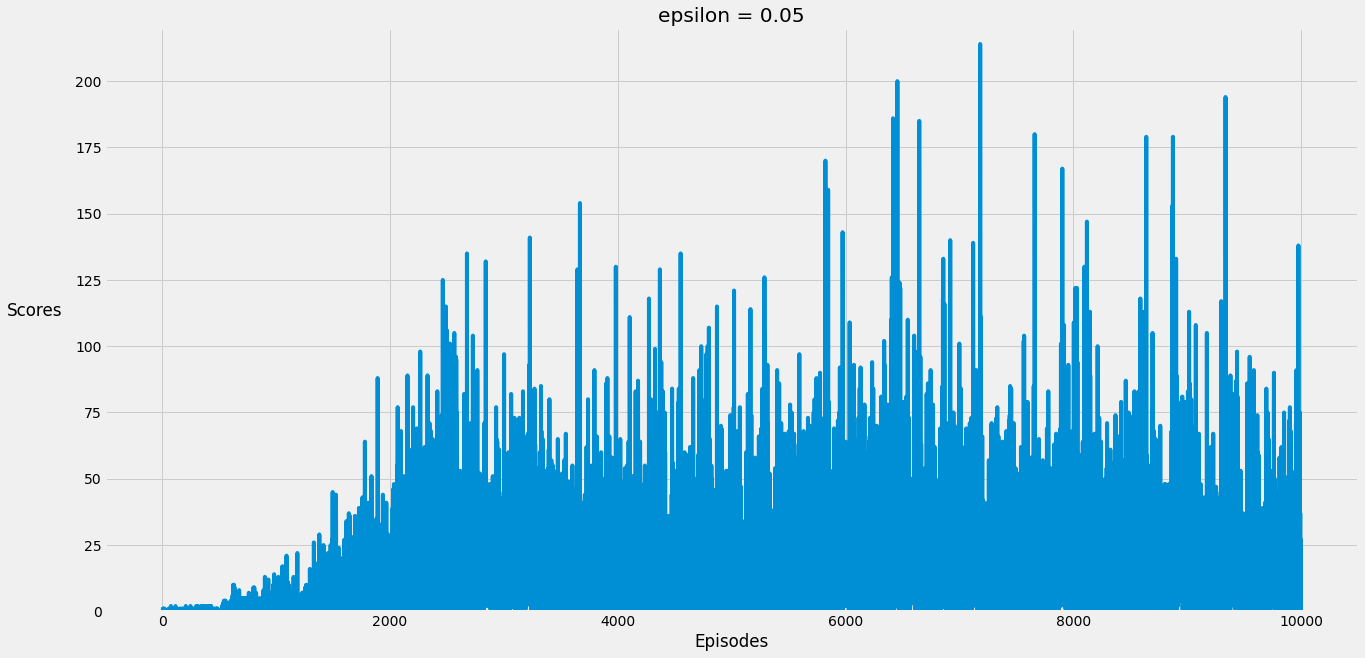

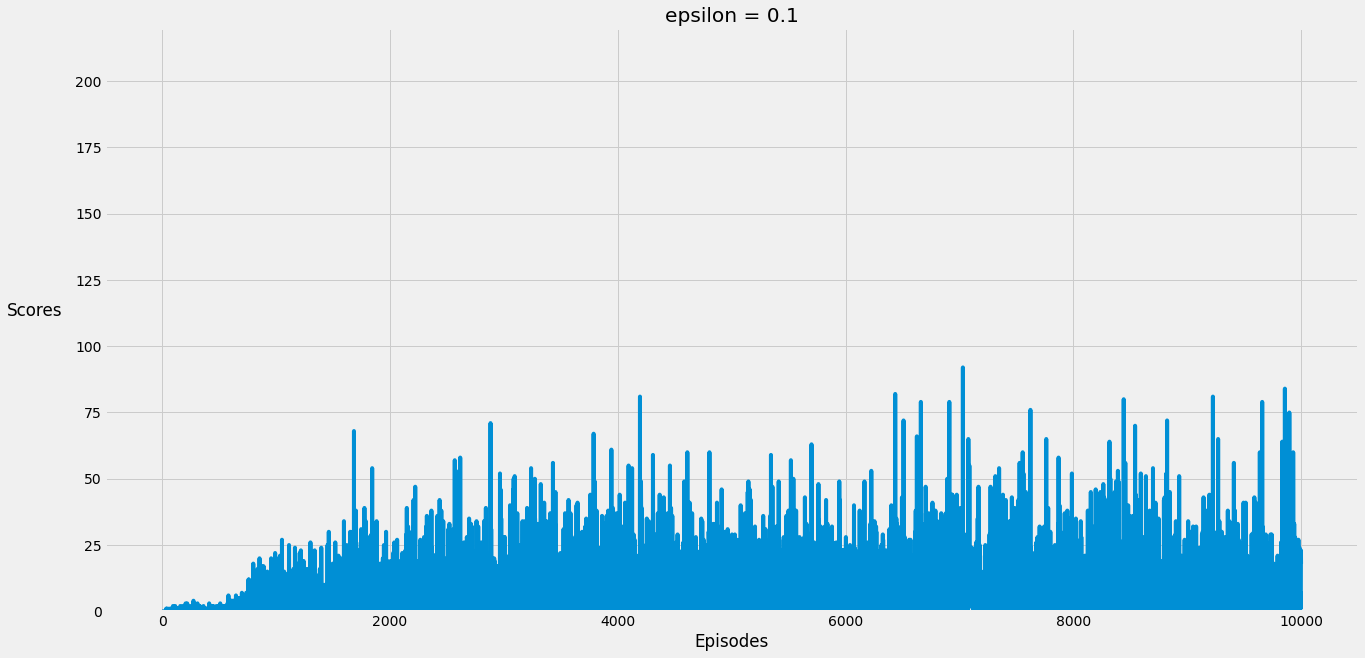

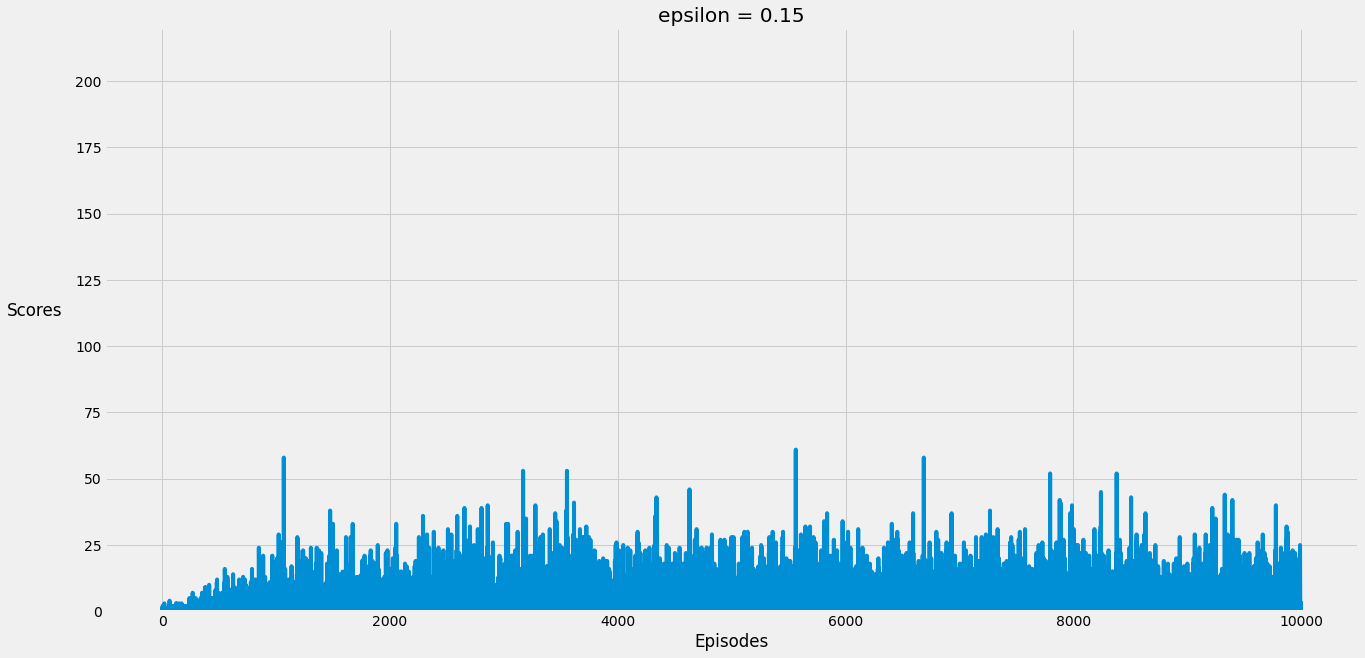

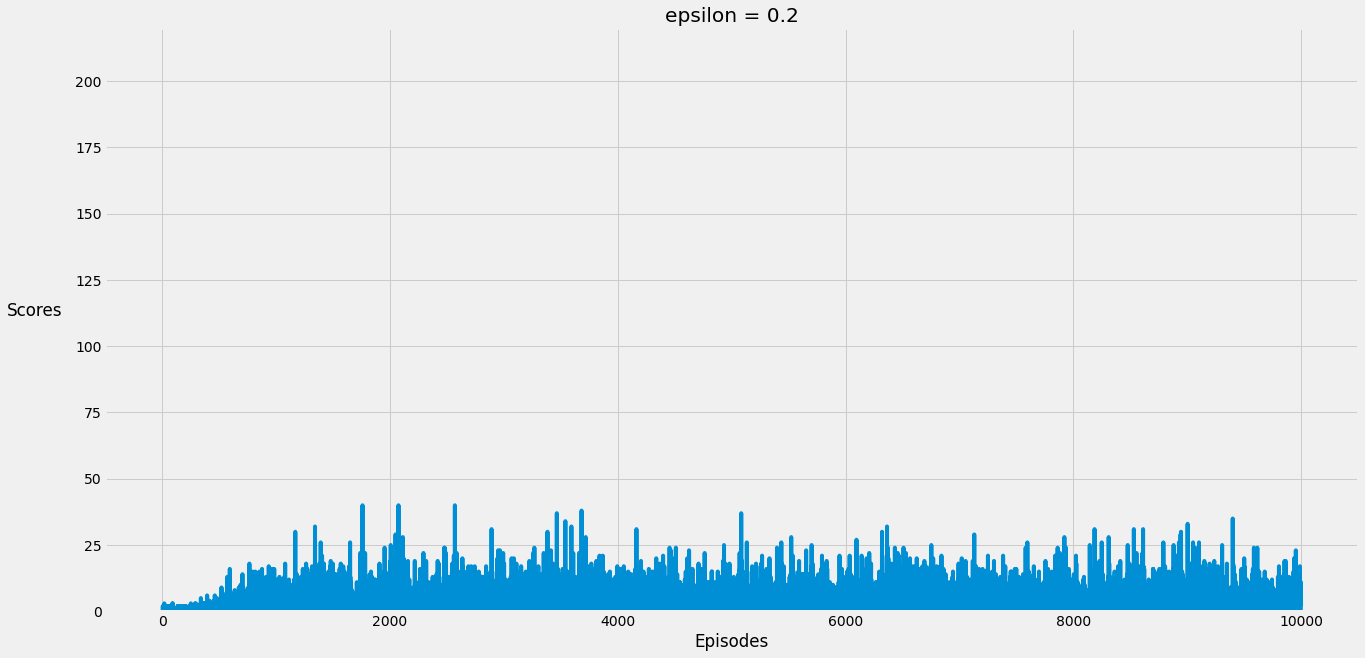

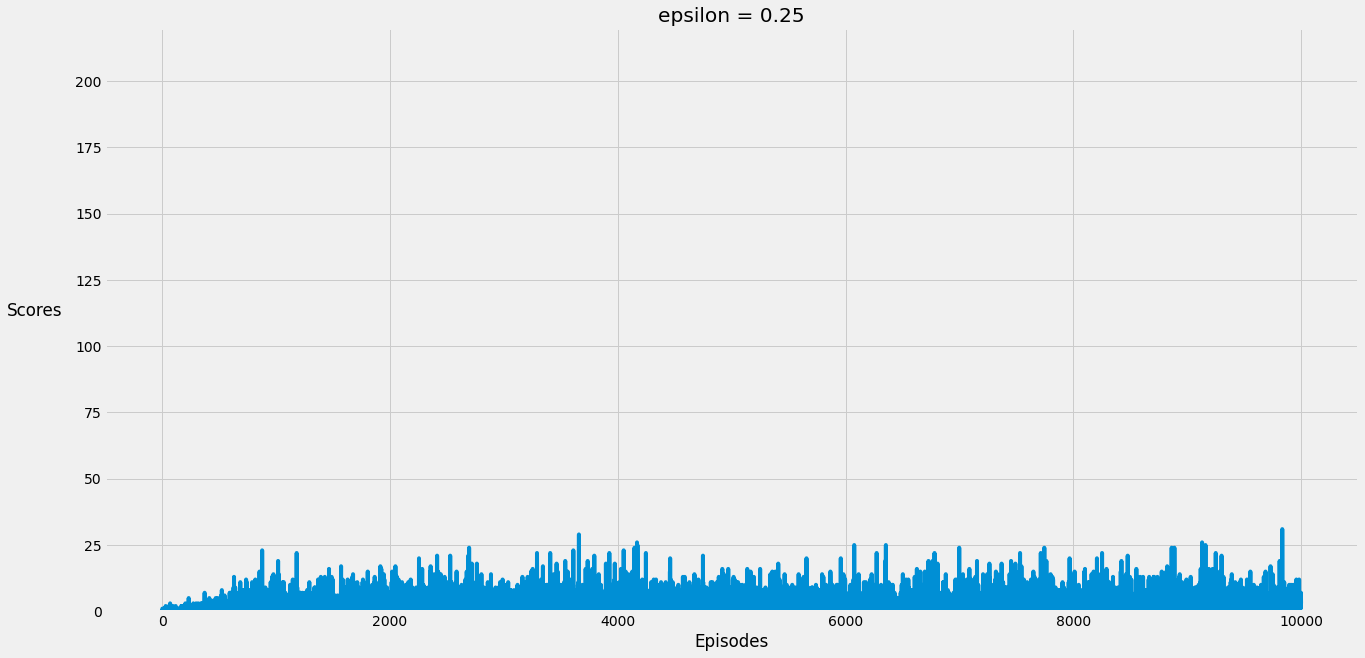

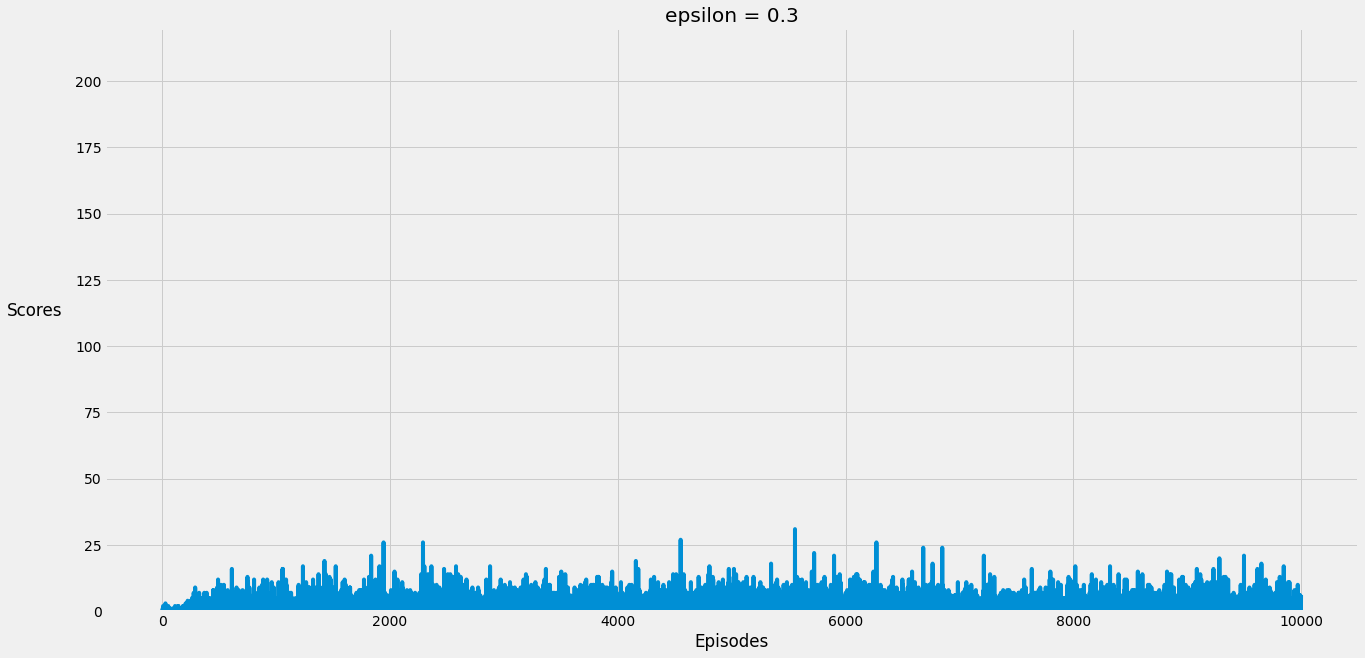

In [ ]:
matplotlib.style.use('fivethirtyeight')
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 220)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


epsilon = 0.05
Mean:  16.5923
Median:  10.0
Max:  214
--------------------
epsilon = 0.1
Mean:  8.4237
Median:  5.0
Max:  92
--------------------
epsilon = 0.15
Mean:  5.5933
Median:  4.0
Max:  61
--------------------
epsilon = 0.2
Mean:  4.0363
Median:  3.0
Max:  40
--------------------
epsilon = 0.25
Mean:  2.9219
Median:  2.0
Max:  31
--------------------
epsilon = 0.3
Mean:  2.3394
Median:  1.0
Max:  31
--------------------


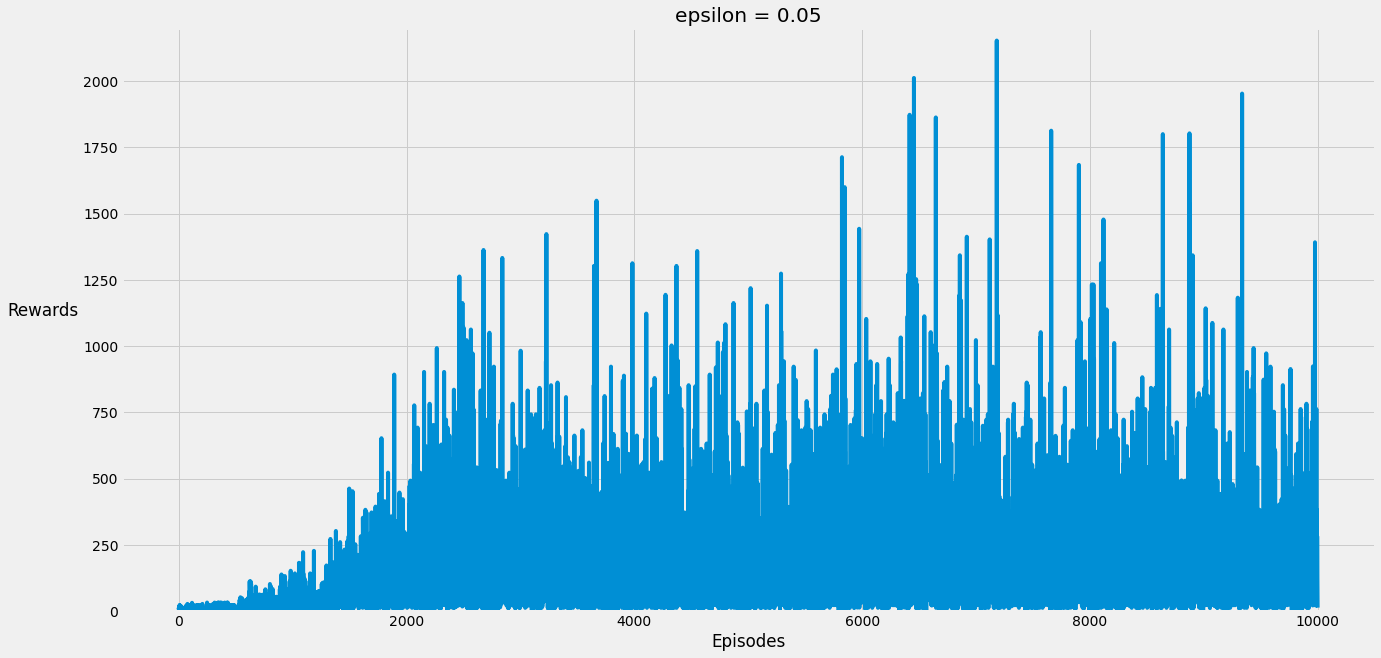

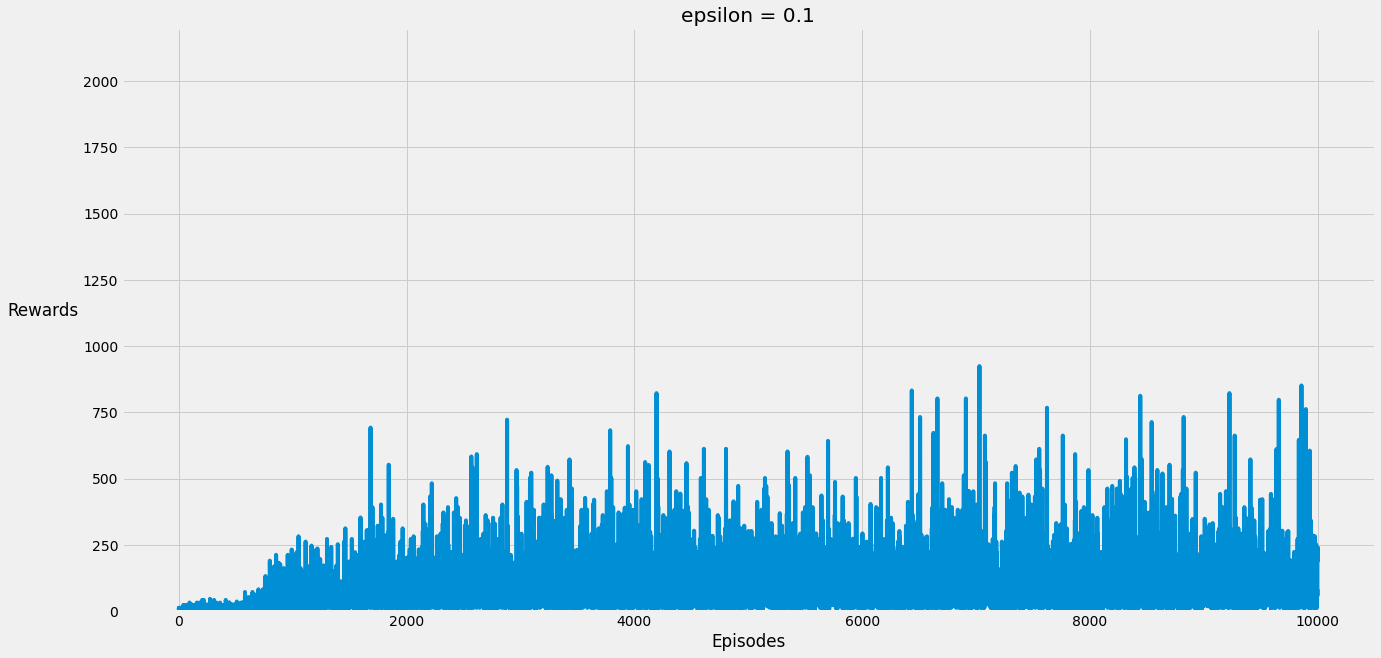

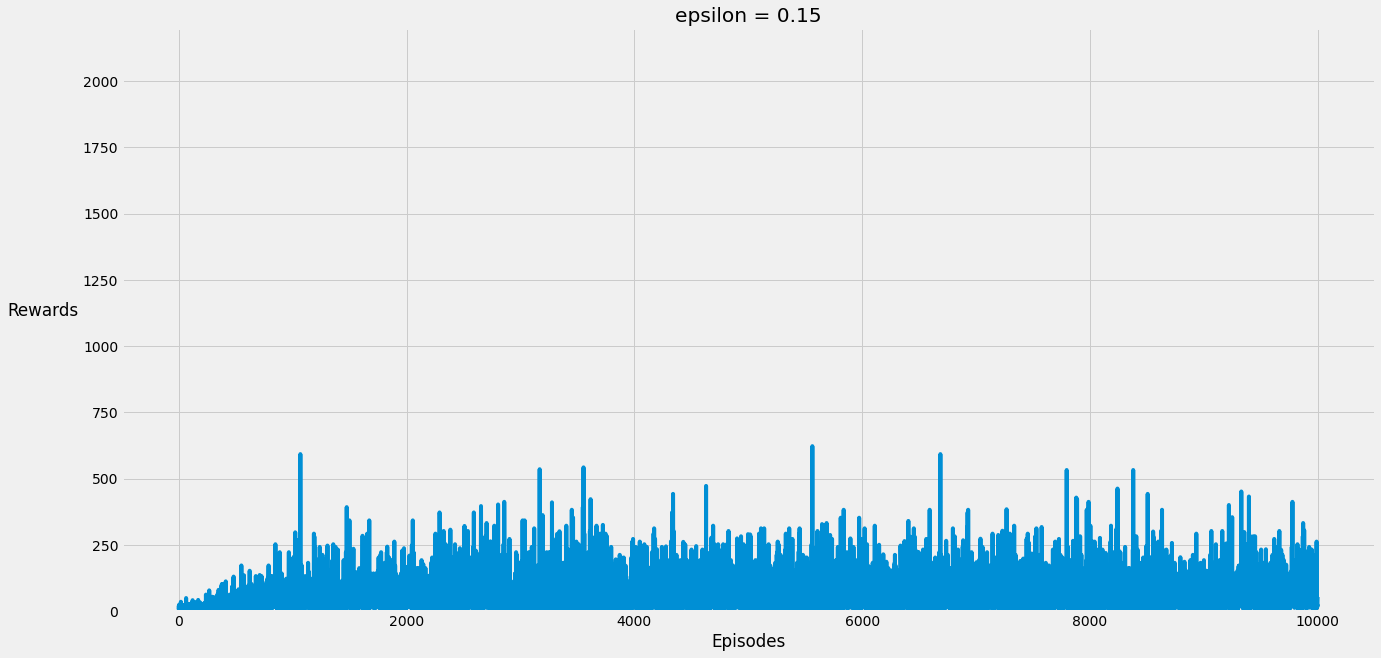

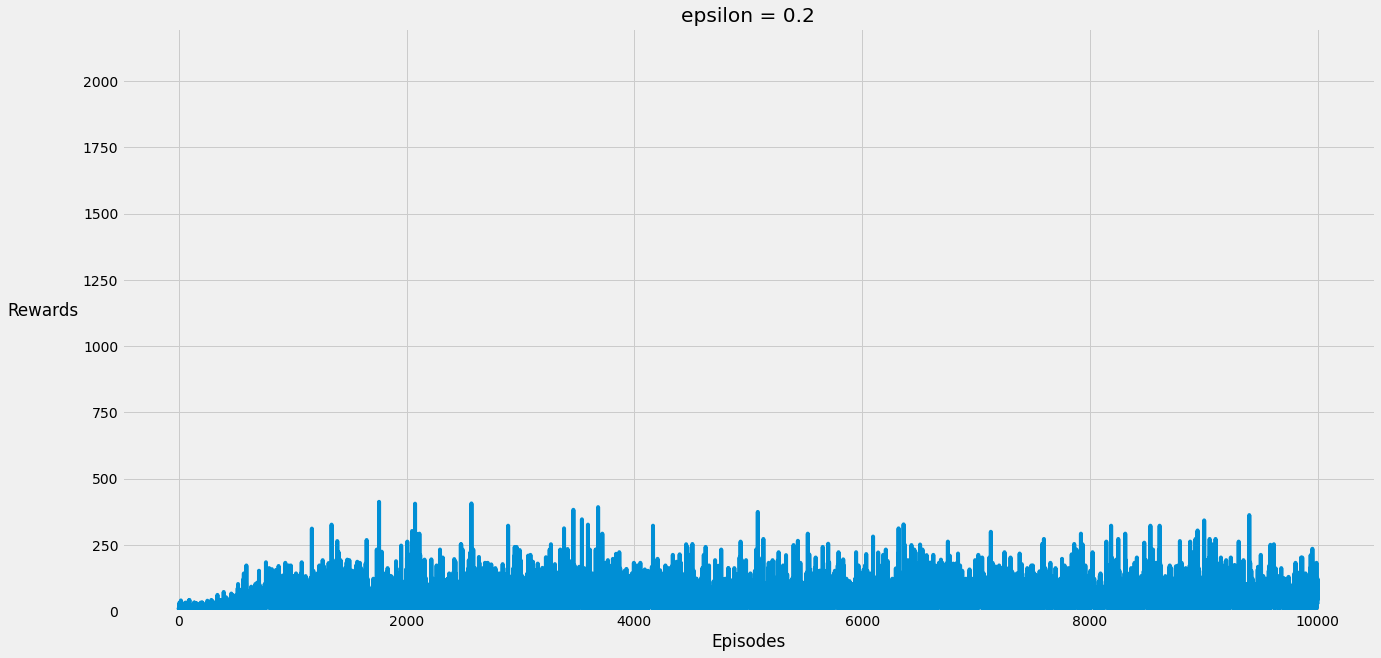

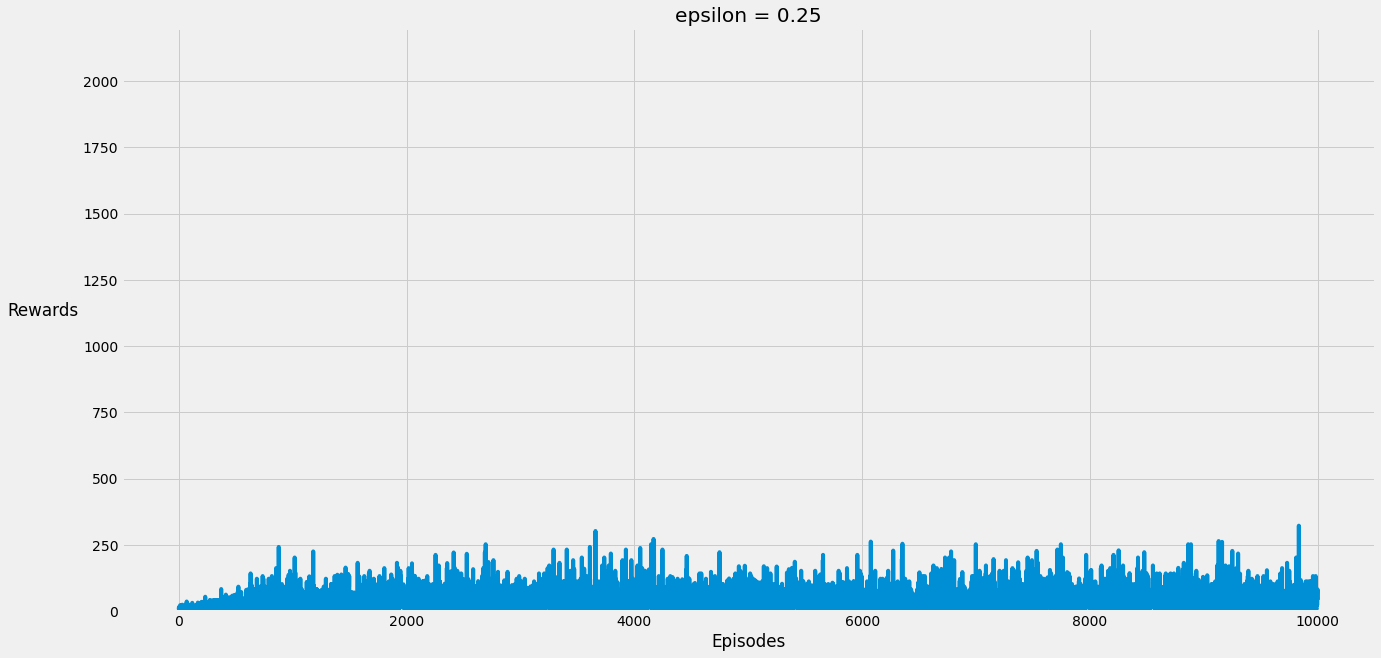

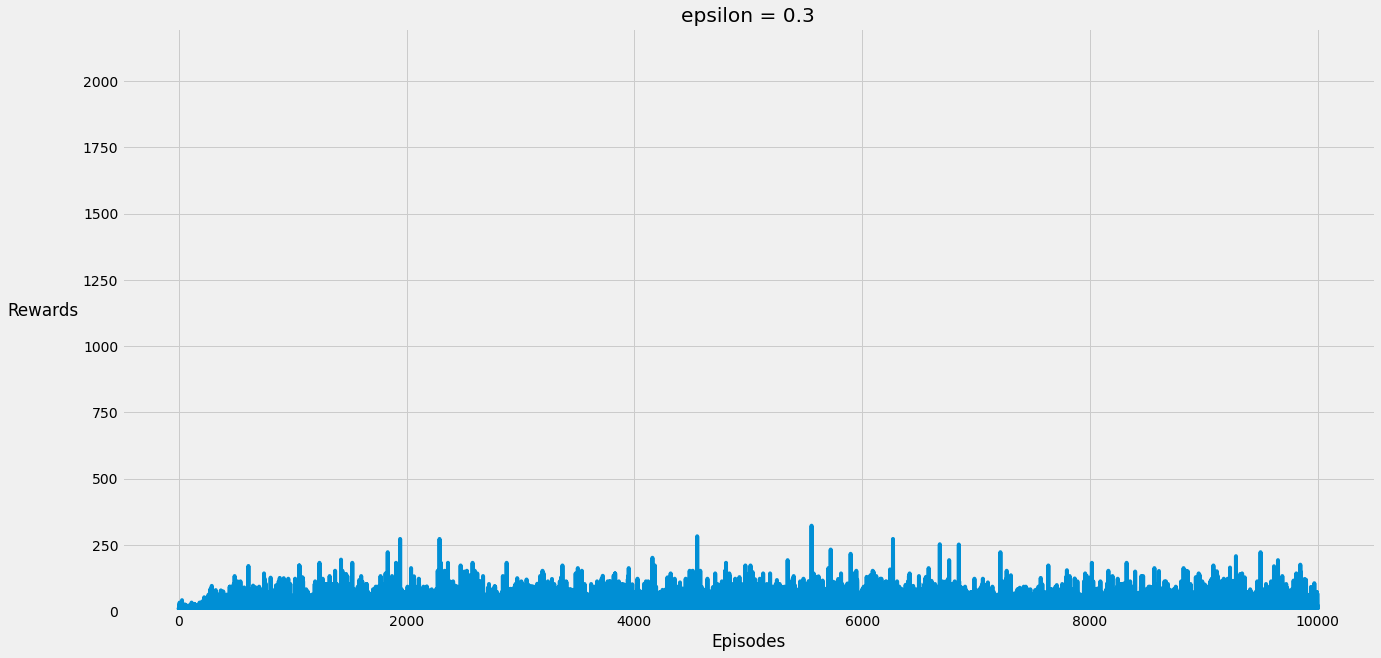

In [ ]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.ylim(0, 2200)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


epsilon = 0.05
Mean:  177.7987
Median:  113.0
Max:  2153
--------------------
epsilon = 0.1
Mean:  96.119
Median:  63.0
Max:  925
--------------------
epsilon = 0.15
Mean:  67.5343
Median:  45.0
Max:  623
--------------------
epsilon = 0.2
Mean:  51.9471
Median:  35.0
Max:  413
--------------------
epsilon = 0.25
Mean:  40.7606
Median:  33.0
Max:  323
--------------------
epsilon = 0.3
Mean:  34.8452
Median:  23.0
Max:  323
--------------------


Please see the results of the hyperparameter tuning of epsilon ϵ after 10,000 runs of 500 episodes:


| Epsilon ϵ| Mean | Median | Max |
|------|------|------|------|
|   0.05 | 177.80 | 113 | 2,153 |
|   0.1 | 96.12 | 63 | 925 |
|   0.15 | 67.53 | 45 | 623 |
|   0.2 | 51.95 | 35 | 413 |
|   0.25 | 40.76 | 33 | 323 |
|   0.3 | 34.85 | 23 | 323 |

Based on the median and average scores, the epsilon value to use to optimise the agent is ϵ=0.05. Therefore, the agent will almost behave in the greedy way.


#### Discount

In [ ]:
agent = QLearningAgentTer()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]
discounts = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]

every_scores = []
every_rewards = []

for discount in tqdm(discounts):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay":1.0, "step_size": 0.5, "step_size_decay": 1.0, "discount": discount}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 20000 # The number of runs
    num_episodes = 1000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)


                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)
                    break

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)



100%|██████████| 7/7 [32:47<00:00, 281.08s/it]


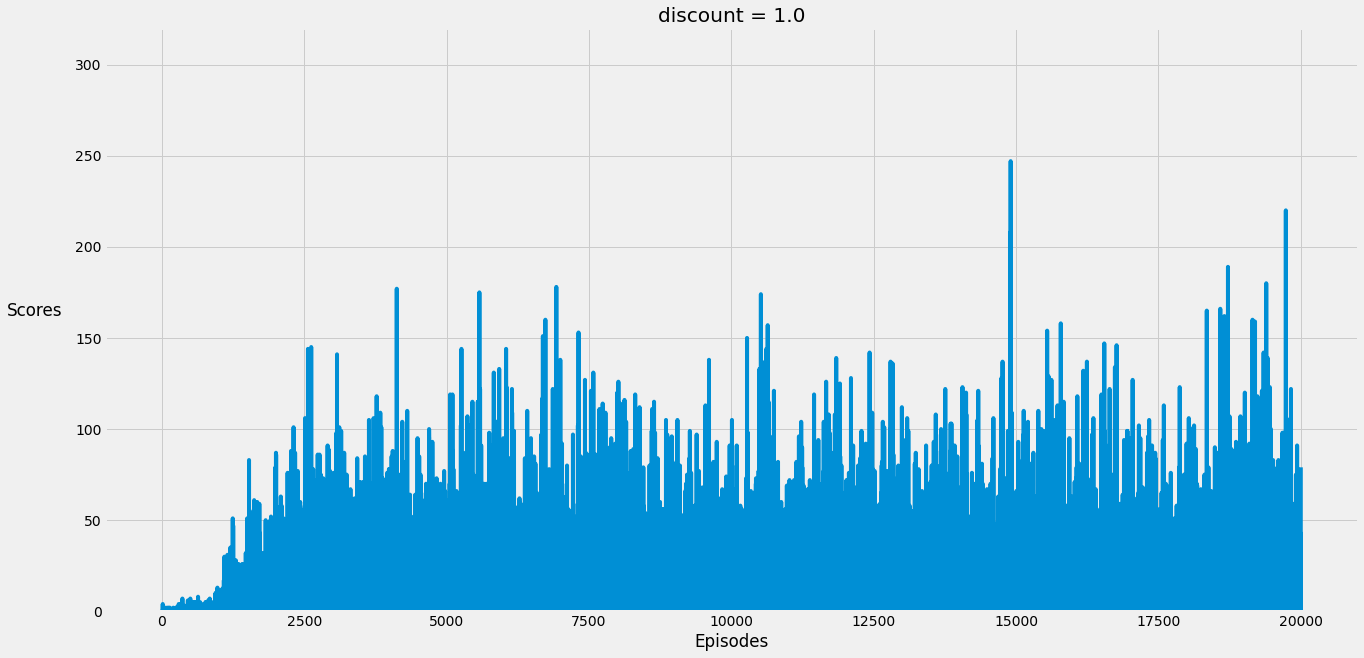

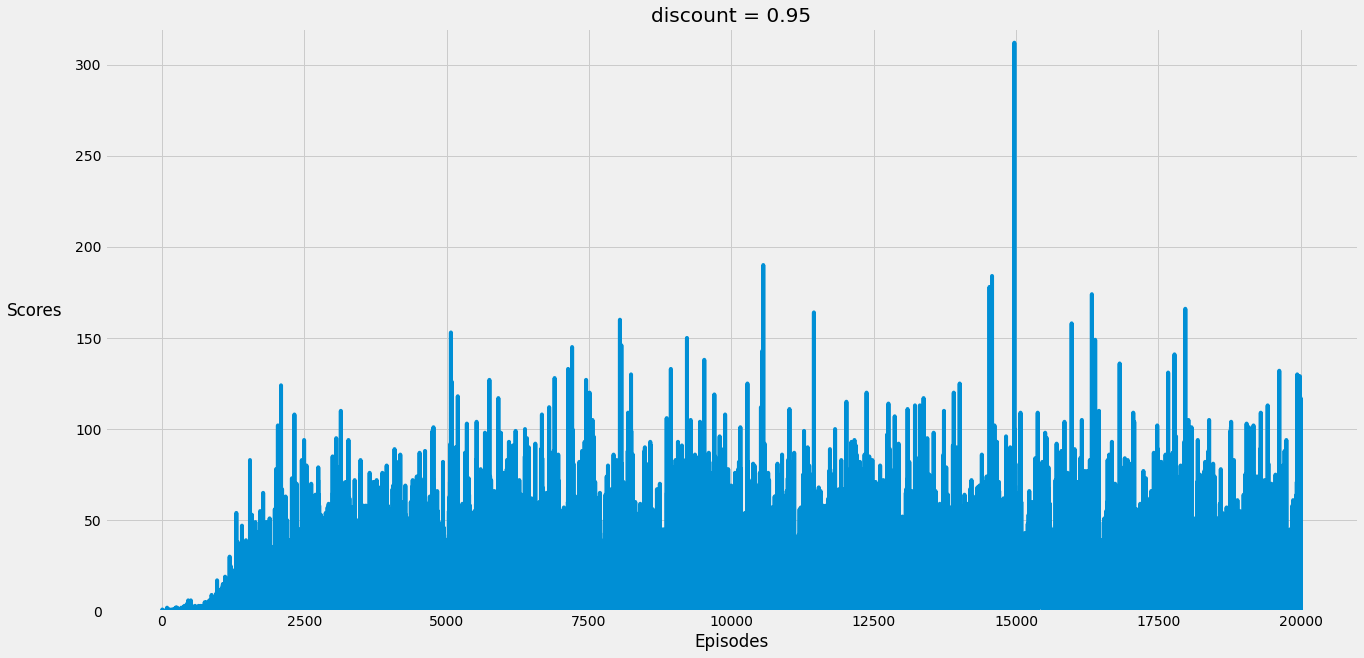

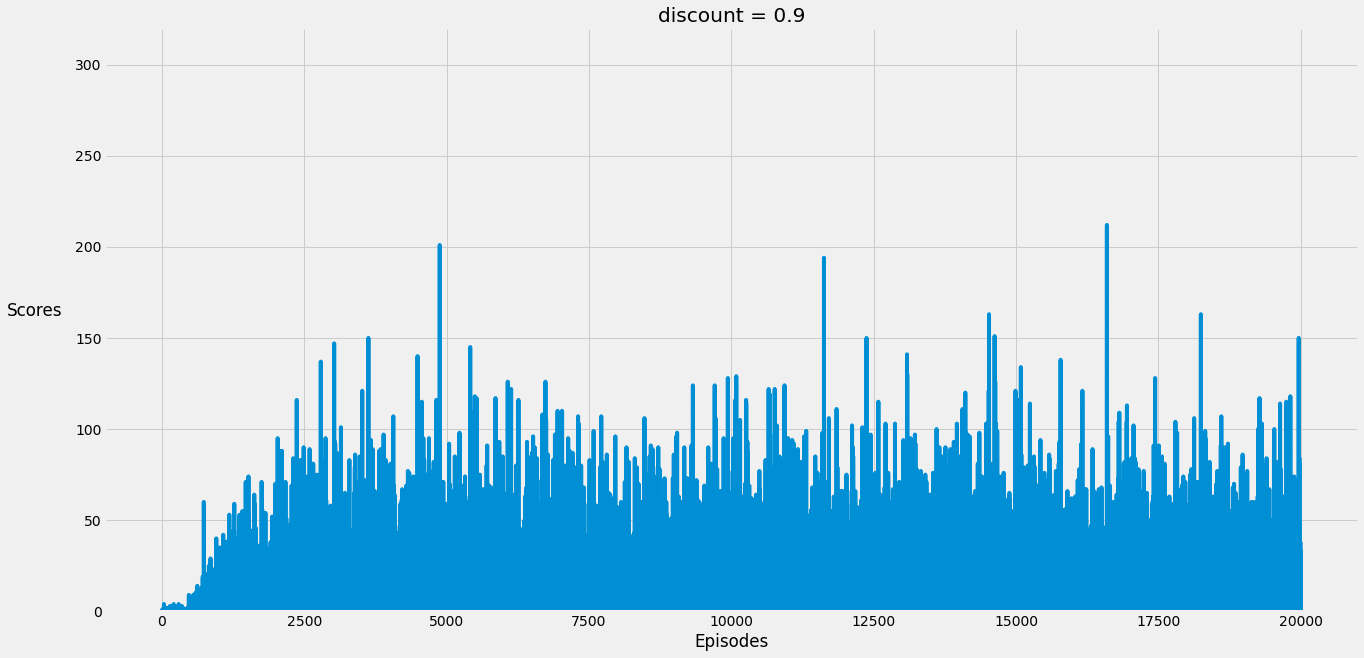

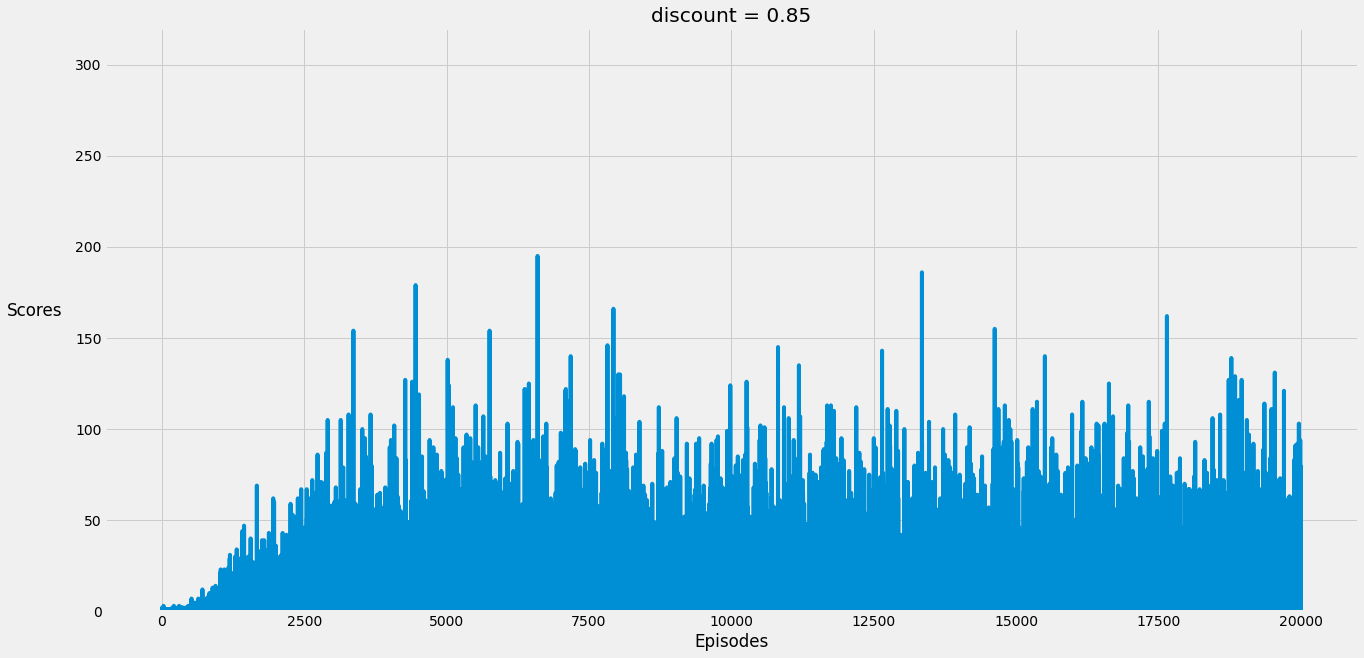

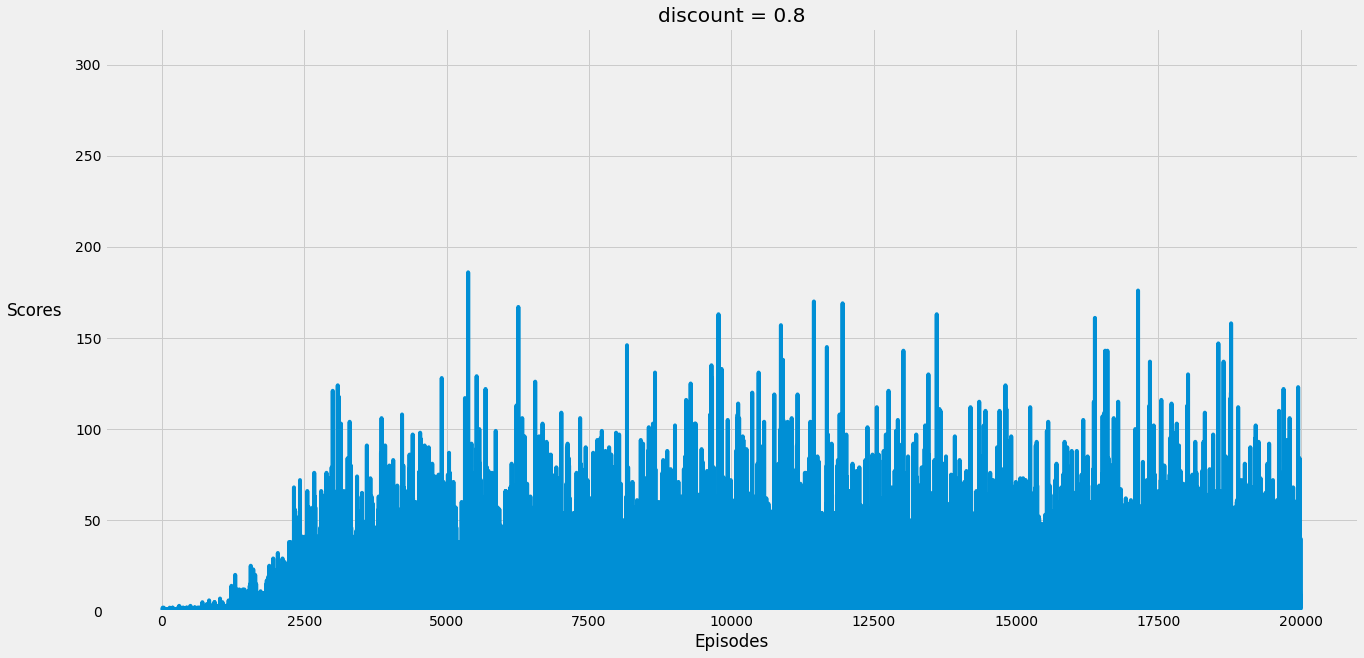

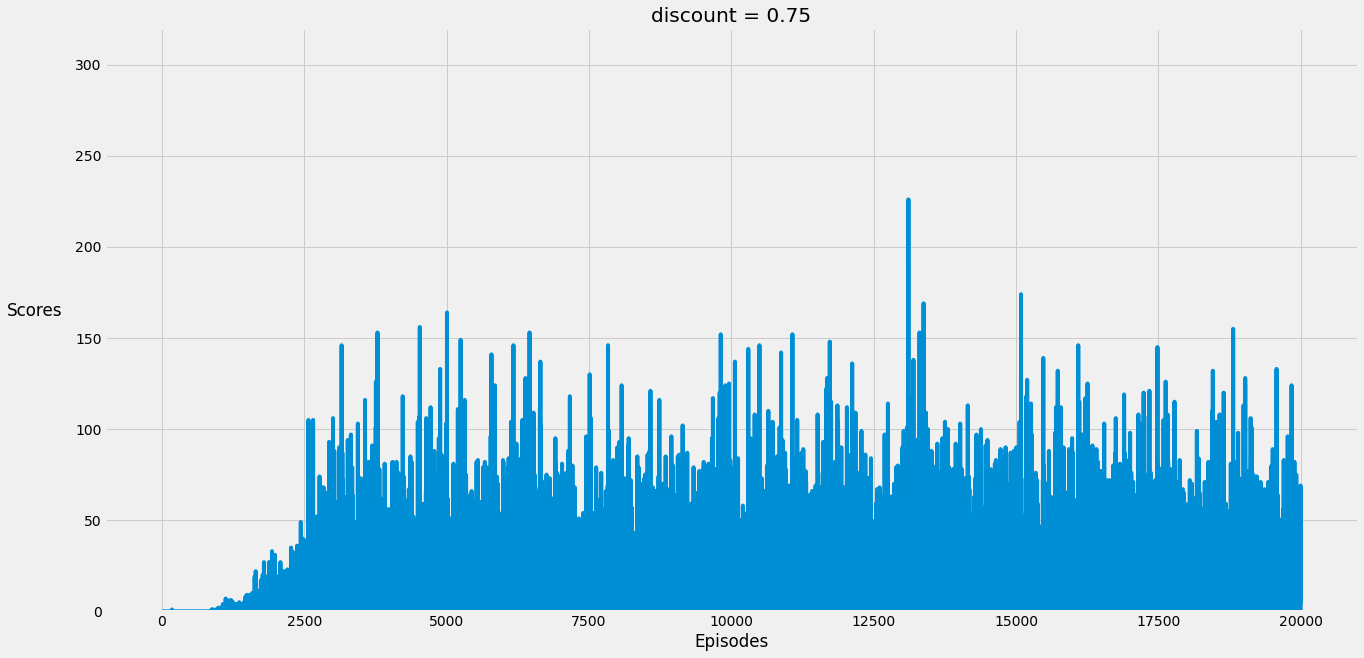

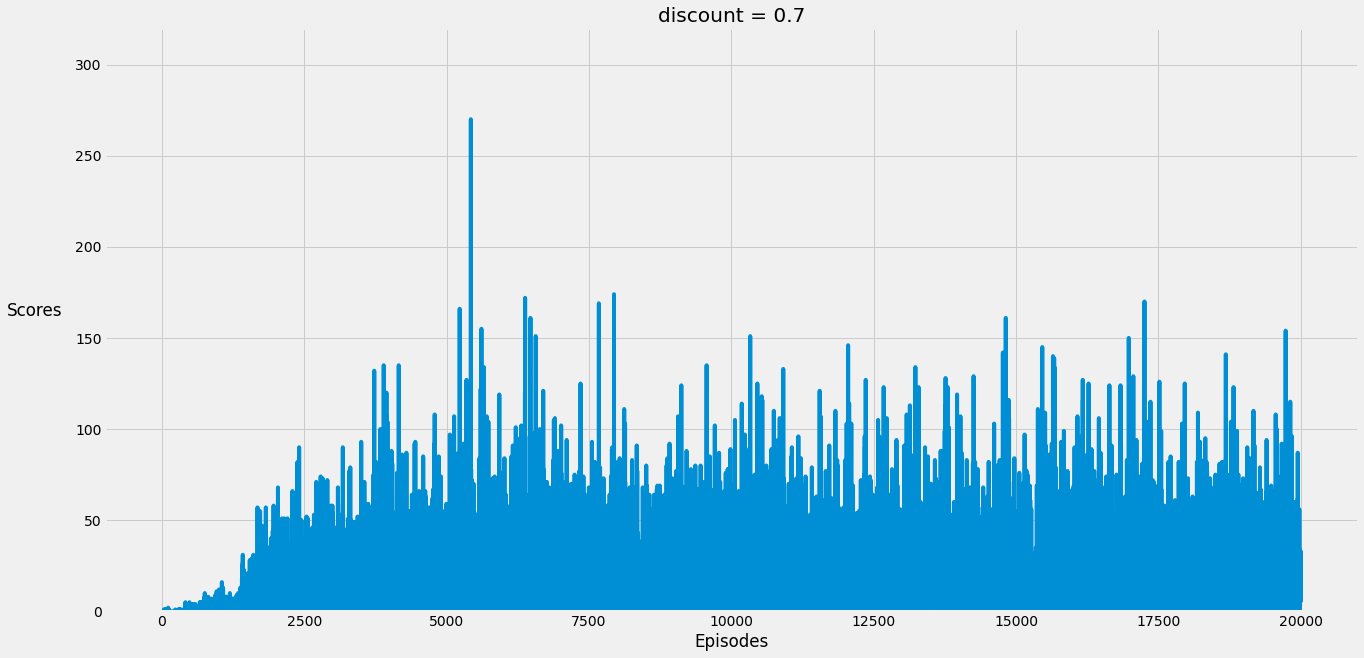

In [ ]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 320)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


discount = 1.0
Mean:  18.60065
Median:  12.0
Max:  247
--------------------
discount = 0.95
Mean:  16.56935
Median:  11.0
Max:  312
--------------------
discount = 0.9
Mean:  16.9447
Median:  11.0
Max:  212
--------------------
discount = 0.85
Mean:  16.36505
Median:  10.0
Max:  195
--------------------
discount = 0.8
Mean:  16.43785
Median:  10.0
Max:  186
--------------------
discount = 0.75
Mean:  16.80205
Median:  10.0
Max:  226
--------------------
discount = 0.7
Mean:  16.40655
Median:  10.0
Max:  270
--------------------


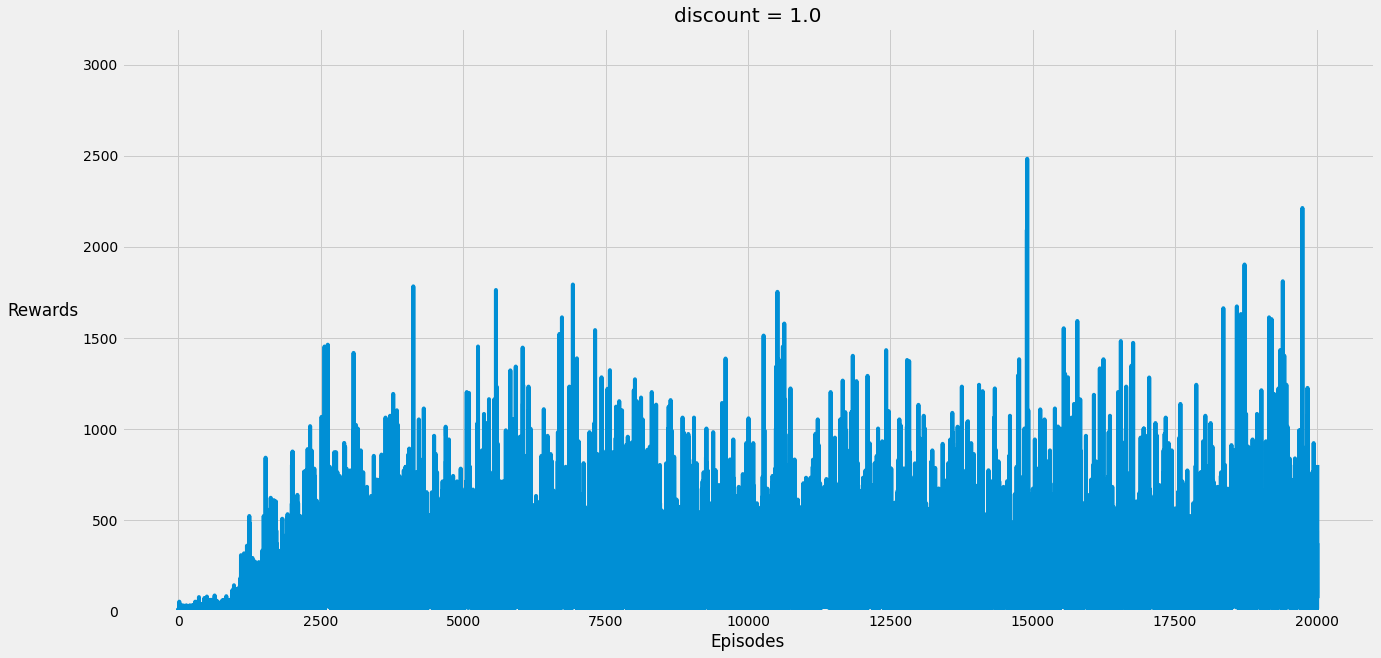

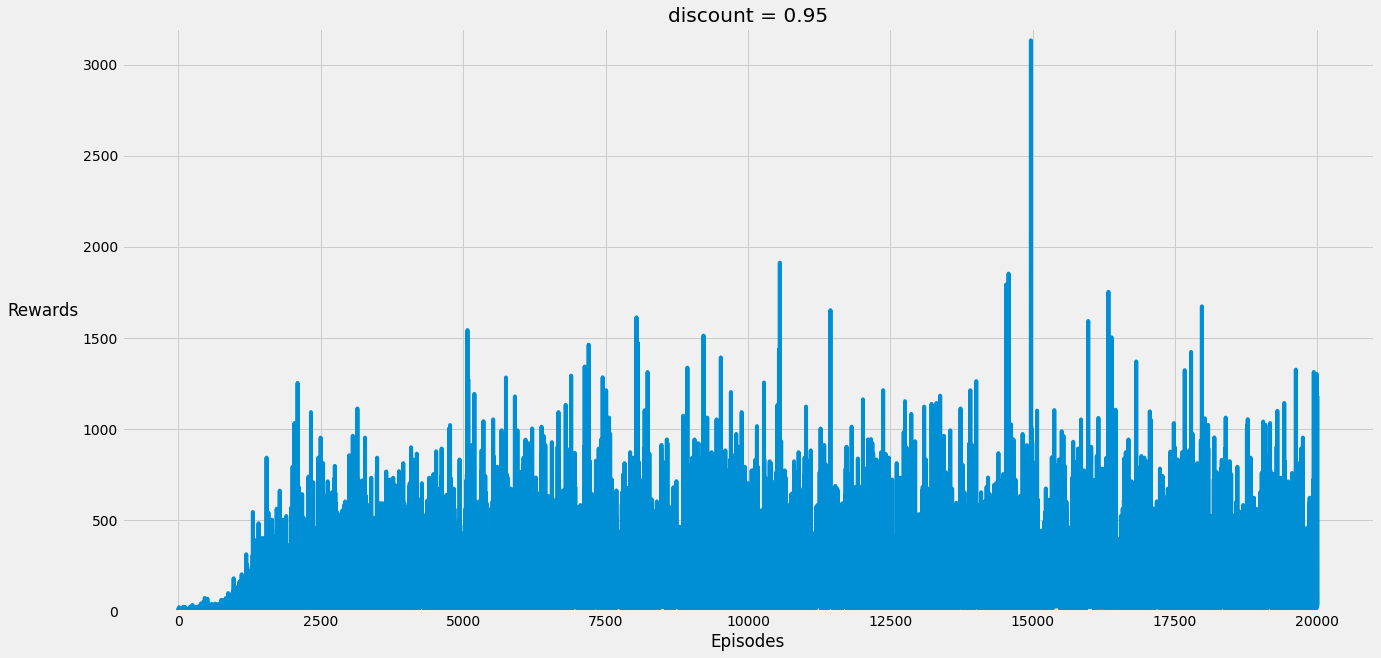

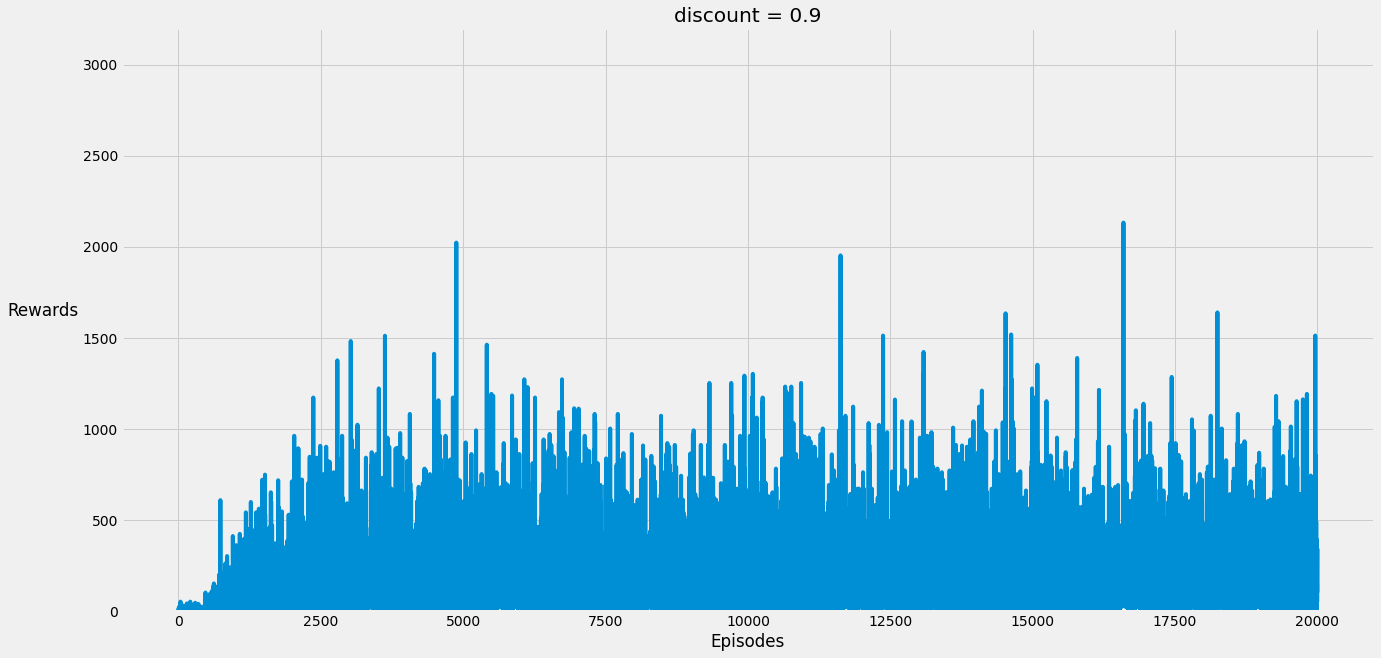

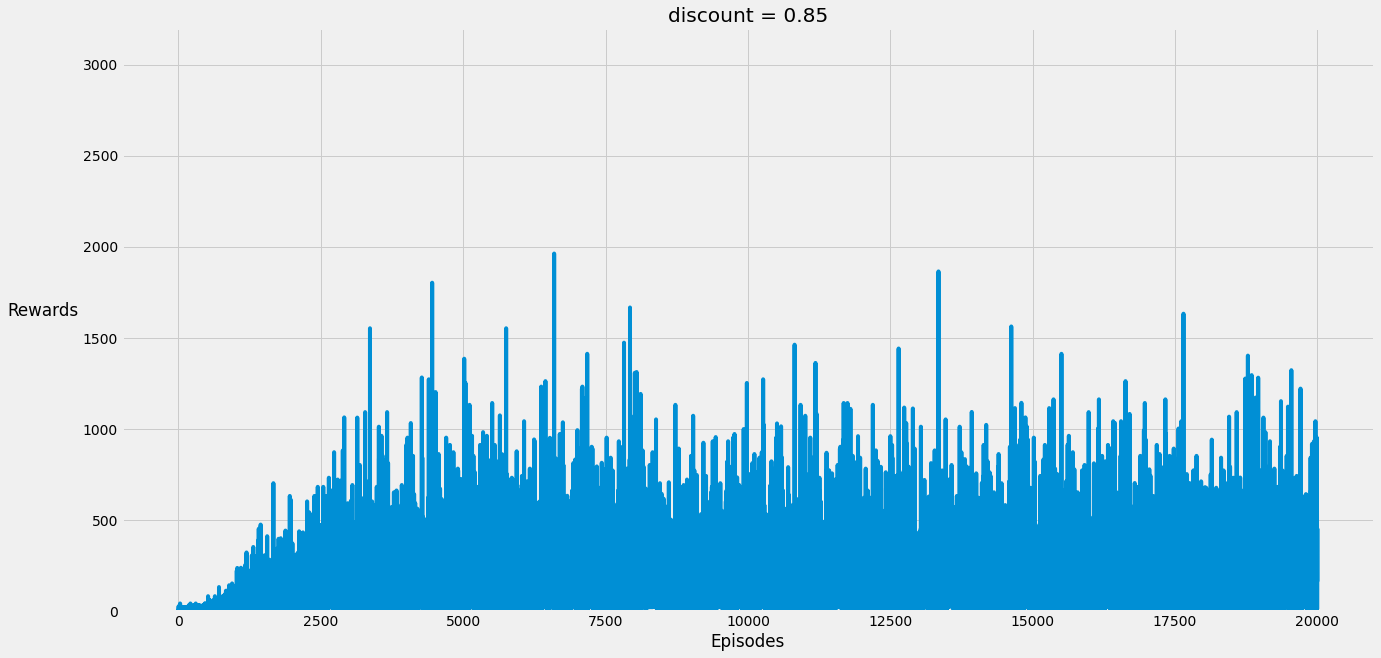

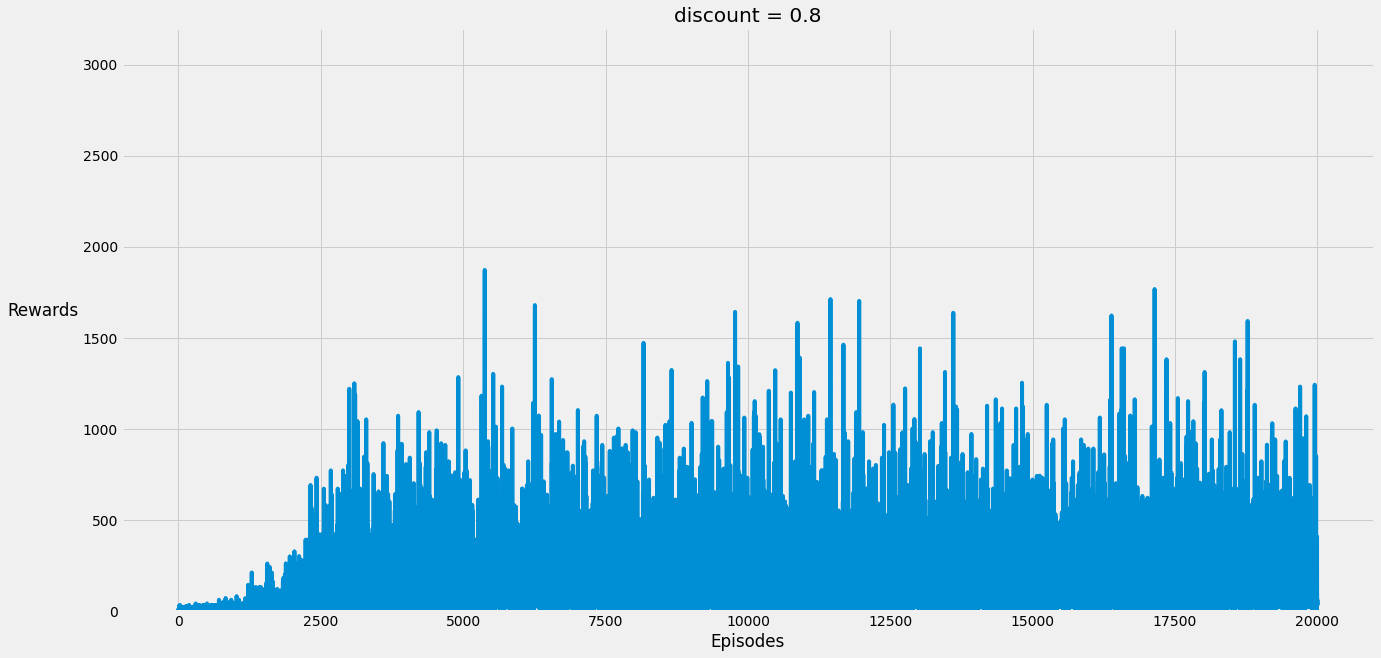

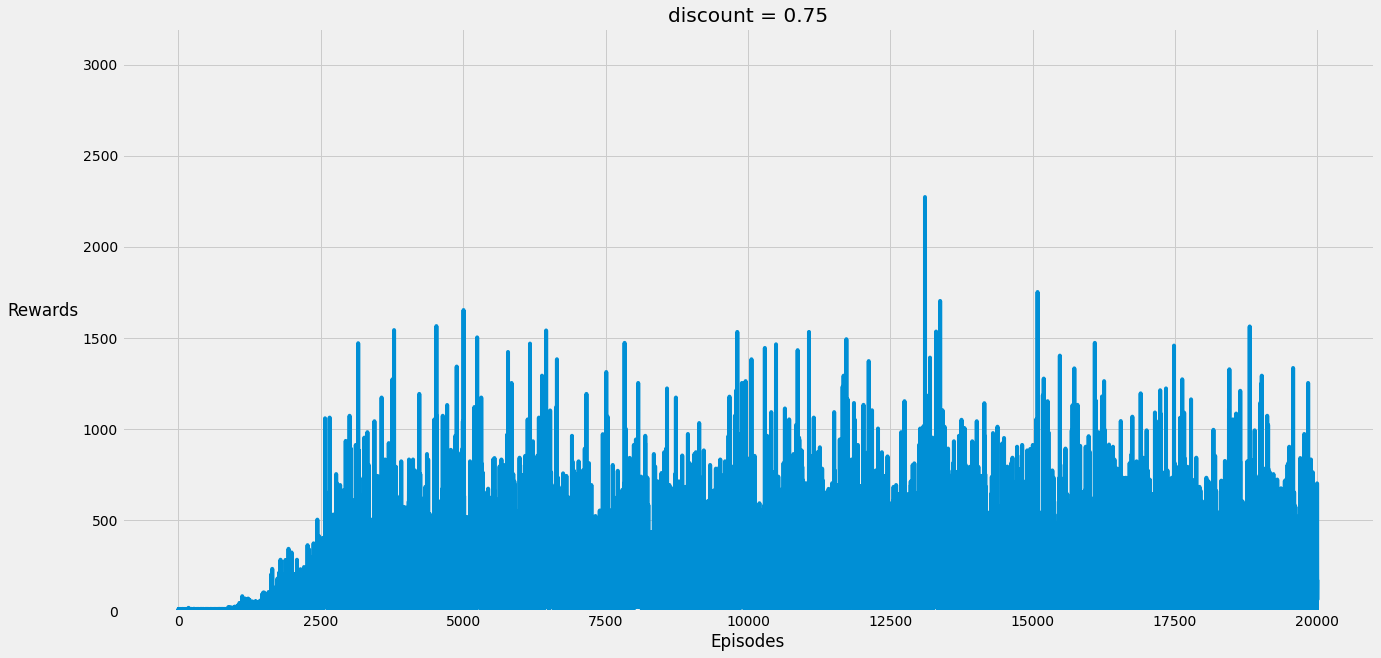

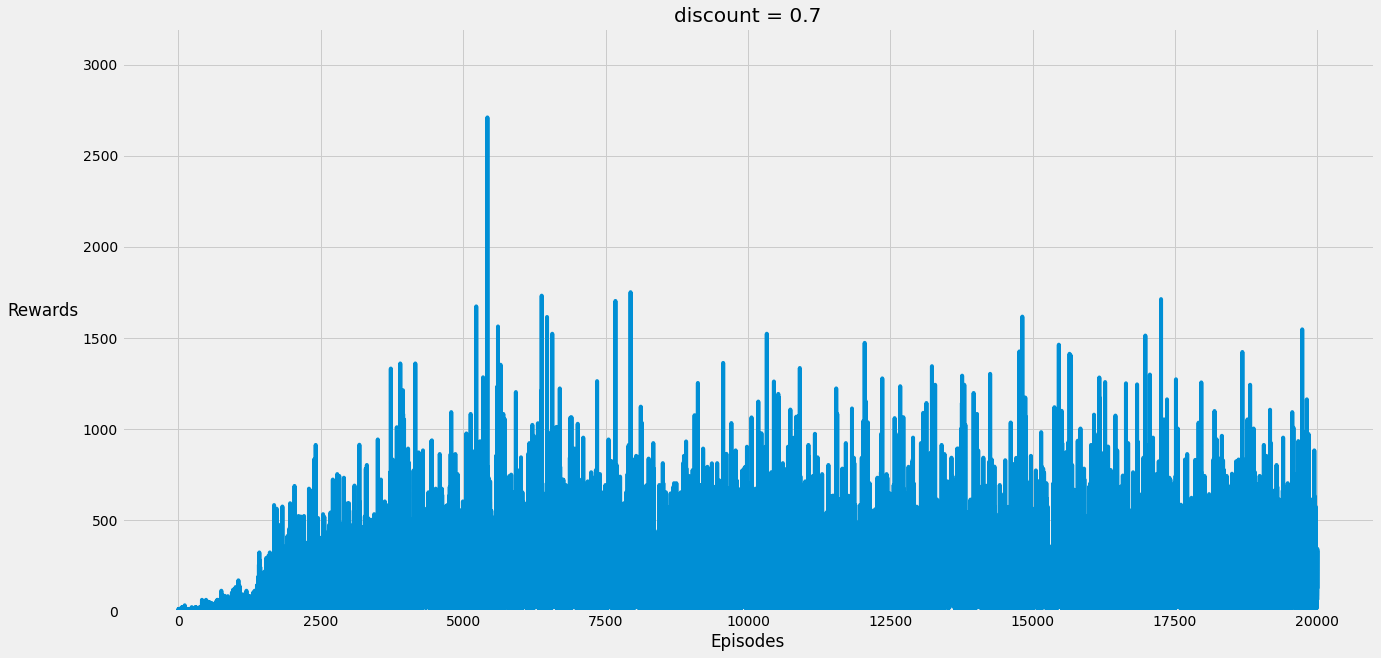

In [ ]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.ylim(0, 3200)
  plt.show()

In [ ]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


discount = 1.0
Mean:  197.97275
Median:  133.0
Max:  2483
--------------------
discount = 0.95
Mean:  177.50725
Median:  116.0
Max:  3133
--------------------
discount = 0.9
Mean:  181.24305
Median:  123.0
Max:  2133
--------------------
discount = 0.85
Mean:  175.40695
Median:  113.0
Max:  1963
--------------------
discount = 0.8
Mean:  176.2574
Median:  113.0
Max:  1873
--------------------
discount = 0.75
Mean:  179.8743
Median:  113.0
Max:  2273
--------------------
discount = 0.7
Mean:  175.72915
Median:  113.0
Max:  2710
--------------------


Please see the result of the hyperparameter tuning of the discount rate γ after 20,000 runs of 500 episodes:


| Discount γ| Mean | Median | Max |
|------|------|------|------|
|   1.0 | 197.97 | 133 | 2,483 |
|   0.95 | 177.51 | 116 | 3,133 |
|   0.9 | 181.24 | 123 | 2,133 |
|   0.85 | 175.41 | 113 | 1,963 |
|   0.8 | 176.26 | 113 | 1,873 |
|   0.75 | 179.87 | 113 | 2,273 |
|   0.7 | 175.73 | 113 | 2,710 |

Based on the median and average scores, the discount rate γ to use to optimise the agent is γ=1.0. Therefore, the agent gives the same value / importance to every rewards regardless of the moment it receives them.


#### Step-size decay

In [6]:
agent = QLearningAgentTer()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999", "decay = 0.999","decay = 0.99", "decay =0.95", "decay = 0.9", "decay = 0.85"]
ss_decays = [1.0, 0.99999, 0.9999, 0.999, 0.99, 0.95, 0.9, 0.85]

every_scores = []
every_rewards = []

for step_size_decay in tqdm(ss_decays):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay":1.0, "step_size": 0.5, "step_size_decay": step_size_decay, "discount": 1.0}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 40000 # The number of runs
    num_episodes = 1000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)
                    break

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)


100%|██████████| 8/8 [1:07:15<00:00, 504.42s/it]


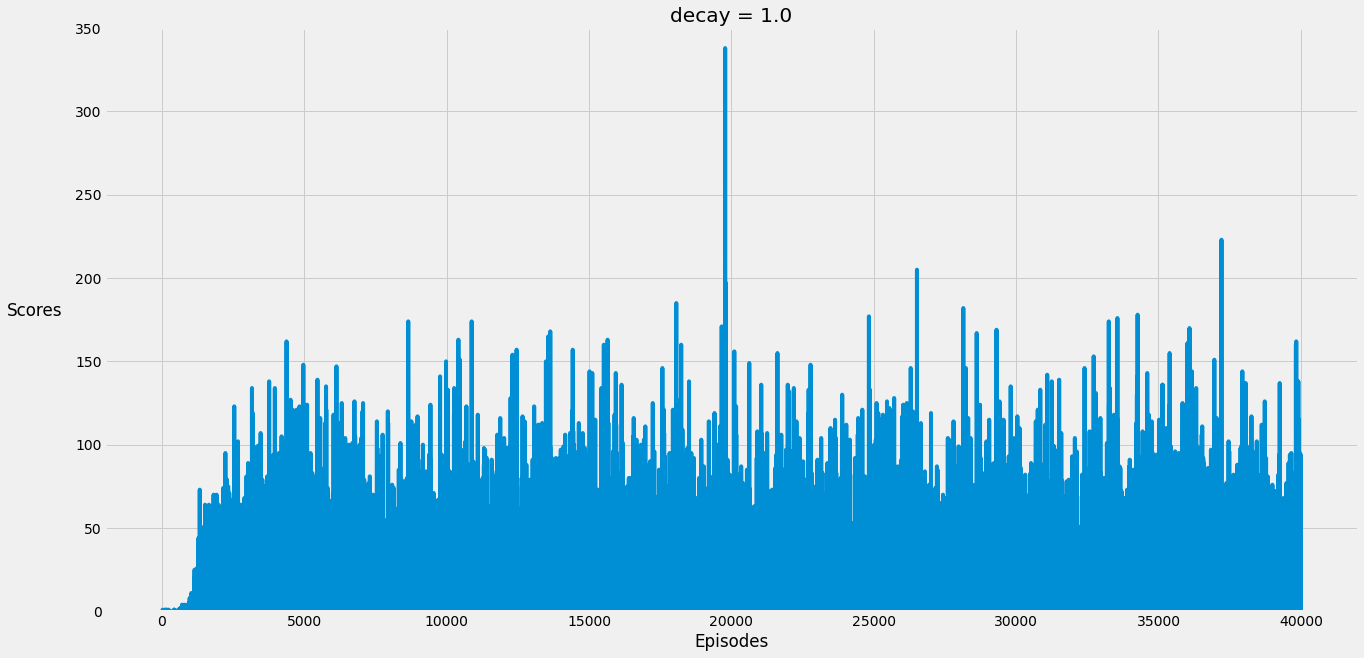

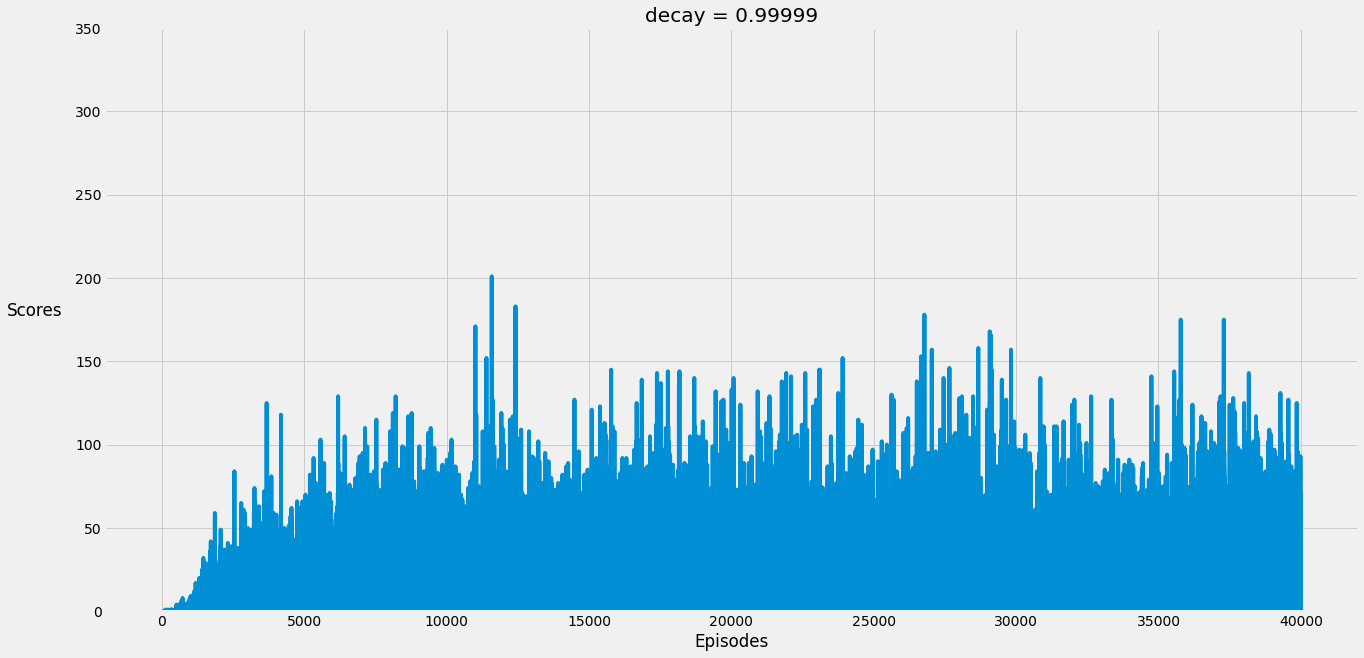

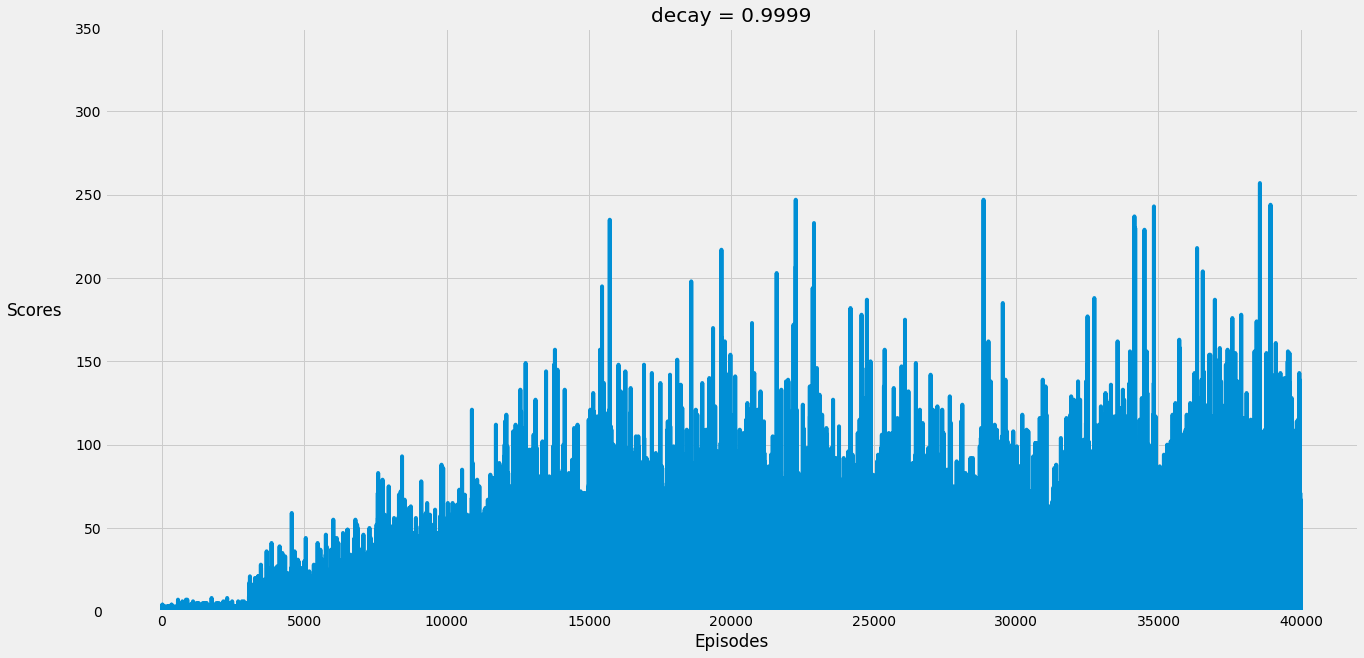

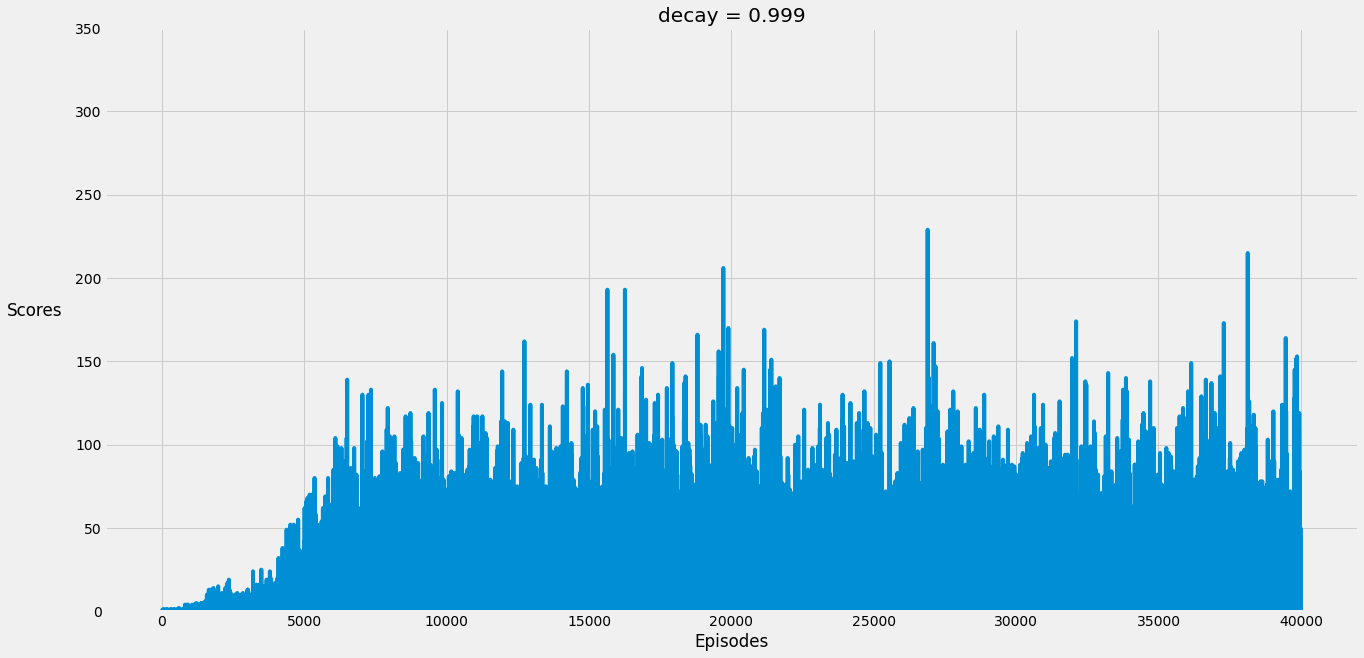

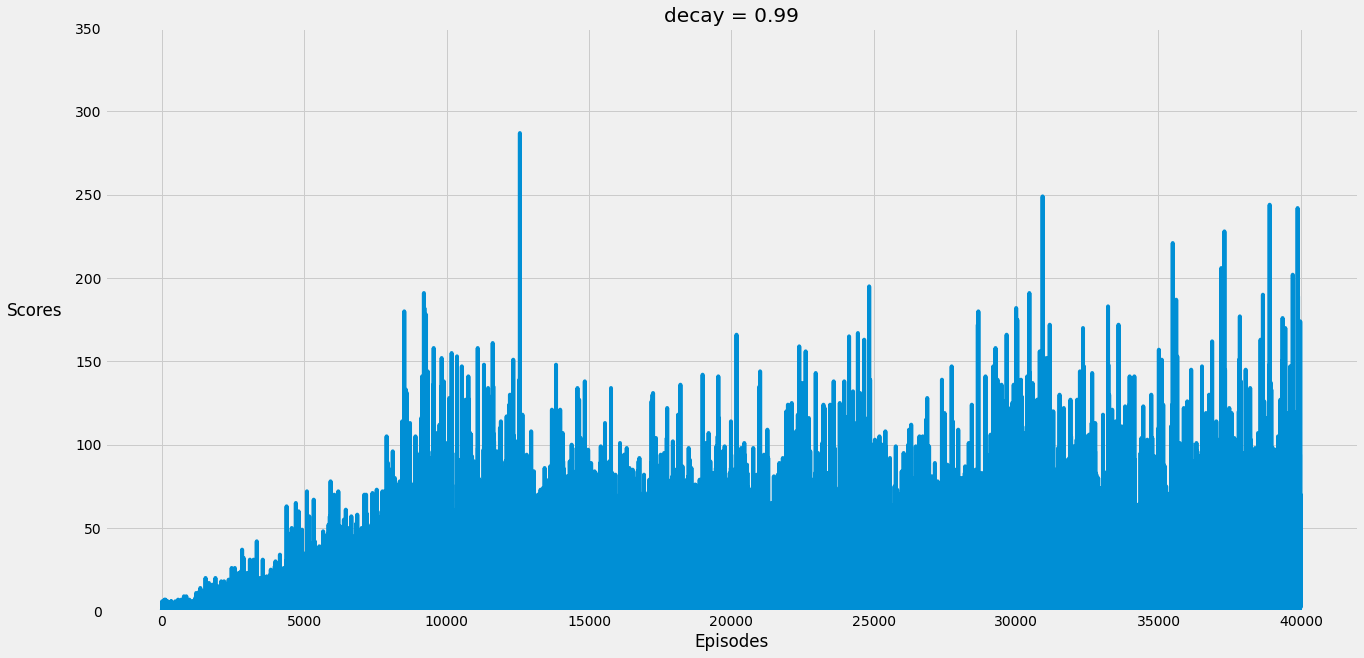

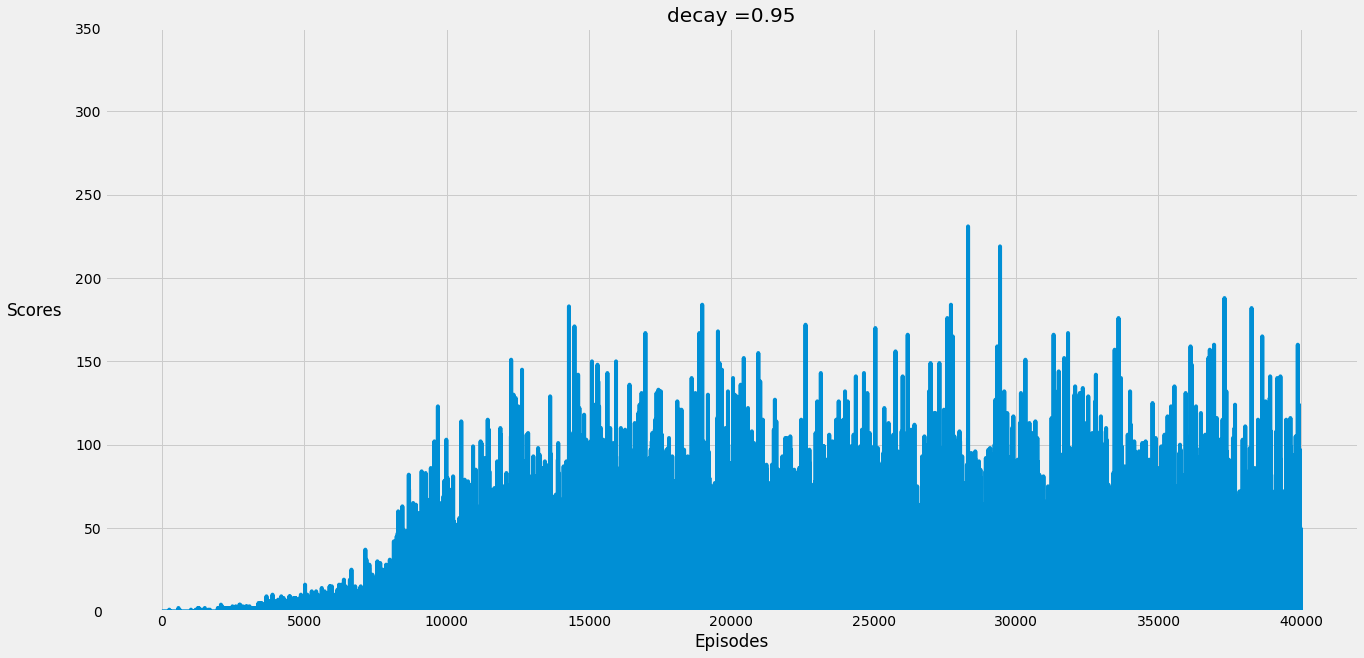

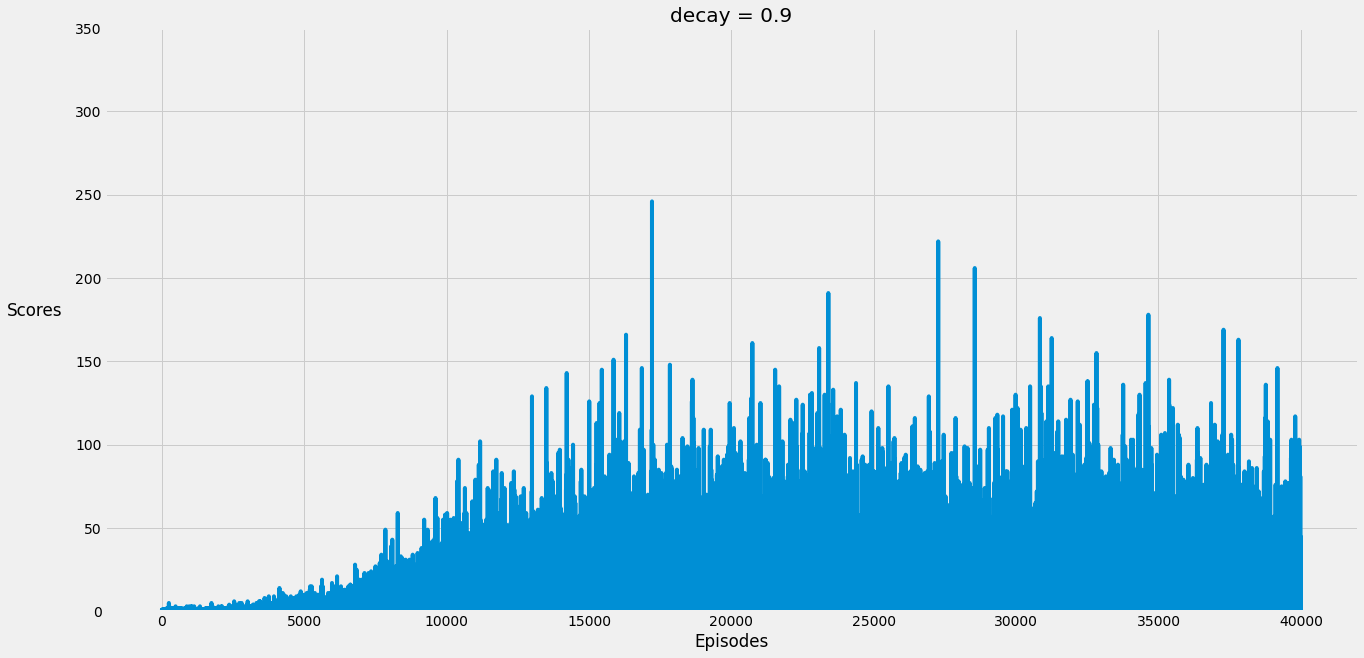

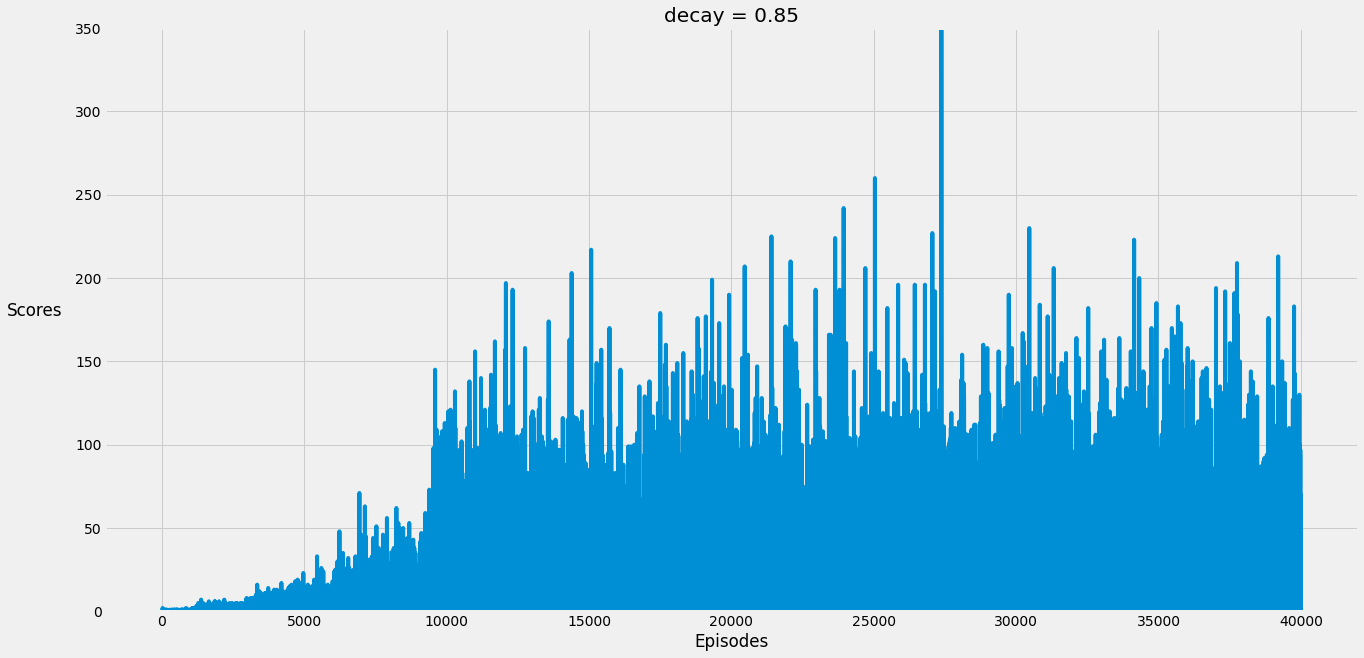

In [12]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.ylim(0, 350)
  plt.show()

In [13]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i][:-5000]))
  print("Median: ", np.median(every_scores[i][:-5000]))
  print("Max: ", np.max(every_scores[i][:-5000]))
  print('-'*20)


decay = 1.0
Mean:  18.676628571428573
Median:  12.0
Max:  338
--------------------
decay = 0.99999
Mean:  16.953085714285713
Median:  11.0
Max:  201
--------------------
decay = 0.9999
Mean:  17.217742857142856
Median:  10.0
Max:  247
--------------------
decay = 0.999
Mean:  17.27134285714286
Median:  11.0
Max:  229
--------------------
decay = 0.99
Mean:  17.76777142857143
Median:  11.0
Max:  287
--------------------
decay =0.95
Mean:  16.184057142857142
Median:  9.0
Max:  231
--------------------
decay = 0.9
Mean:  13.402657142857143
Median:  7.0
Max:  246
--------------------
decay = 0.85
Mean:  18.967342857142857
Median:  10.0
Max:  389
--------------------


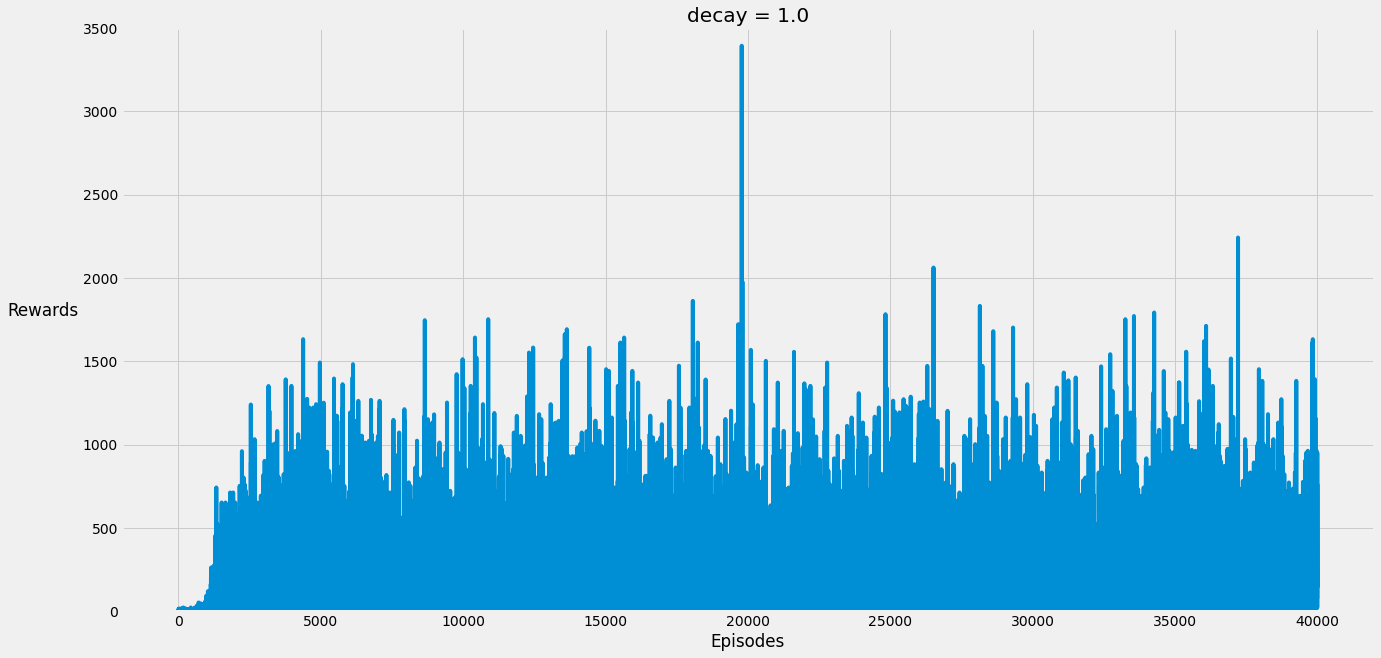

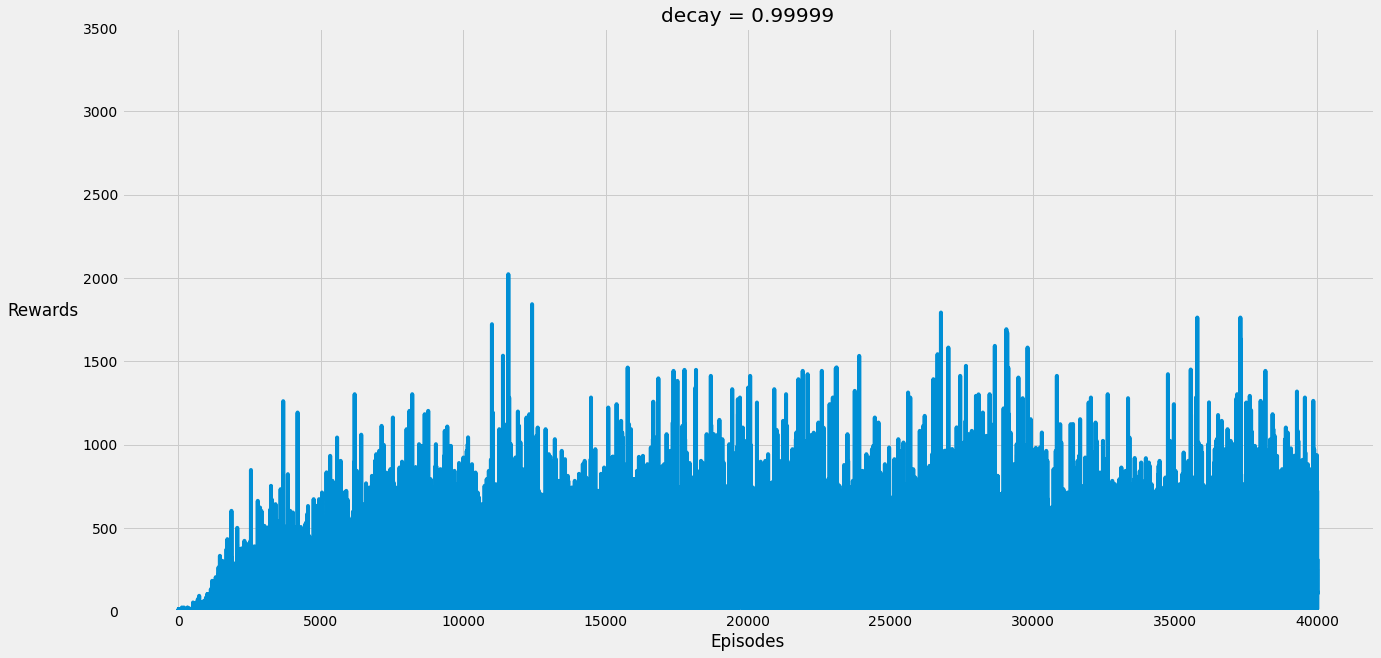

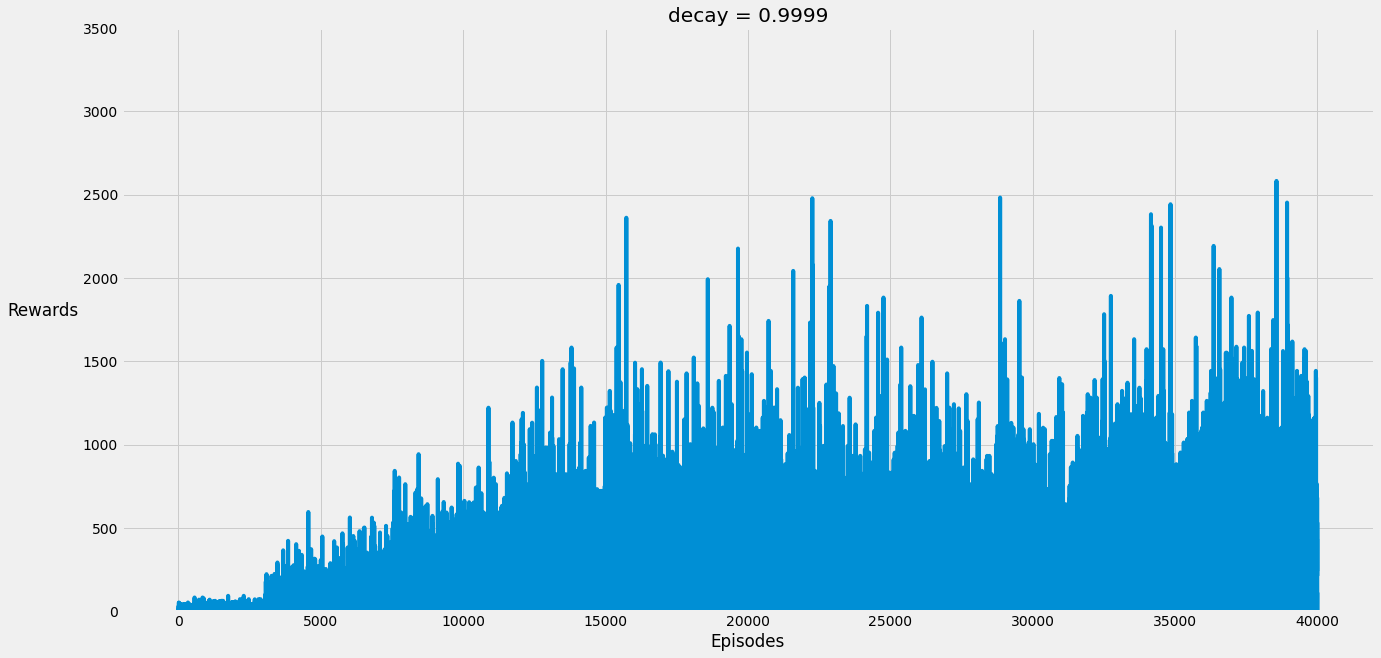

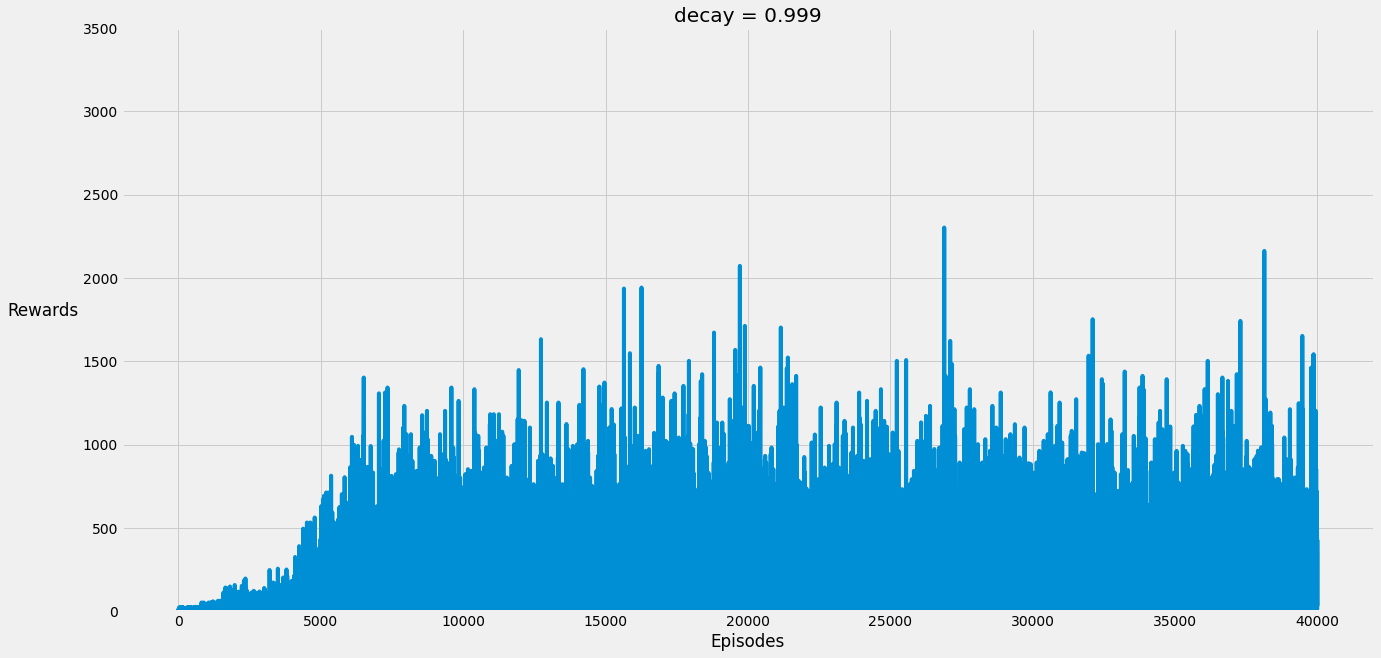

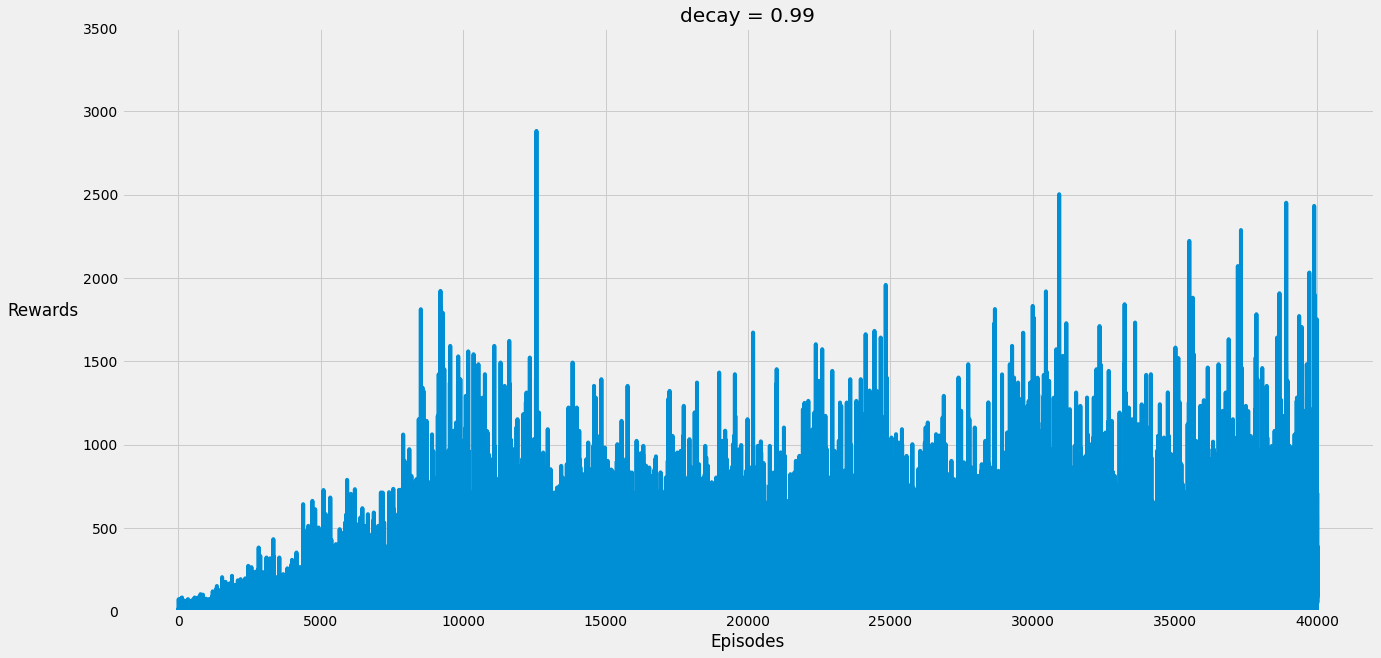

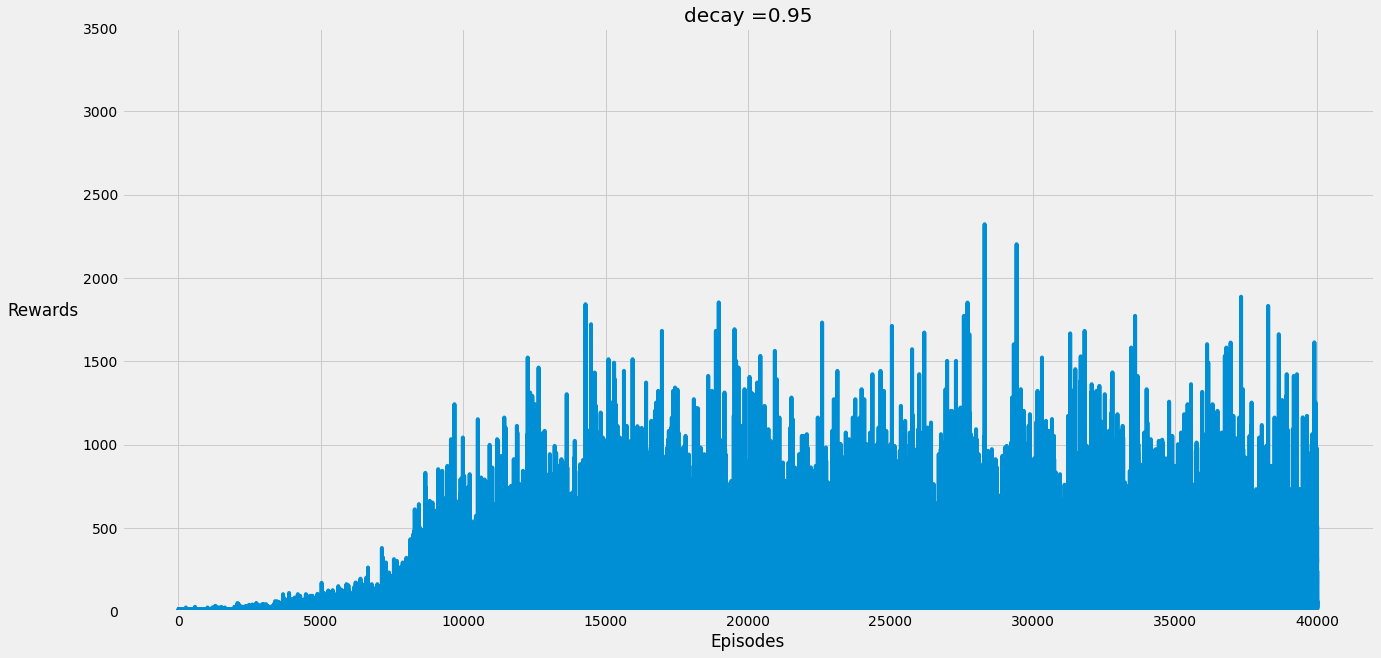

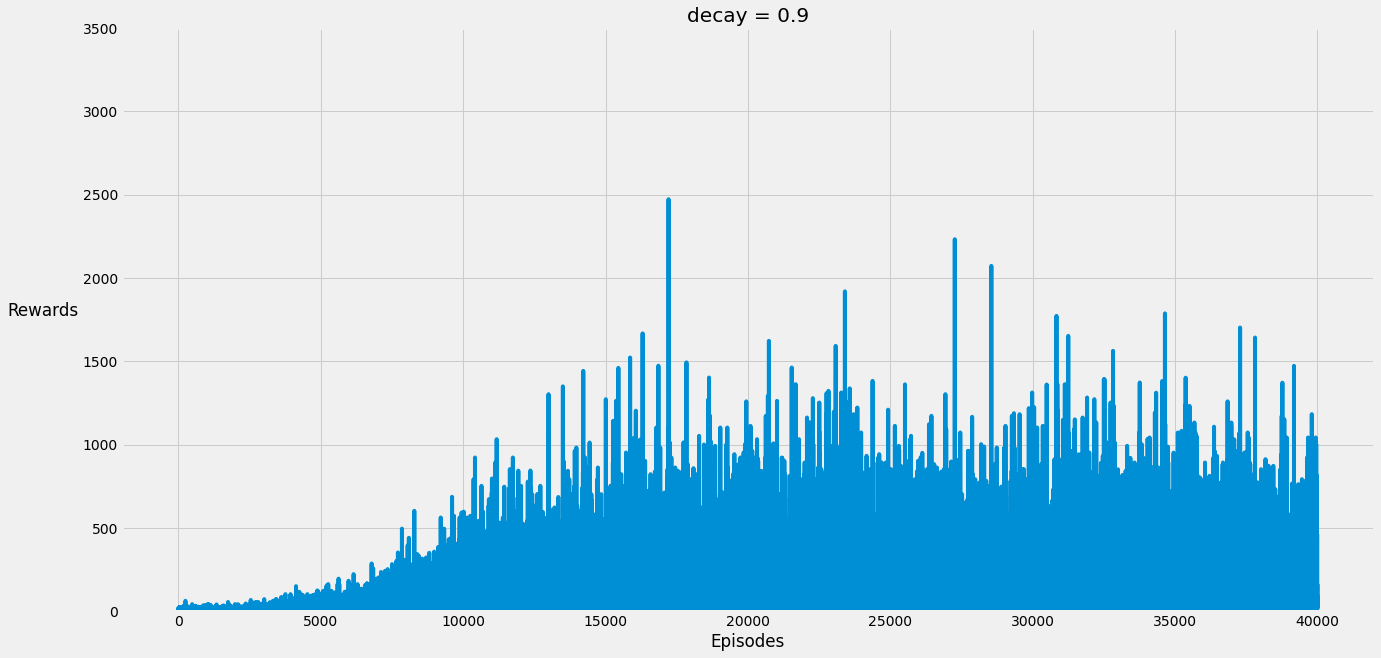

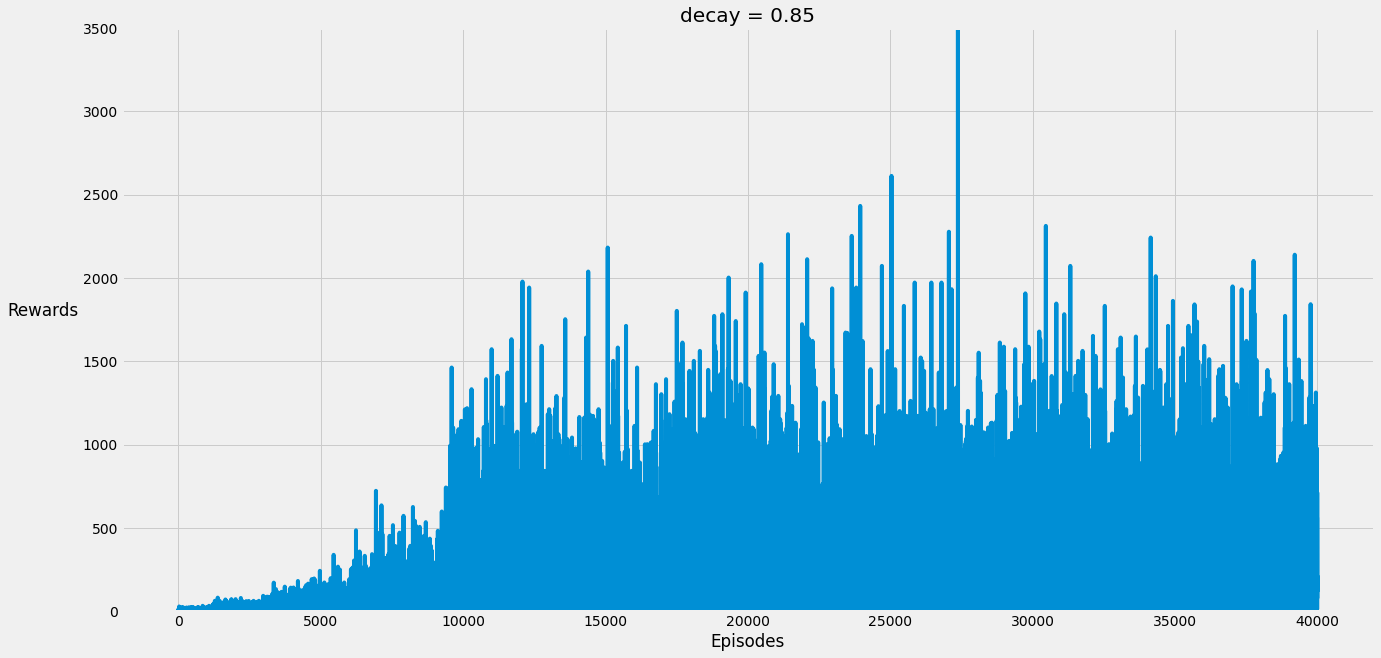

In [15]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.ylim(0, 3500)
  plt.show()

In [14]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i][:-5000]))
  print("Median: ", np.median(every_rewards[i][:-5000]))
  print("Max: ", np.max(every_rewards[i][:-5000]))
  print('-'*20)


decay = 1.0
Mean:  198.8239142857143
Median:  133.0
Max:  3394
--------------------
decay = 0.99999
Mean:  181.717
Median:  123.0
Max:  2023
--------------------
decay = 0.9999
Mean:  183.9307142857143
Median:  113.0
Max:  2483
--------------------
decay = 0.999
Mean:  184.64657142857143
Median:  117.5
Max:  2303
--------------------
decay = 0.99
Mean:  189.66491428571427
Median:  122.0
Max:  2883
--------------------
decay =0.95
Mean:  173.8602
Median:  103.0
Max:  2323
--------------------
decay = 0.9
Mean:  145.59662857142857
Median:  83.0
Max:  2473
--------------------
decay = 0.85
Mean:  201.1922857142857
Median:  113.0
Max:  3903
--------------------


Please see the result of the hyperparameter tuning of the step-size decay over the last 5,000 runs (40,000 runs in total):


| Step-size decay| Mean | Median | Max |
|------|------|------|------|
|   1.0 | 198.82 | 133 | 3,394 |
|   0.99999 | 181.72  | 123 | 2,023 |
|   0.9999 | 183.93 | 113 | 2,483 |
|   0.999 | 184.65  | 117.5 | 2,303 |
|   0.99 | 189.66 | 122 | 2,883 |
|   0.95 | 173.86 | 103 | 2,323 |
|   0.9 | 145.60 | 83 | 2,473 |
|   0.85 | 201.19 | 113 | 3,903 |

Based on the median and average scores, the step-size decay to use to optimise the agent is 1.0 (i.e. no decrease of the step-size). 

#### Epsilon decay

In [ ]:
agent = QLearningAgentTer()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999"]
eps_decays = [1.0, 0.99999,  0.9999 ]

every_scores = []
every_rewards = []

for eps_decay in tqdm(eps_decays):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay": eps_decay, "step_size": 0.5, "step_size_decay": 1.0, "discount": 1.0}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 40000 # The number of runs
    num_episodes = 1000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)
                    break

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)


 33%|███▎      | 1/3 [10:05<20:10, 605.20s/it]

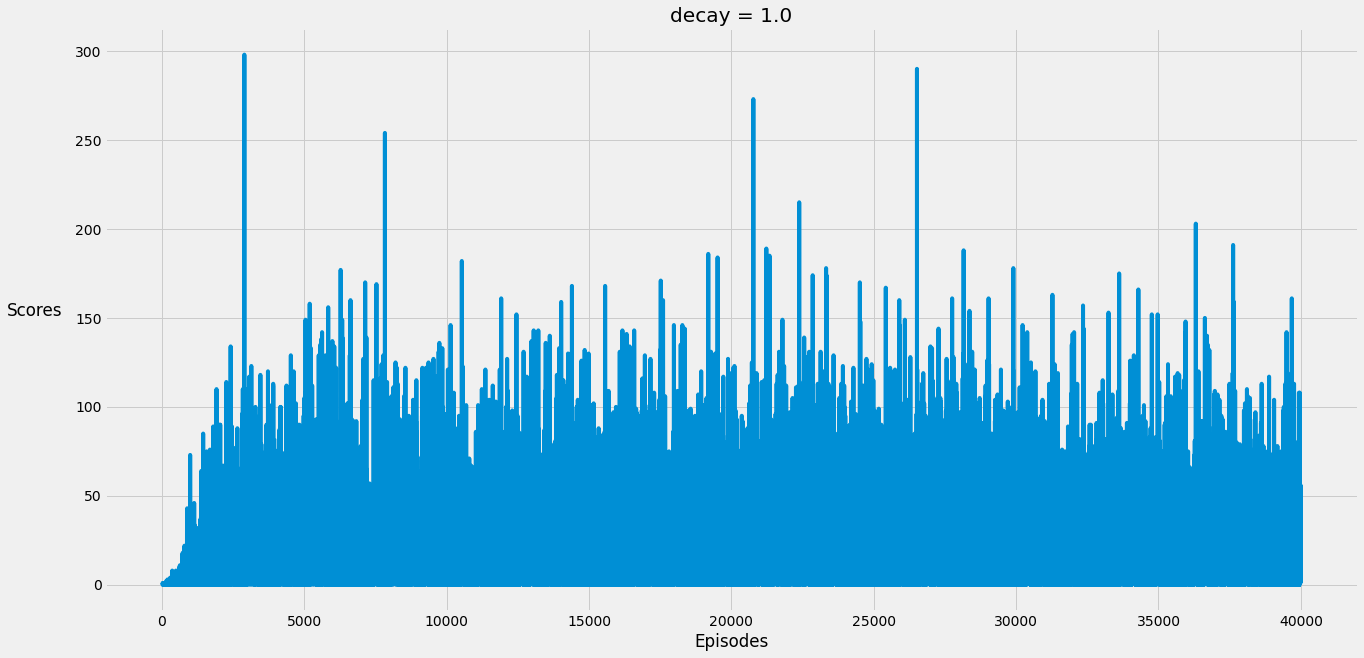

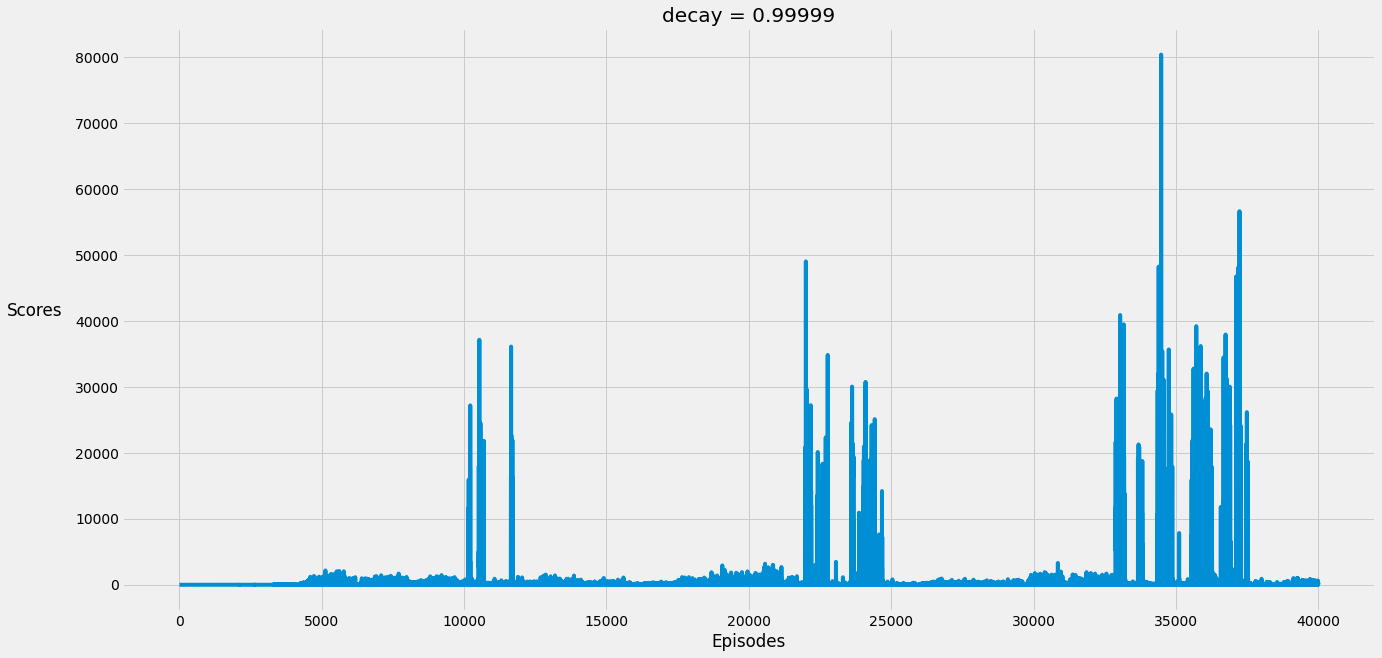

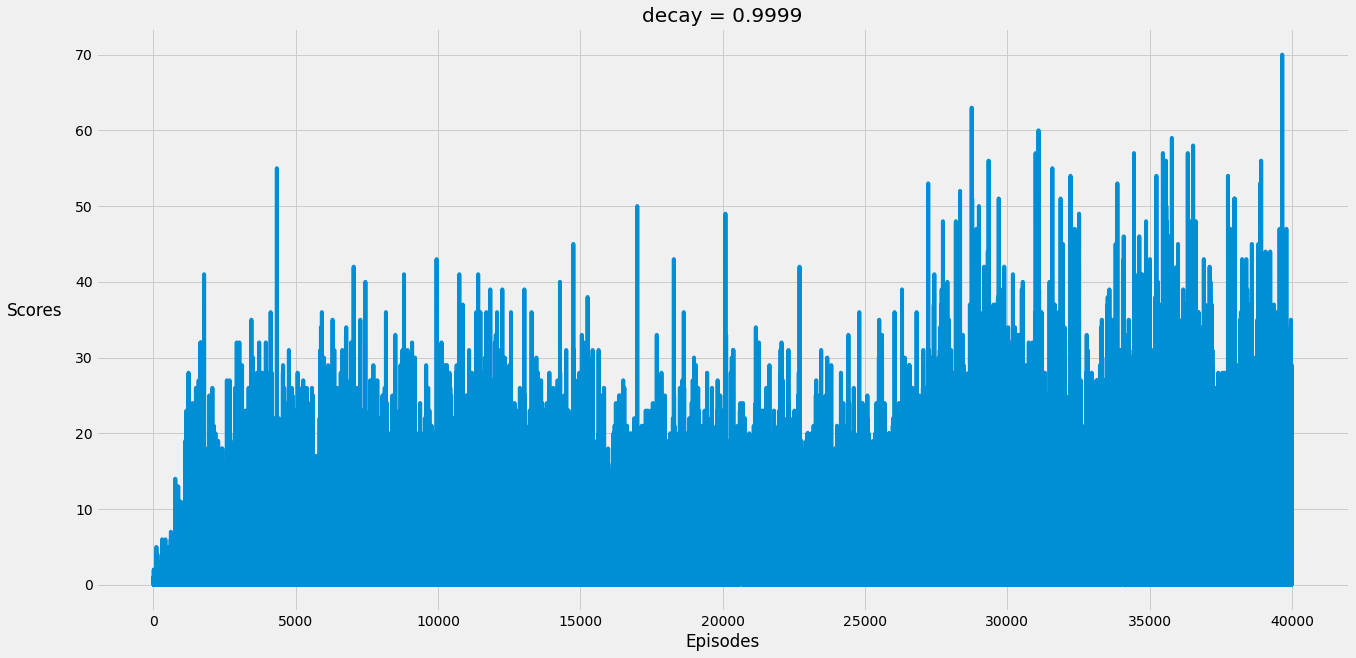

In [15]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.show()

In [16]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i][:-5000]))
  print("Median: ", np.median(every_scores[i][:-5000]))
  print("Max: ", np.max(every_scores[i][:-5000]))
  print('-'*20)


decay = 1.0
Mean:  20.737571428571428
Median:  14.0
Max:  298
--------------------
decay = 0.99999
Mean:  361.24694285714287
Median:  51.0
Max:  80410
--------------------
decay = 0.9999
Mean:  5.486542857142857
Median:  4.0
Max:  63
--------------------


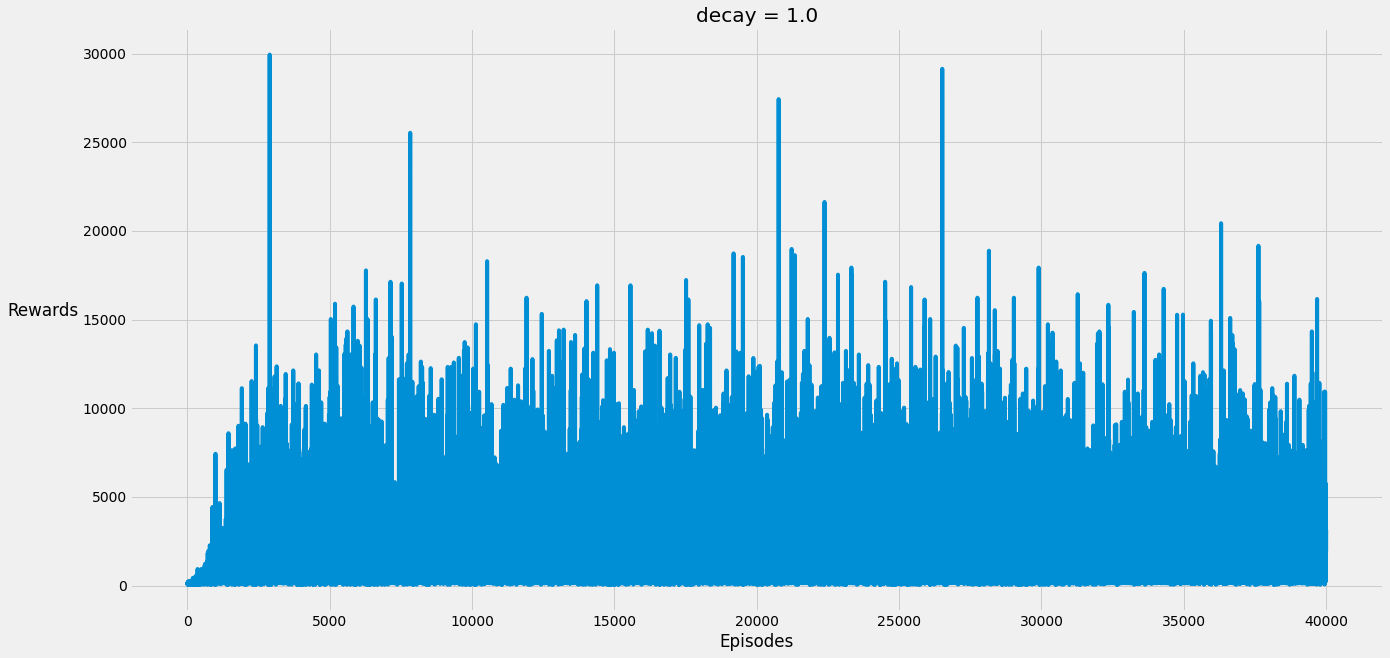

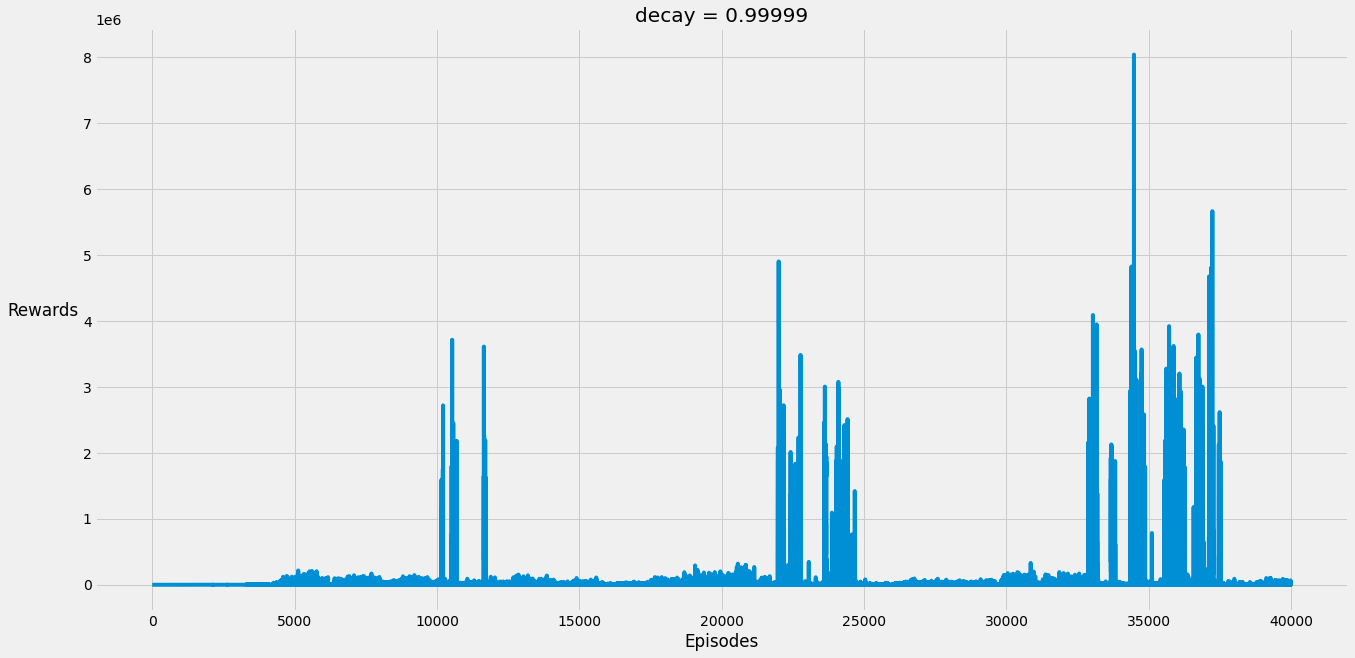

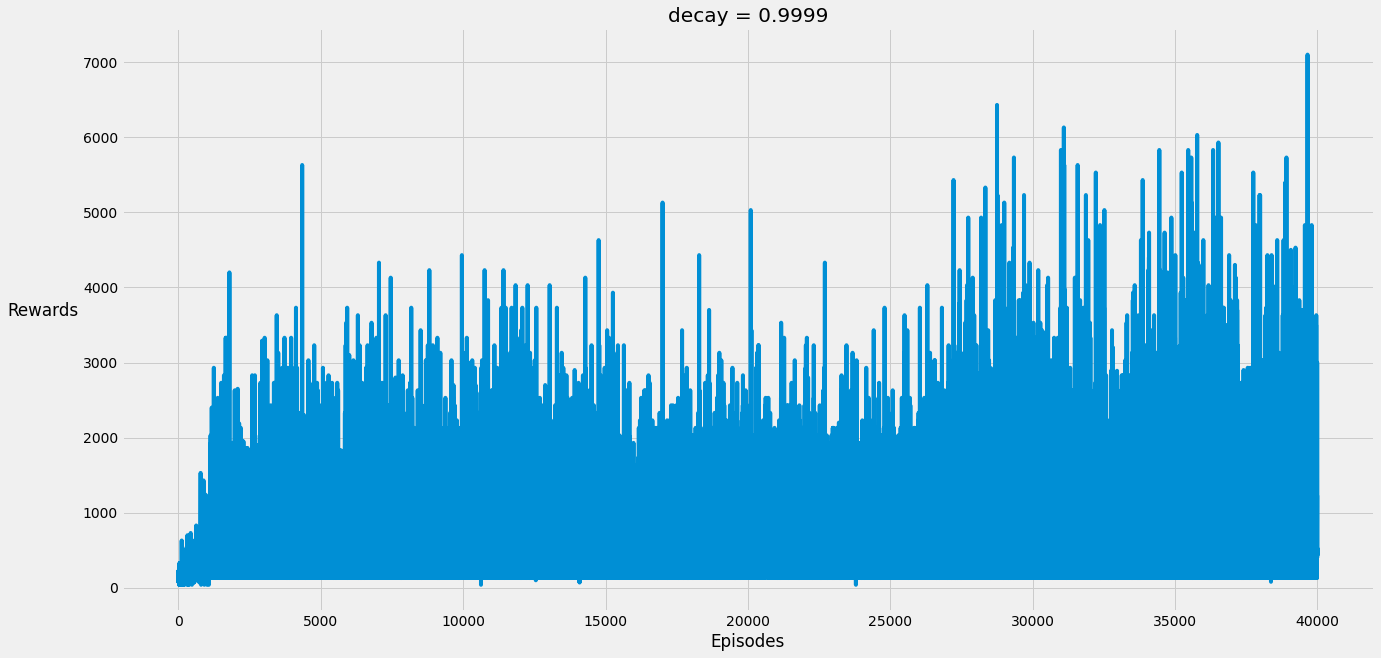

In [17]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.show()

In [18]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i][:-5000]))
  print("Median: ", np.median(every_rewards[i][:-5000]))
  print("Max: ", np.max(every_rewards[i][:-5000]))
  print('-'*20)


decay = 1.0
Mean:  2193.038285714286
Median:  1490.0
Max:  29940
--------------------
decay = 0.99999
Mean:  36250.674
Median:  5230.0
Max:  8041130
--------------------
decay = 0.9999
Mean:  675.0422857142858
Median:  530.0
Max:  6430
--------------------


Please see the results of the hyperparameter tuning of the epsilon decay over the last 5,000 runs (40,000 runs in total):


| Step-size decay| Mean | Median | Max |
|------|------|------|------|
|   1.0 | 2,193.03 | 1490 | 29,940 |
|   0.99999 | 36,250.67  | 5,230 | 8,041,130 |
|   0.9999 |  675.04 | 530 | 6,430 |

Based on the median and average rewards, the epsilon decay to use to optimise the agent is 0.99999. 

## Agent n°2: Expected SARSA

### Class definition

In [7]:
class ExpectedSarsaAgent():
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.eps_decay = agent_init_info["eps_decay"]
        self.step_size = agent_init_info["step_size"]
        self.step_size_decay = agent_init_info["step_size_decay"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Create a dictionary for action-value estimates
        self.q = {}


    def is_state_explored(self, state):
      if (state, 0) not in self.q:
            self.q[(state, 0)] = 0
        
      if (state, 1) not in self.q:
            self.q[(state, 1)] = 0

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Check if the state has already been visited
        self.is_state_explored(state)
        
        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        
        self.prev_state = state
        self.prev_action = action

        
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Check if the state has already been visited
        self.is_state_explored(state)

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]
        
        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        
        # Perform an update
        expected_q = 0
        max_q = np.max(current_q)

        pi = np.ones(self.num_actions) * self.epsilon / self.num_actions + (current_q == max_q) * (1 - self.epsilon) / np.sum(current_q == max_q) # Compute the probability of choosing the greedy action
           
        expected_q = np.sum(current_q * pi)
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * expected_q - self.q[(self.prev_state, self.prev_action)])
        
        # Decay for the step-size
        self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 

        self.prev_state = state
        self.prev_action = action

        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])

        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Baseline

100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1170.58it/s]


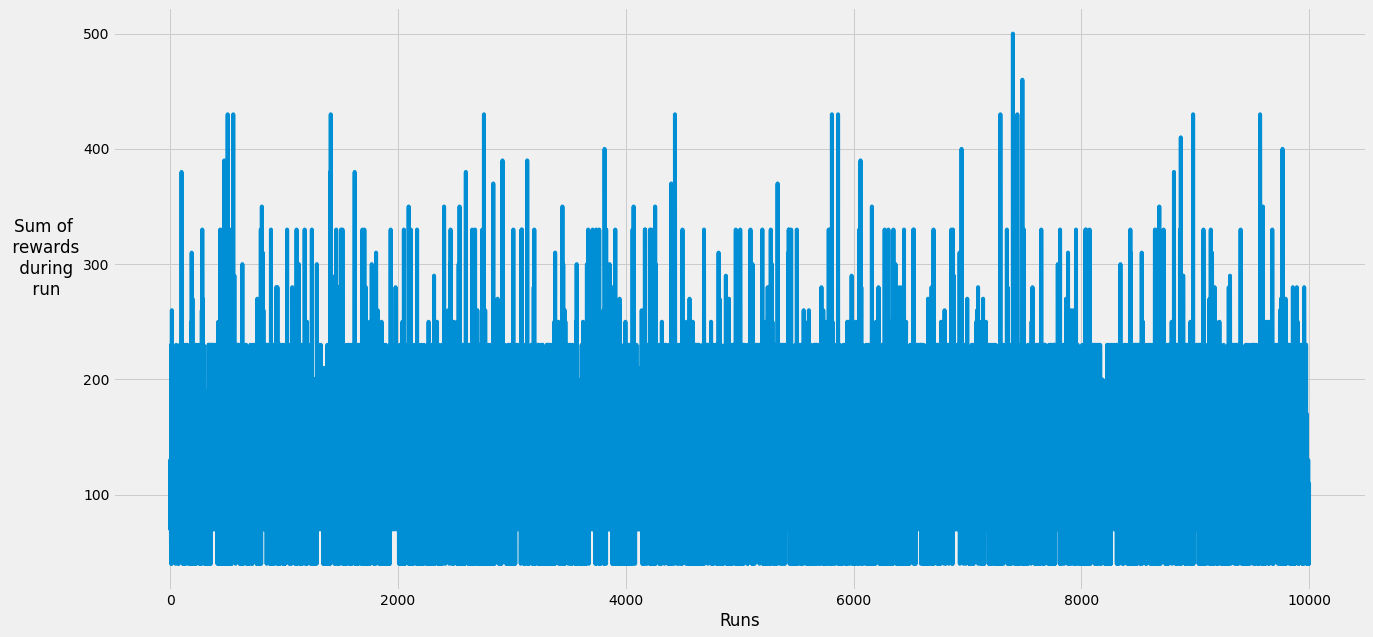

In [8]:
agent = ExpectedSarsaAgent()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

all_reward_sums = [] # Contains sum of rewards during episode
all_state_visits = [] # Contains state visit counts during the last 10 episodes
all_scores = [] # Contains the scores obtained for each run
agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay":.999, "step_size": 0.7, "step_size_decay": 0.9999, "discount": 1.0}
agent_info["seed"] = 0
agent.agent_init(agent_info)

env_info = {}
num_runs = 10000 # The number of runs
num_episodes = 5000 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(num_runs)):

    # Set the seed value to the current run index
    agent_info["seed"] = run

    # Initialize the environment
    state = env.reset()

    # Set done to False
    done = False

    reward_sums = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(num_episodes):
        if episode == 0:
      
            # Keep track of the visited states
            state = env.reset()
            action = agent.agent_start(state)

            state_visits[state] = 1
            state, reward, done, info = env.step(action)
            reward_sums.append(reward)

        else:
            while not done:
              action = agent.agent_step(reward, state)
              agent.epsilon = agent.epsilon * agent.eps_decay

              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1

              state, reward, done, info = env.step(action)
              reward_sums.append(reward)

              # If terminal state
              if done:
                action = agent.agent_end(reward)
                break

    all_reward_sums.append(np.sum(reward_sums))
    all_state_visits.append(state_visits)
    all_scores.append(info["score"])

# Plot the results
x = np.arange(num_runs)
plt.figure(figsize=(20, 10))
plt.plot(x, all_reward_sums)
plt.xlabel("Runs")
plt.ylabel("Sum of\n rewards\n during\n run",rotation=0, labelpad=40)
plt.show()

### Hyperparameter tuning

#### Step-Size

In [19]:
agent = ExpectedSarsaAgent()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["alpha = 0.3", "alpha = 0.4", "alpha = 0.5","alpha = 0.6", "alpha = 0.7","alpha = 0.8", "alpha = 0.9"]
step_sizes = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

every_scores = []
every_rewards = []

for step_size in tqdm(step_sizes):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.1, "eps_decay":1.0, "step_size": step_size, "step_size_decay": 1.0, "discount": 1.0}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)
                  agent.epsilon = agent.epsilon * agent.eps_decay

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)

100%|██████████| 7/7 [13:22<00:00, 114.69s/it]


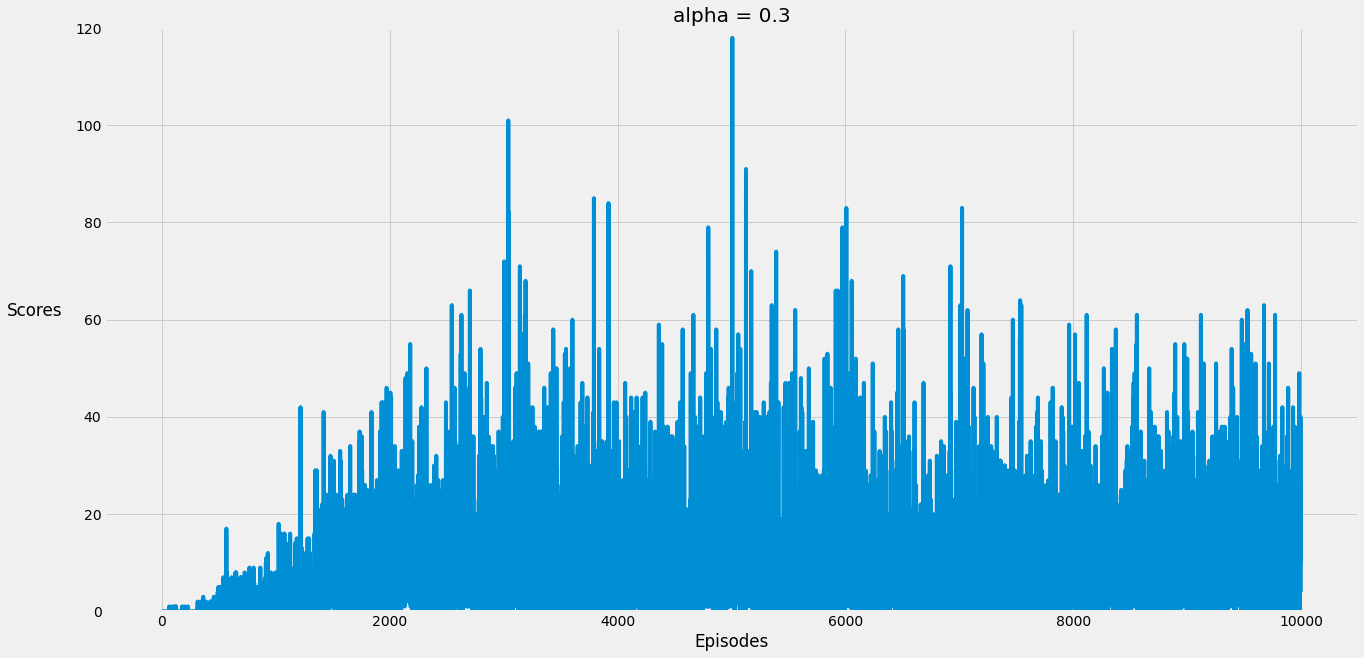

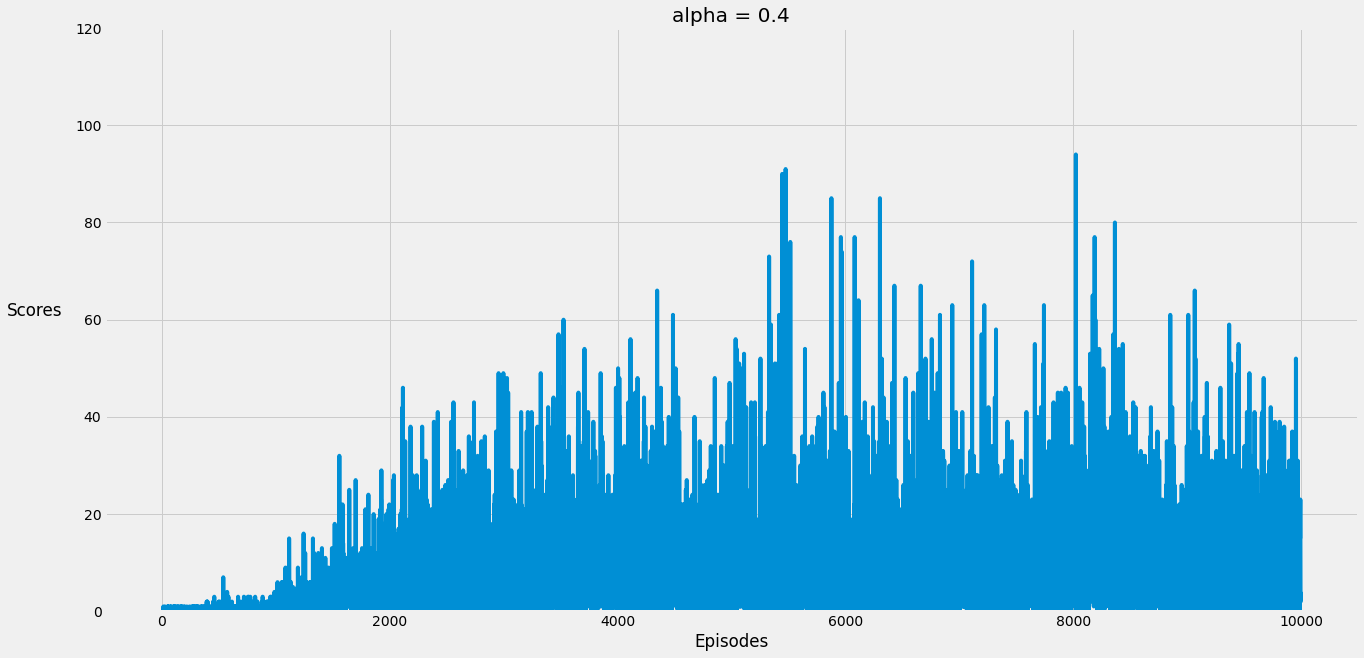

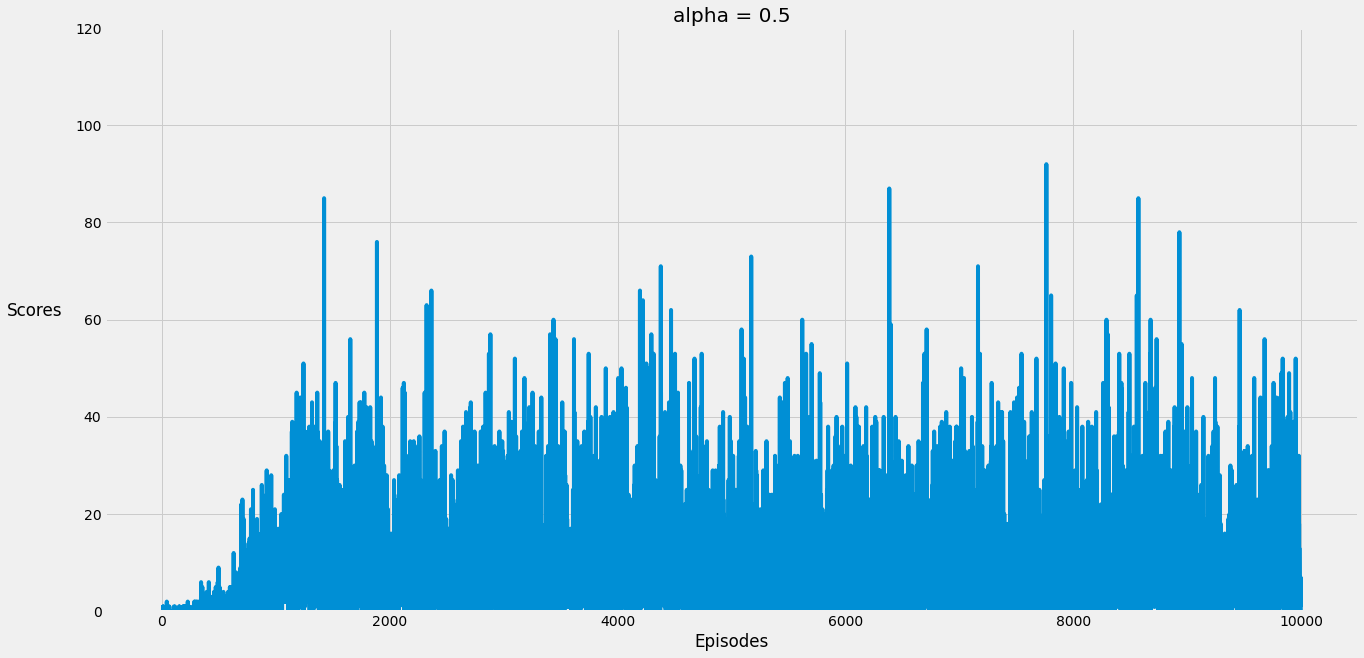

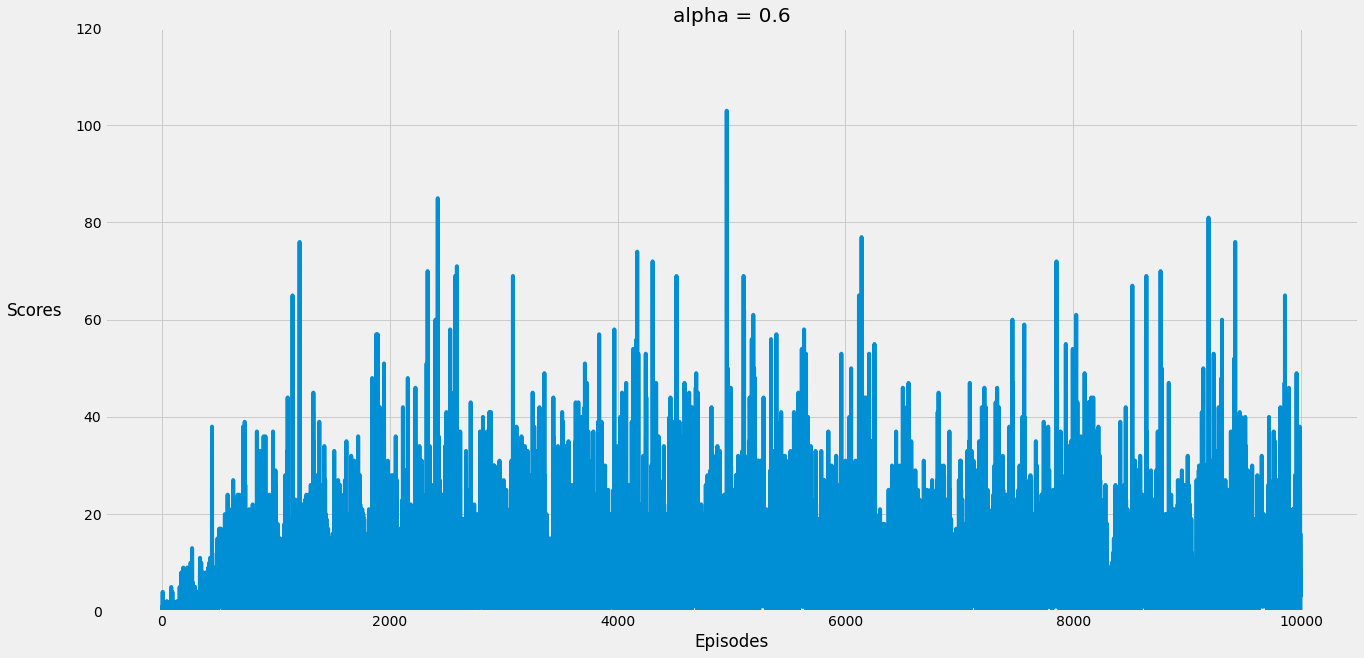

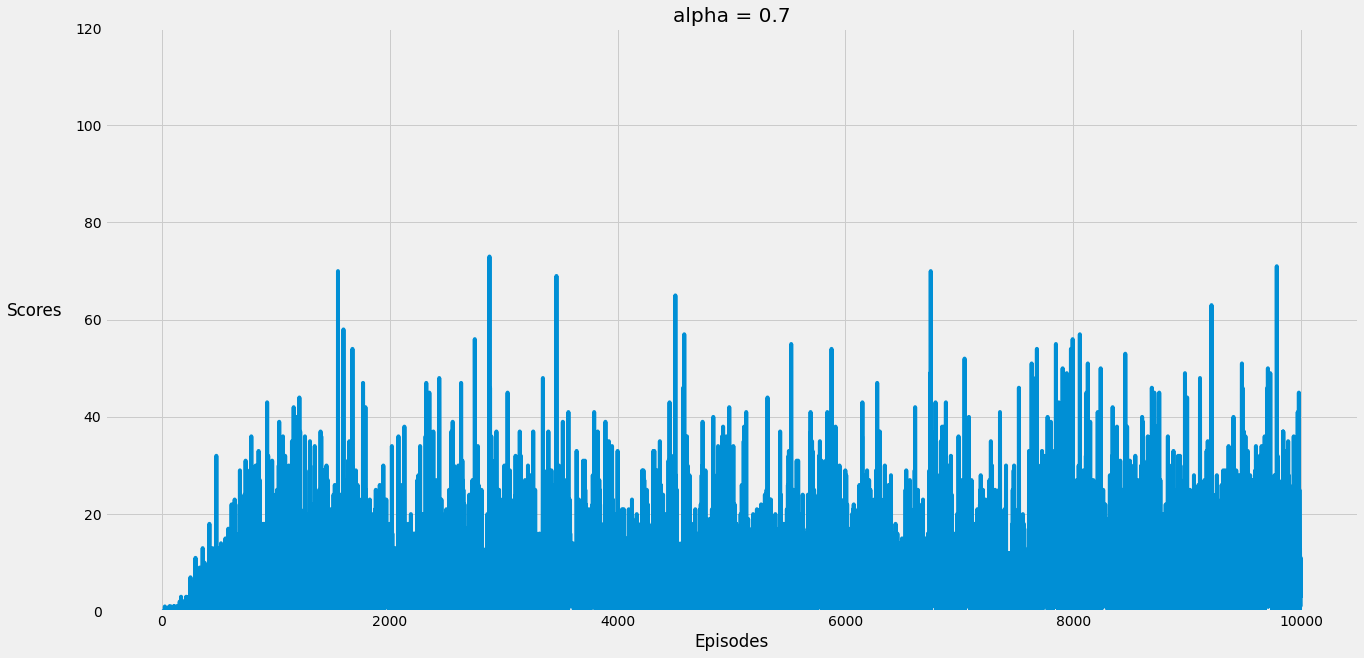

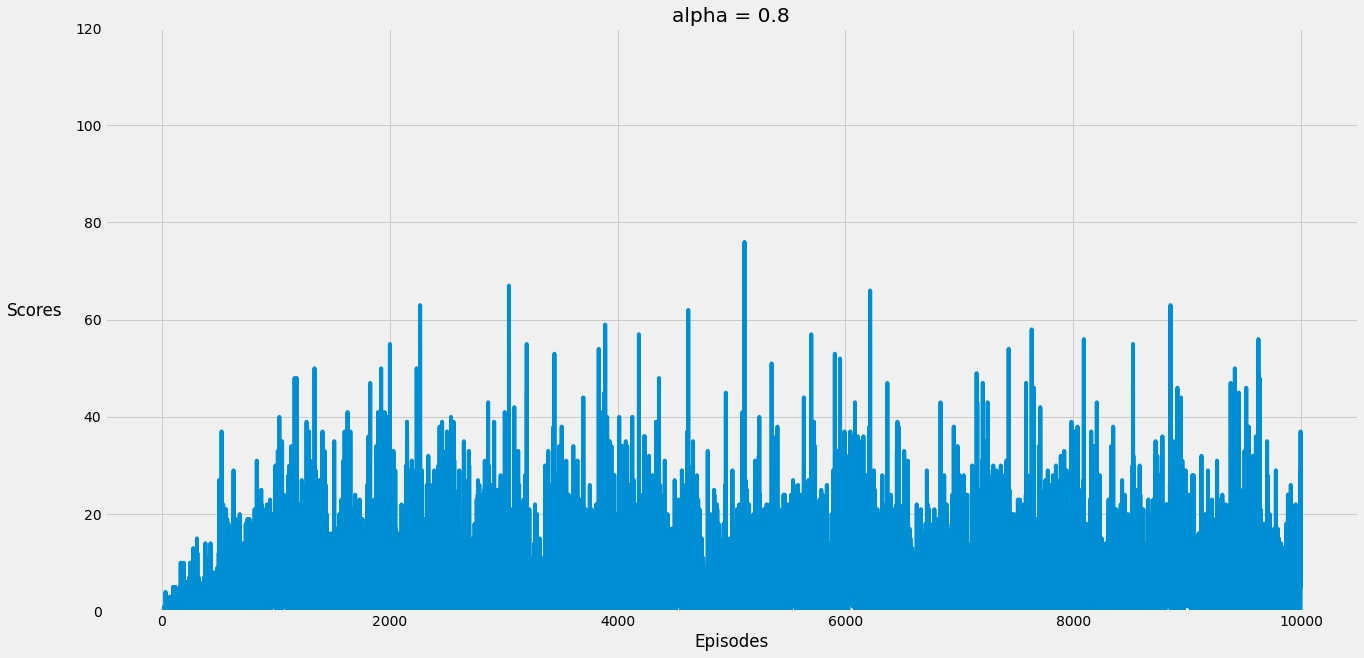

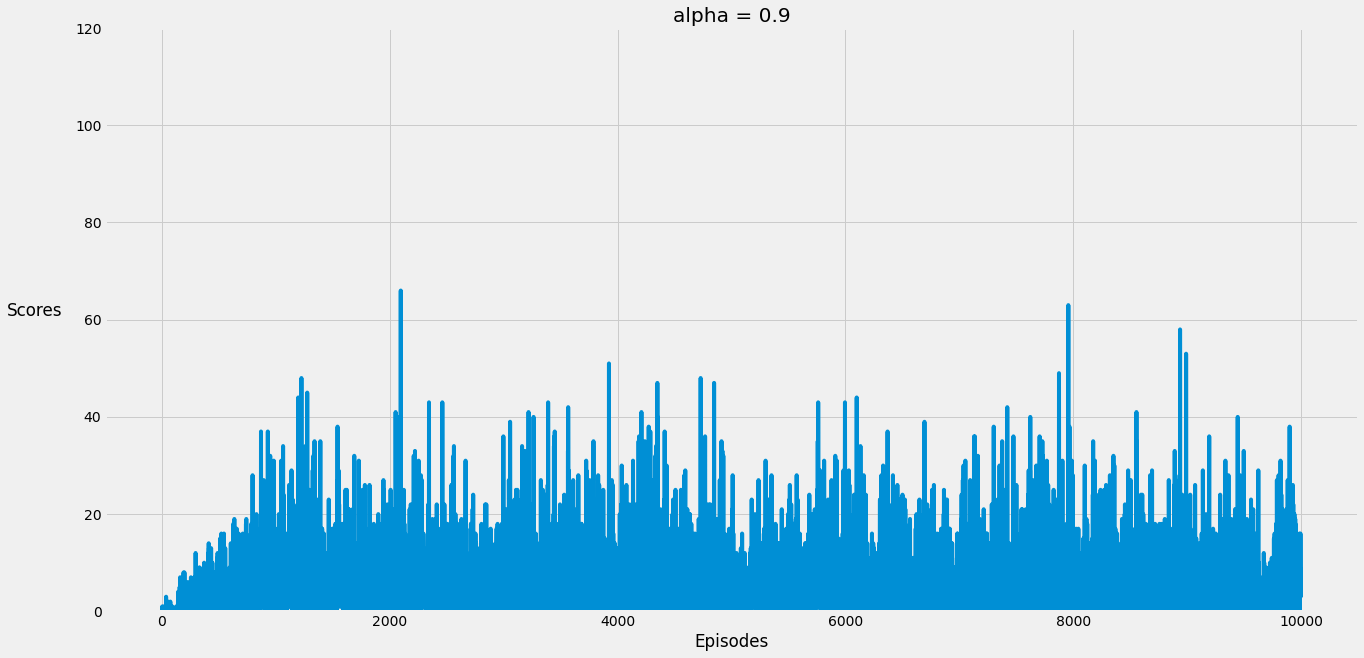

In [20]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 120)
  plt.title(labels[i])
  plt.show()

In [22]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


alpha = 0.3
Mean:  9.2936
Median:  6.0
Max:  118
--------------------
alpha = 0.4
Mean:  8.2513
Median:  5.0
Max:  94
--------------------
alpha = 0.5
Mean:  8.8104
Median:  5.0
Max:  92
--------------------
alpha = 0.6
Mean:  8.3842
Median:  5.0
Max:  103
--------------------
alpha = 0.7
Mean:  7.496
Median:  5.0
Max:  73
--------------------
alpha = 0.8
Mean:  6.8471
Median:  4.0
Max:  76
--------------------
alpha = 0.9
Mean:  5.8495
Median:  4.0
Max:  66
--------------------


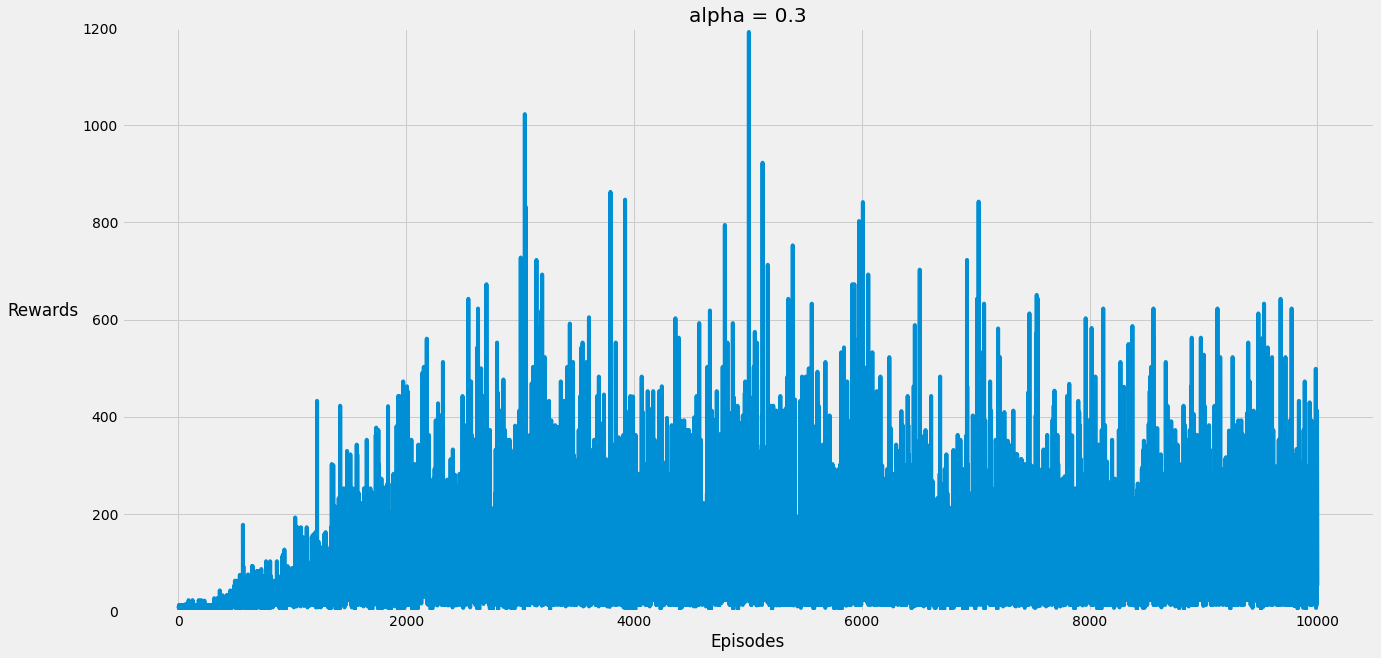

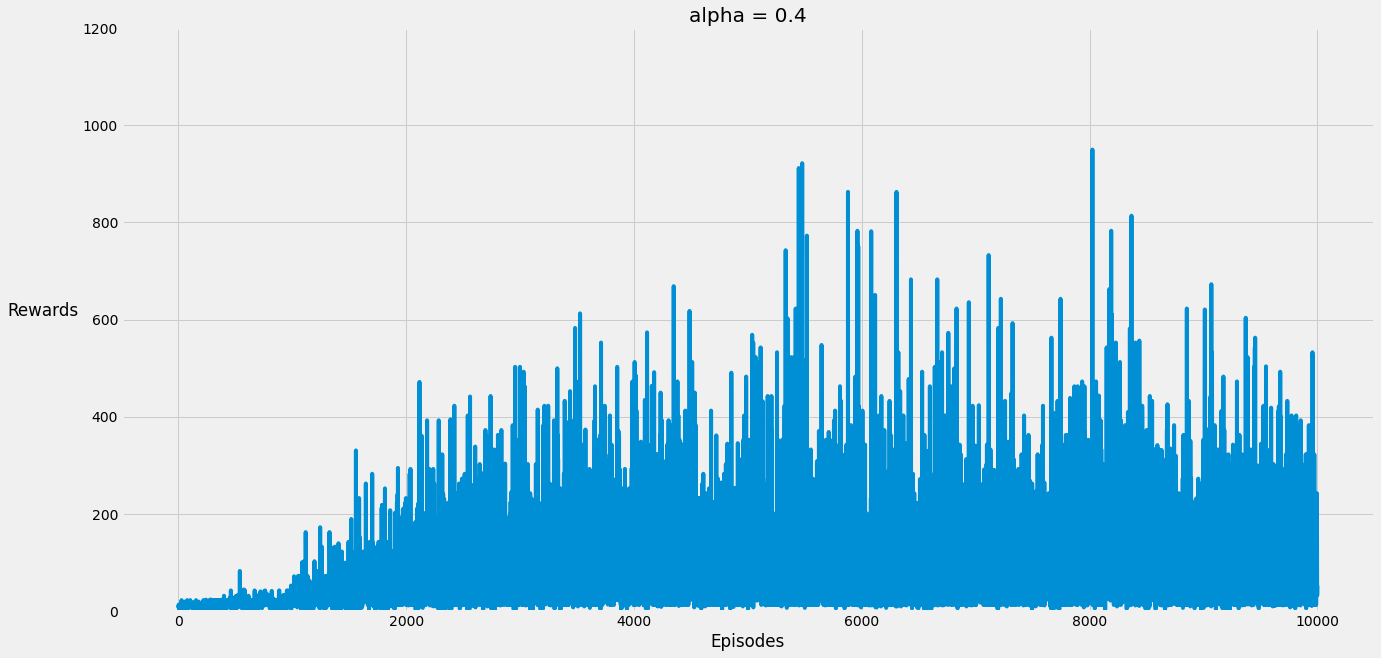

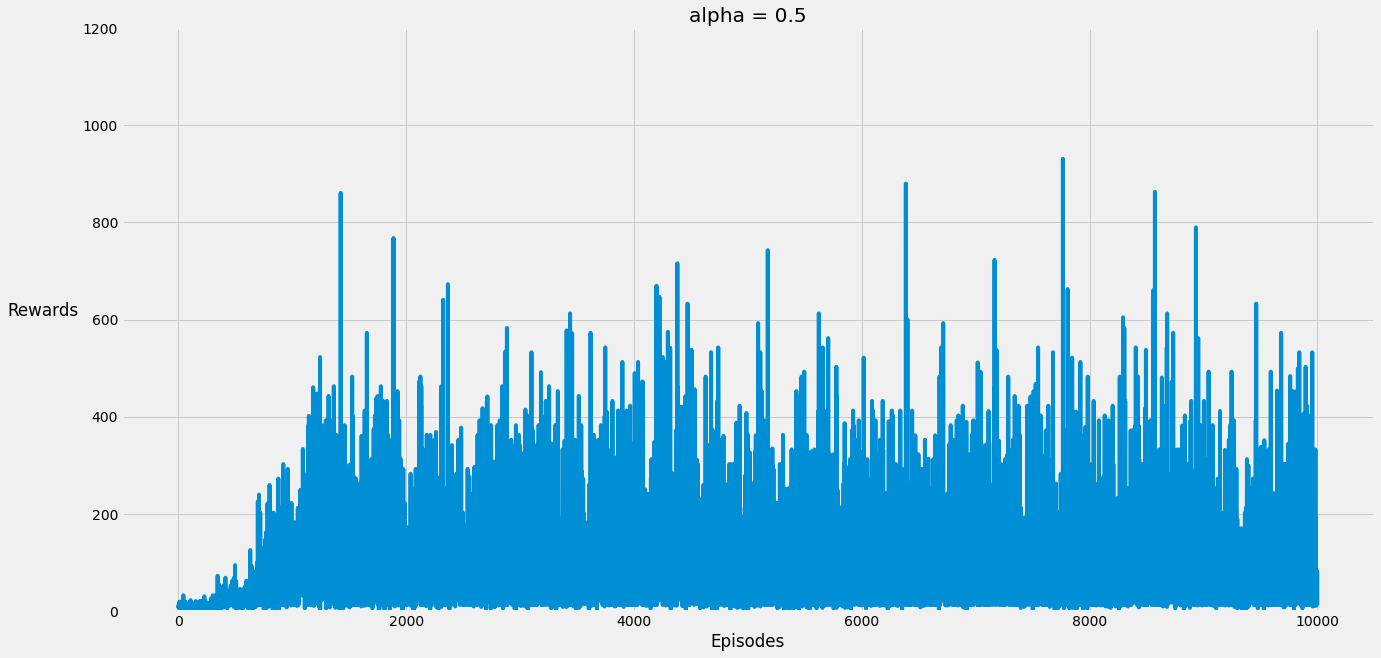

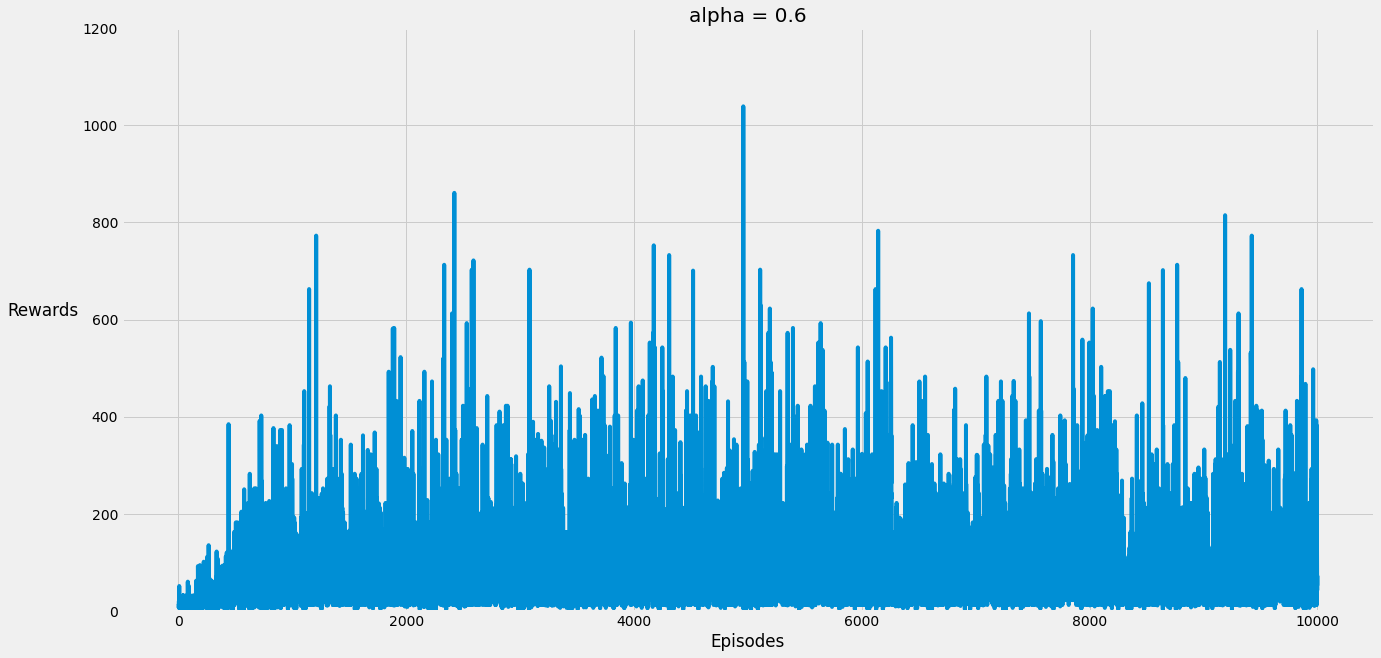

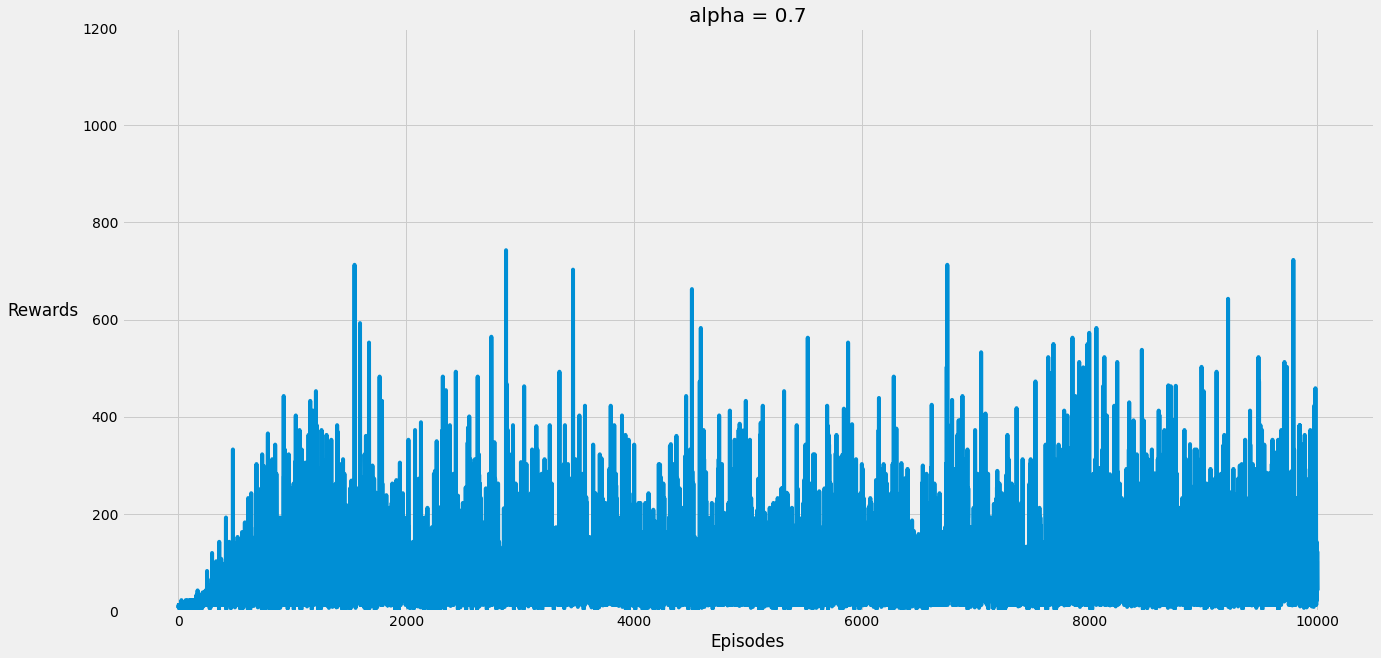

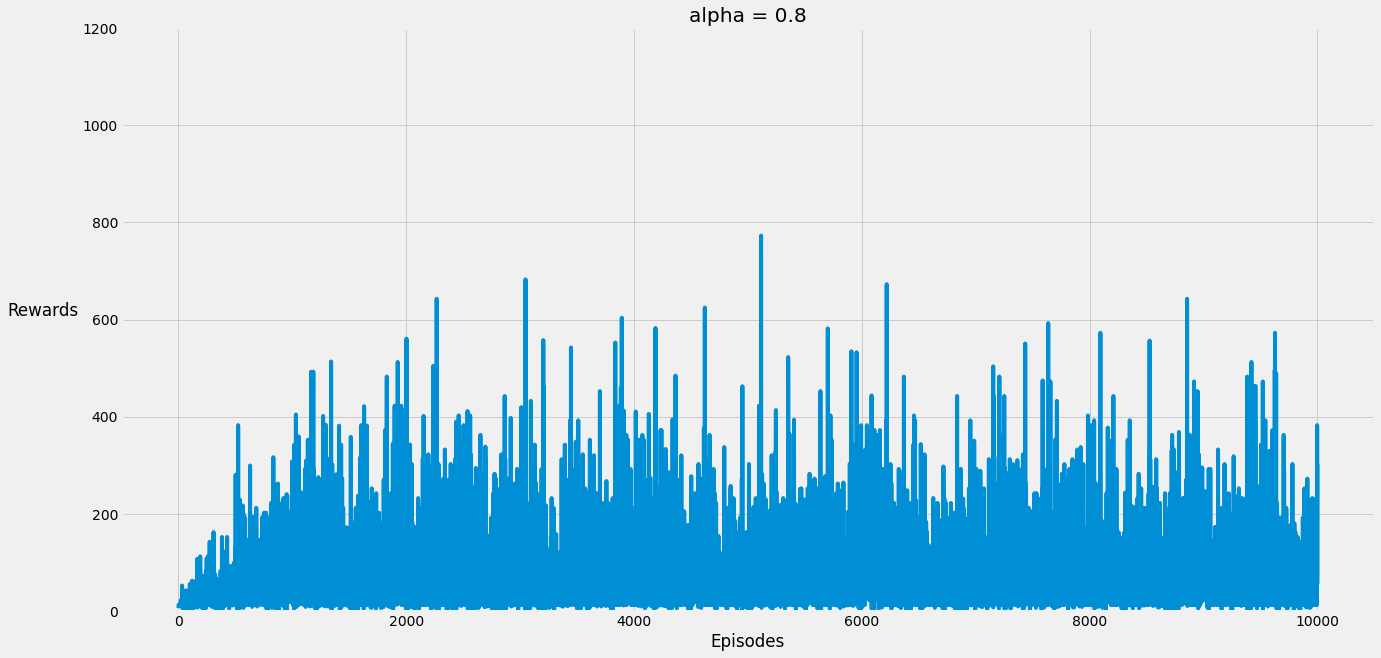

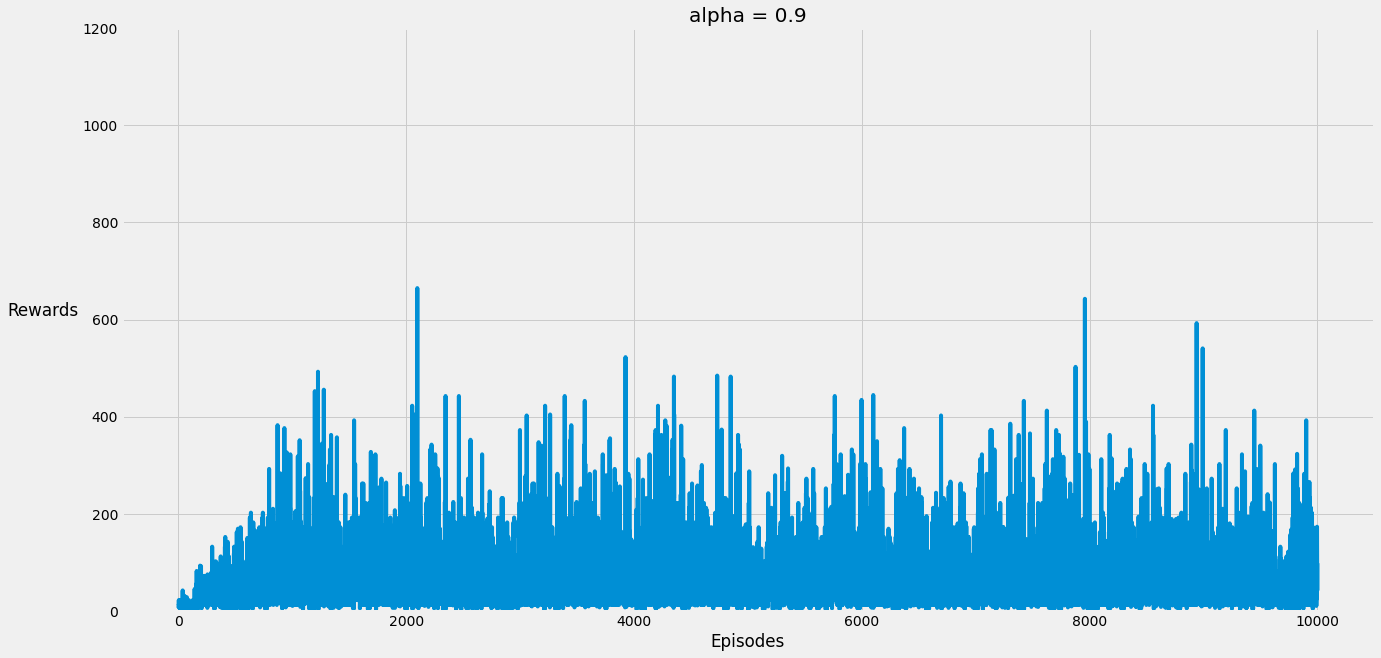

In [21]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.ylim(0, 1200)
  plt.title(labels[i])
  plt.show()

In [23]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


alpha = 0.3
Mean:  104.7762
Median:  72.0
Max:  1192
--------------------
alpha = 0.4
Mean:  94.4778
Median:  63.0
Max:  950
--------------------
alpha = 0.5
Mean:  99.8604
Median:  64.0
Max:  931
--------------------
alpha = 0.6
Mean:  95.6449
Median:  63.0
Max:  1039
--------------------
alpha = 0.7
Mean:  86.6657
Median:  63.0
Max:  743
--------------------
alpha = 0.8
Mean:  80.109
Median:  53.0
Max:  773
--------------------
alpha = 0.9
Mean:  69.9912
Median:  50.0
Max:  665
--------------------


Please see the results of the hyperparameter tuning of the step-size α after 10,000 runs of 500 episodes:


| Step-size α| Mean | Median | Max |
|------|------|------|------|
|   0.3 | 104.77 | 72 | 1,192 |
|   0.4 | 94.47 | 63 | 950 |
|   0.5 | 99.86 | 64 | 931 |
|   0.6 | 95.64 | 63 | 1,039 |
|   0.7 | 86.66 | 63 | 743 |
|   0.8 | 80.10 | 53 | 773 |
|   0.9 | 69.99 | 50 | 665 |

Based on the median and average rewards, the step-size to use to optimise the agent is α=0.4.


#### Epsilon

In [ ]:
agent = ExpectedSarsaAgent()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["epsilon = 0.05", "epsilon = 0.1","epsilon = 0.15", "epsilon = 0.2","epsilon = 0.25", "epsilon = 0.3"]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

every_scores = []
every_rewards = []

for epsilon in tqdm(epsilons):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": epsilon, "eps_decay":1.0, "step_size": 0.4, "step_size_decay": 1.0, "discount": 1.0}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 10000 # The number of runs
    num_episodes = 500 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)
                  agent.epsilon = agent.epsilon * agent.eps_decay

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)



100%|██████████| 6/6 [09:34<00:00, 95.81s/it]


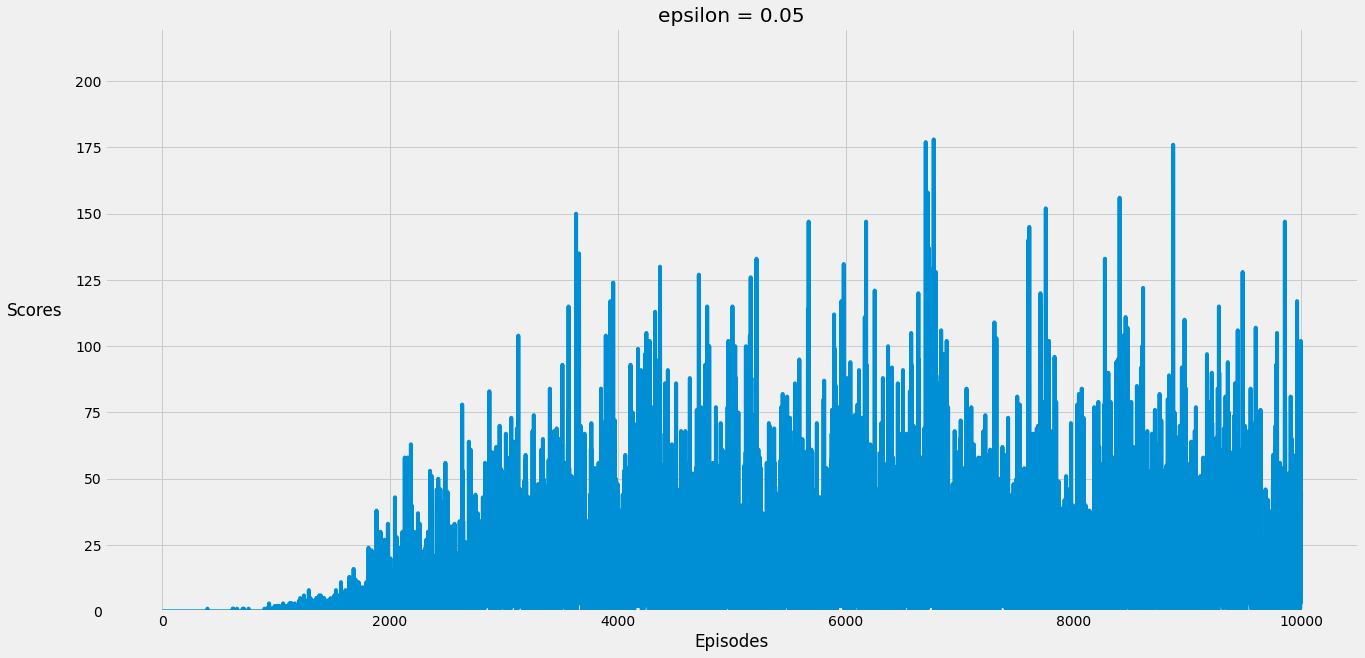

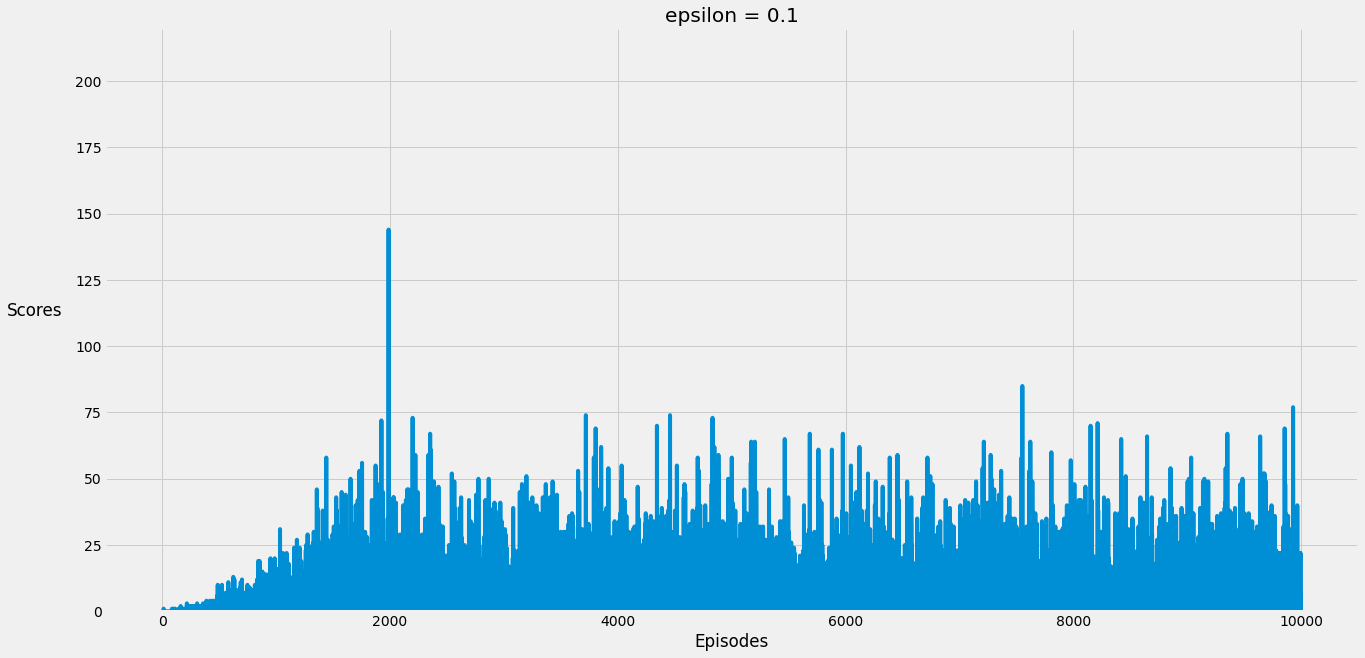

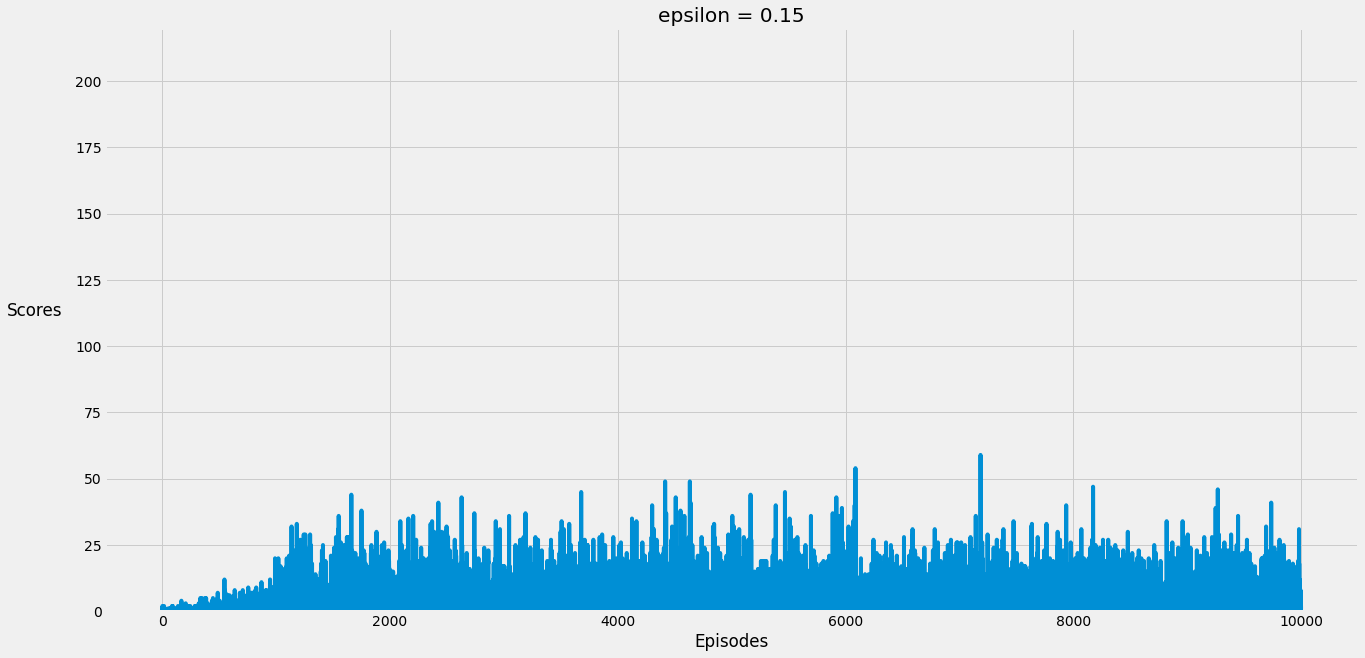

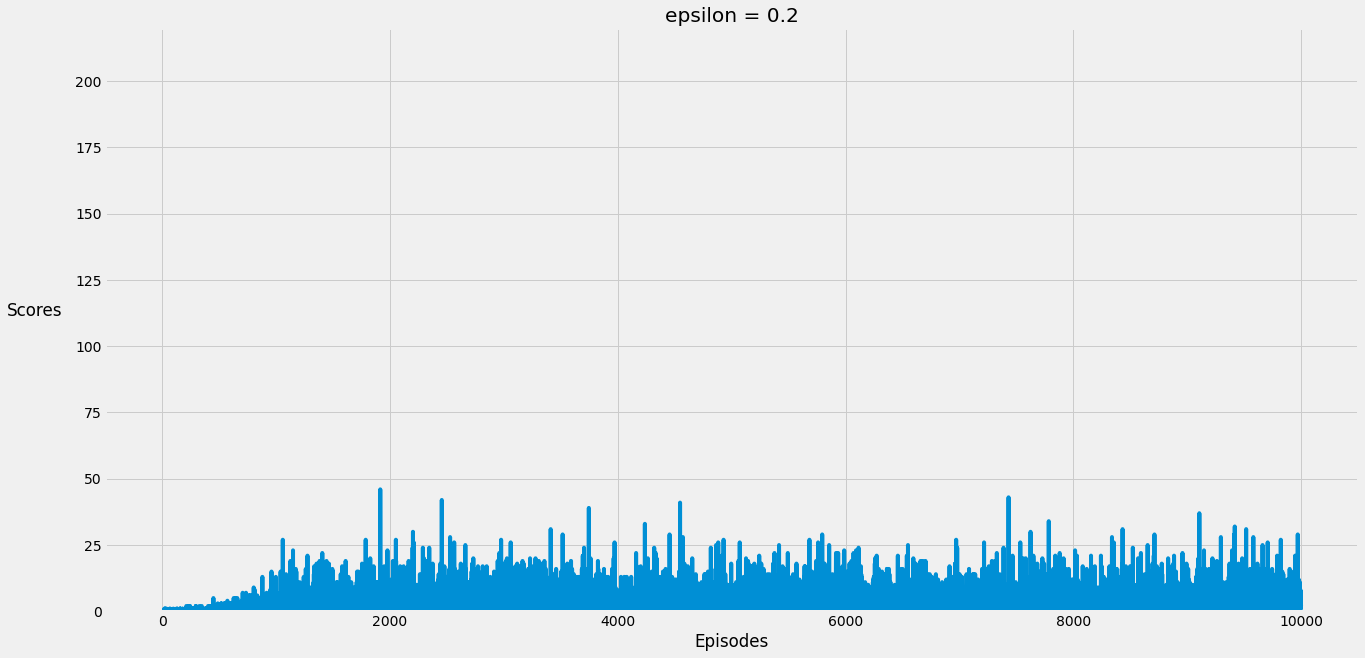

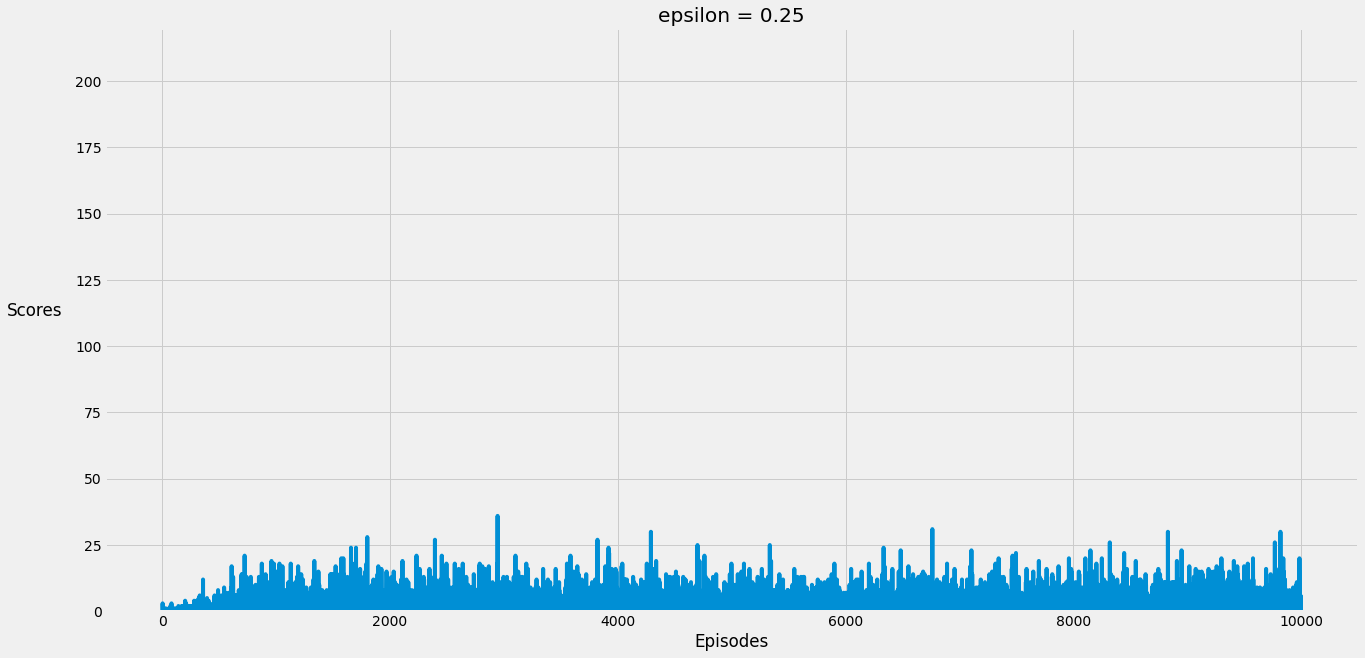

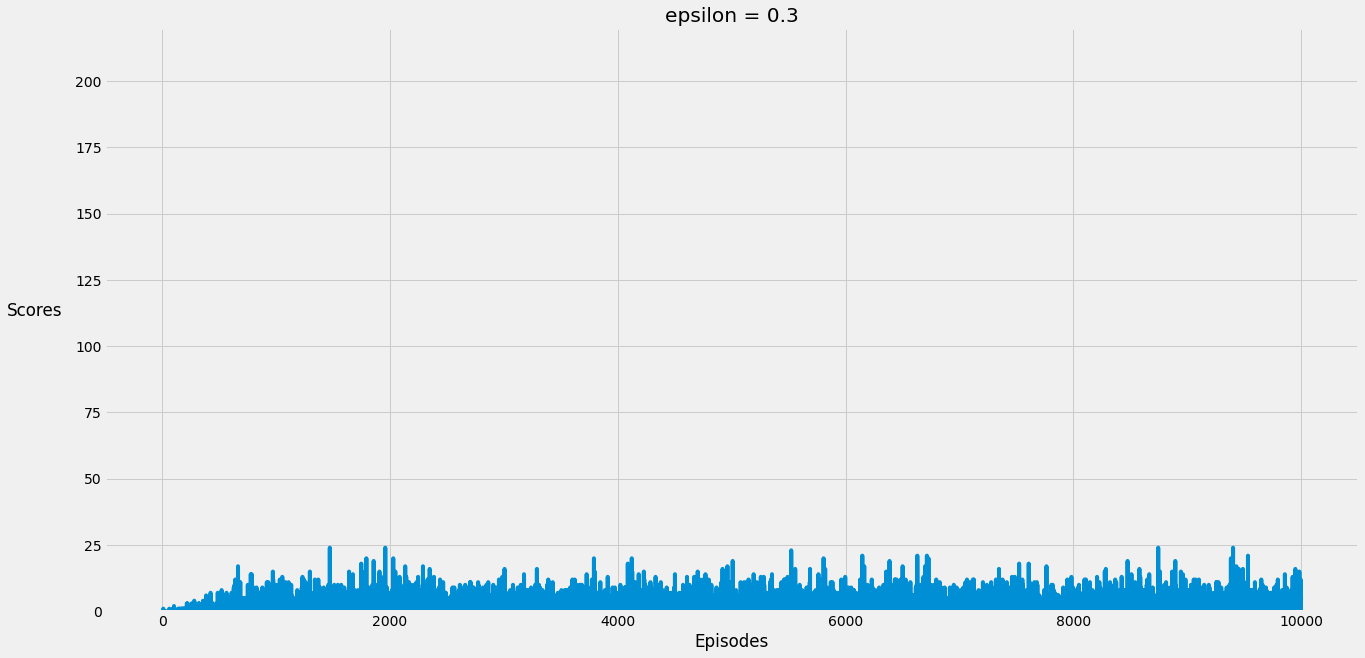

In [ ]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 220)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


epsilon = 0.05
Mean:  15.4621
Median:  8.0
Max:  178
--------------------
epsilon = 0.1
Mean:  9.0486
Median:  6.0
Max:  144
--------------------
epsilon = 0.15
Mean:  5.7503
Median:  4.0
Max:  59
--------------------
epsilon = 0.2
Mean:  3.9421
Median:  2.0
Max:  46
--------------------
epsilon = 0.25
Mean:  3.0869
Median:  2.0
Max:  36
--------------------
epsilon = 0.3
Mean:  2.4511
Median:  2.0
Max:  24
--------------------


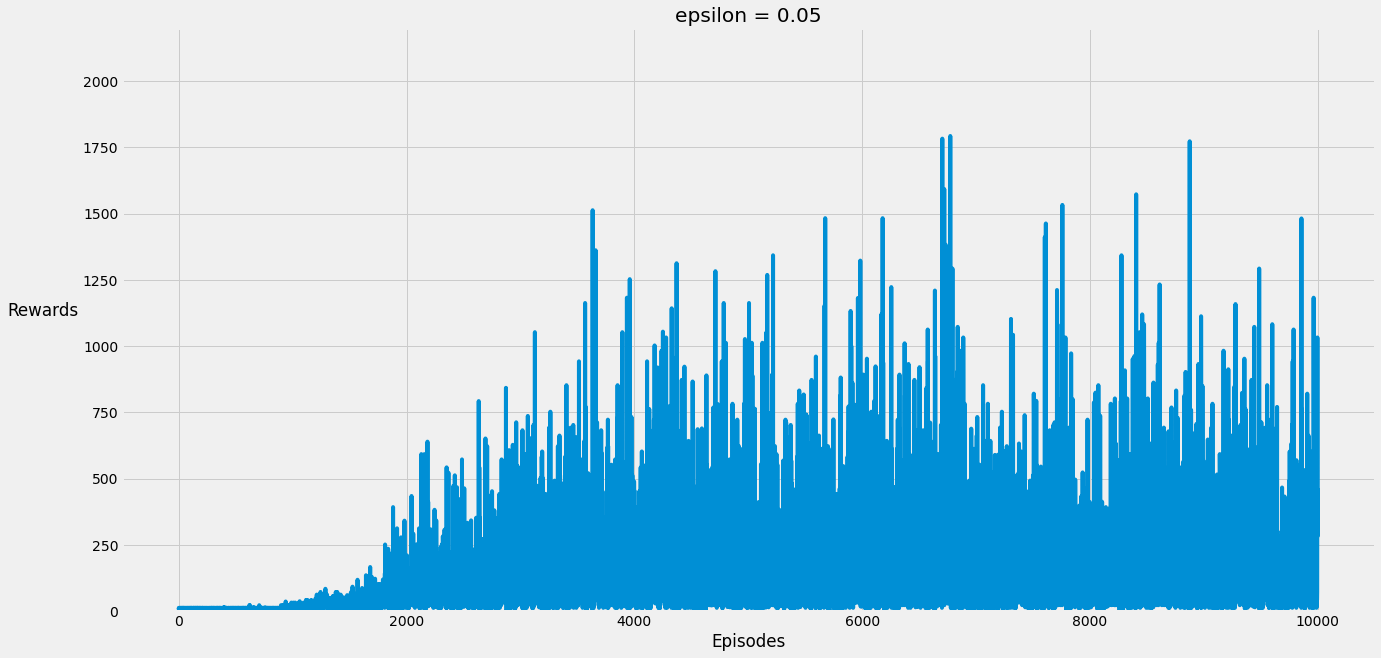

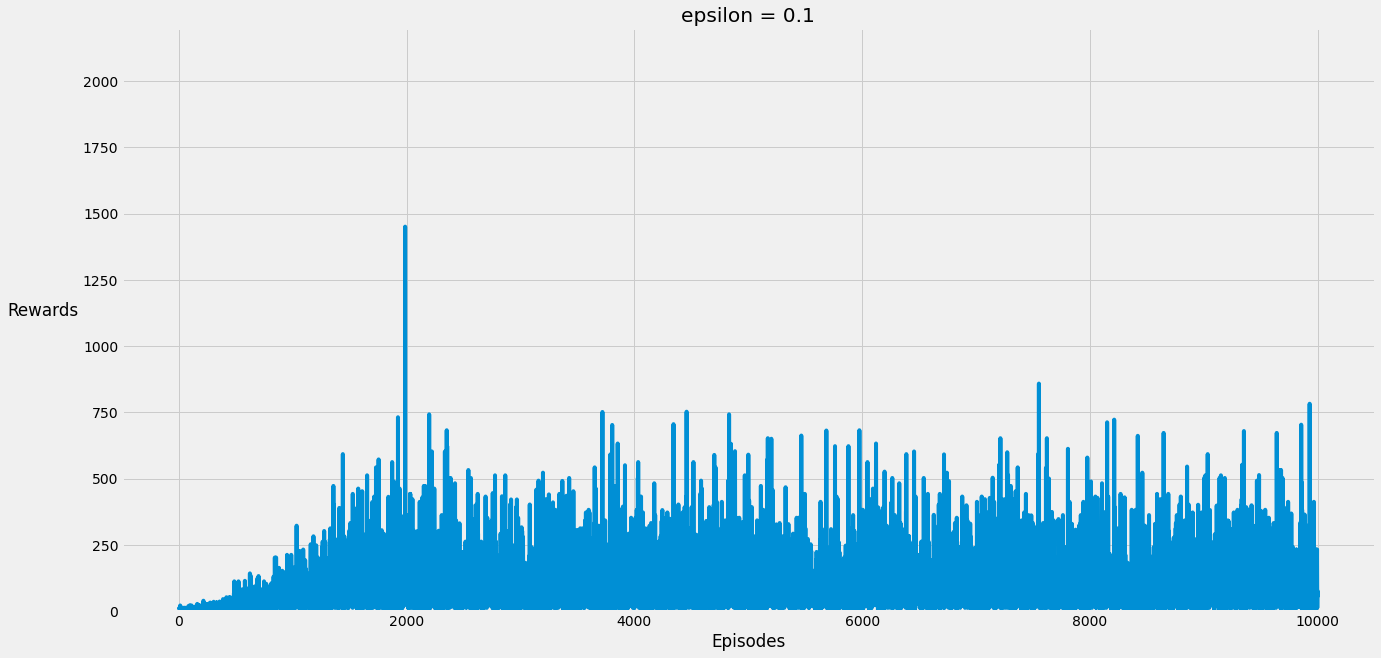

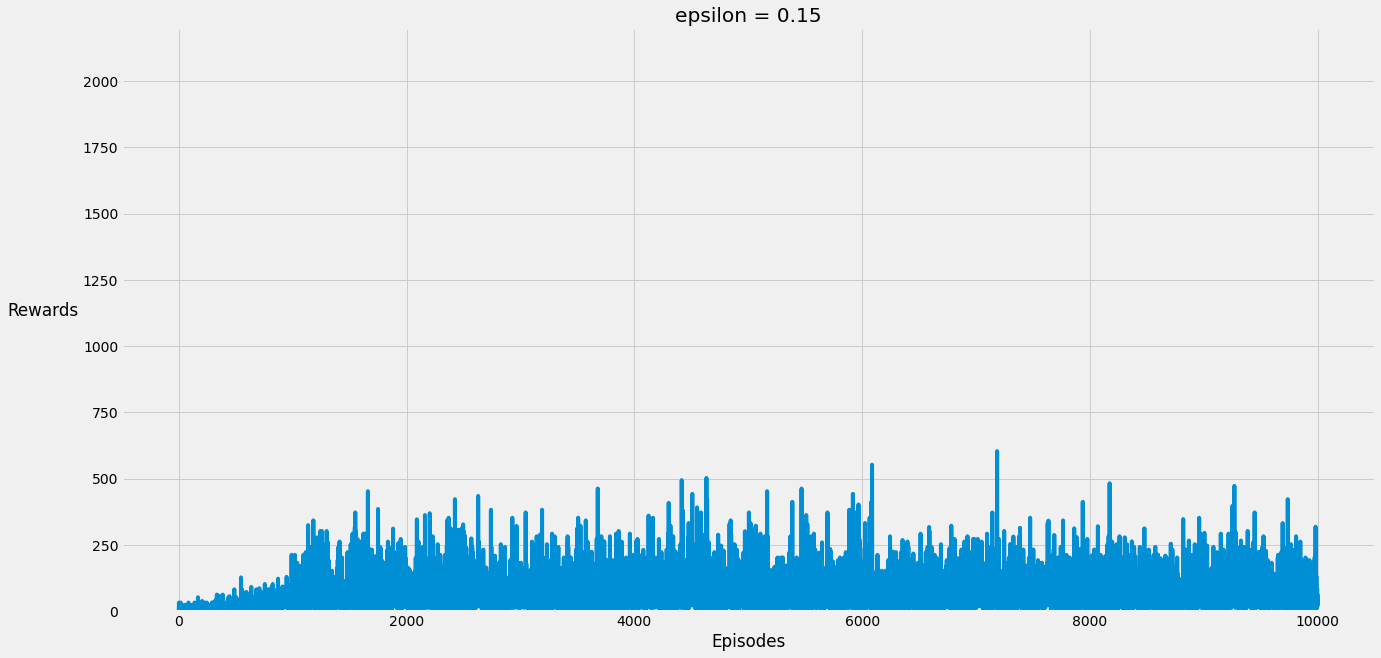

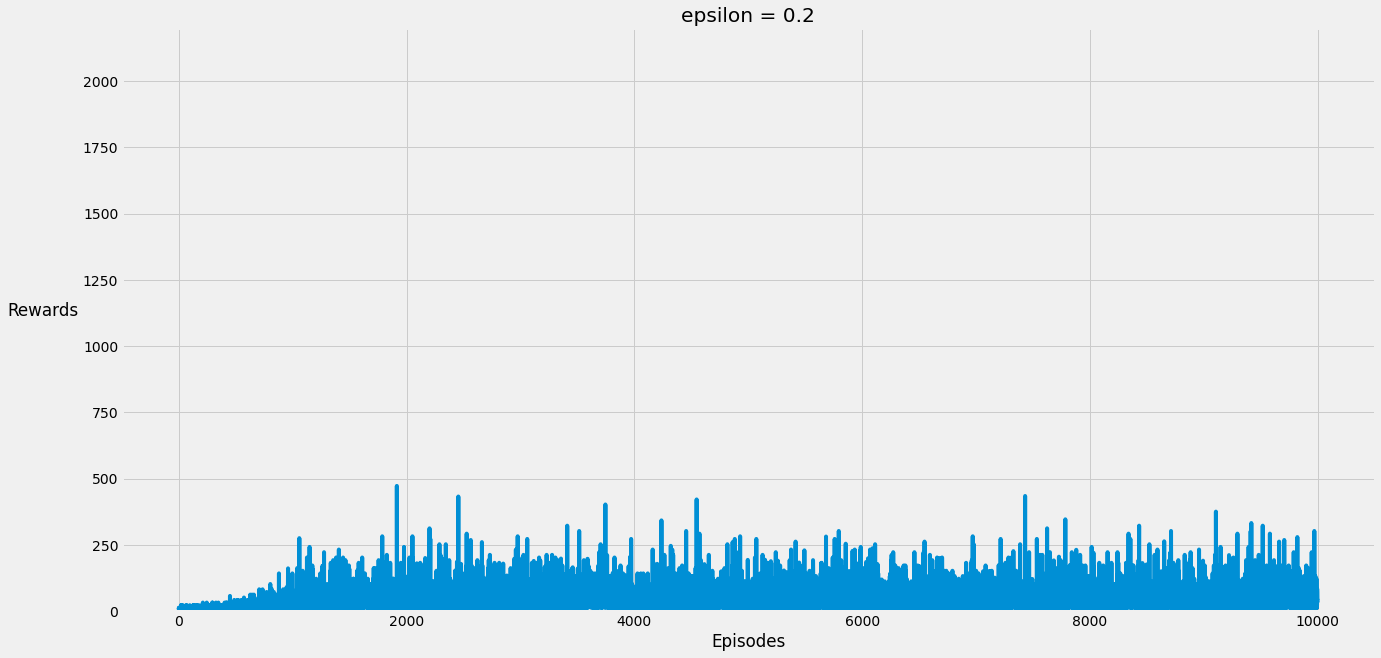

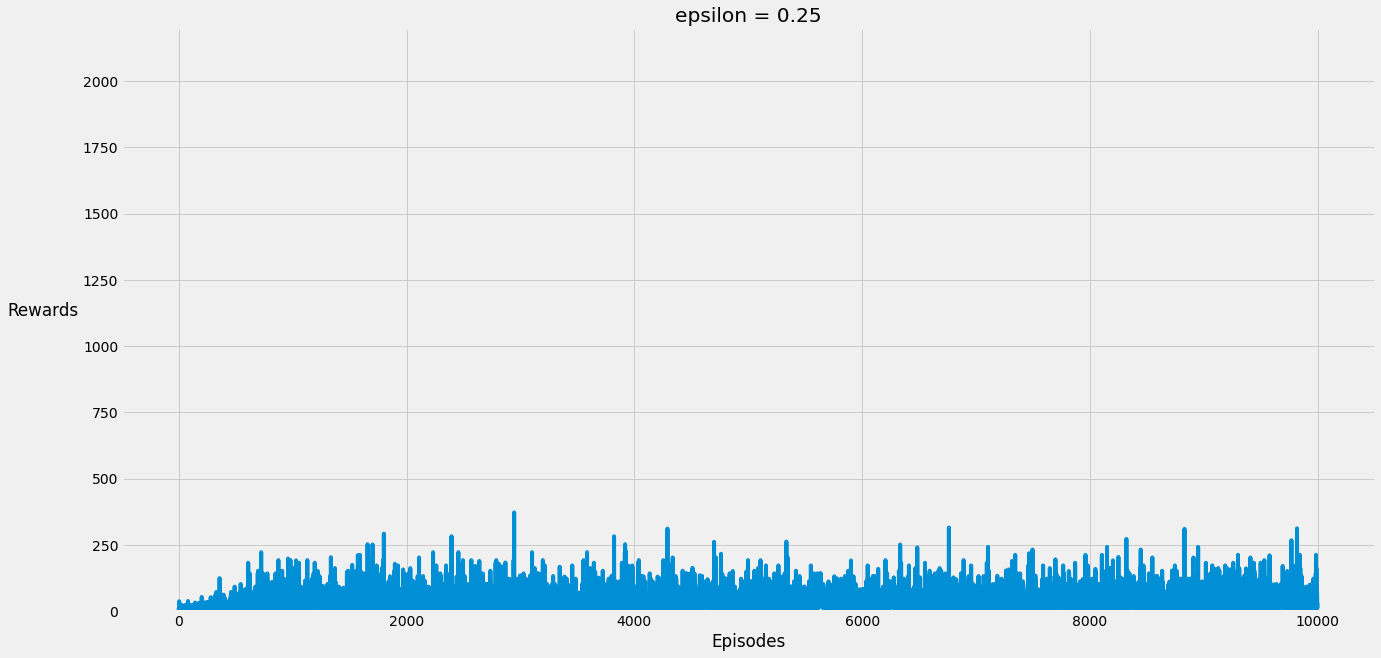

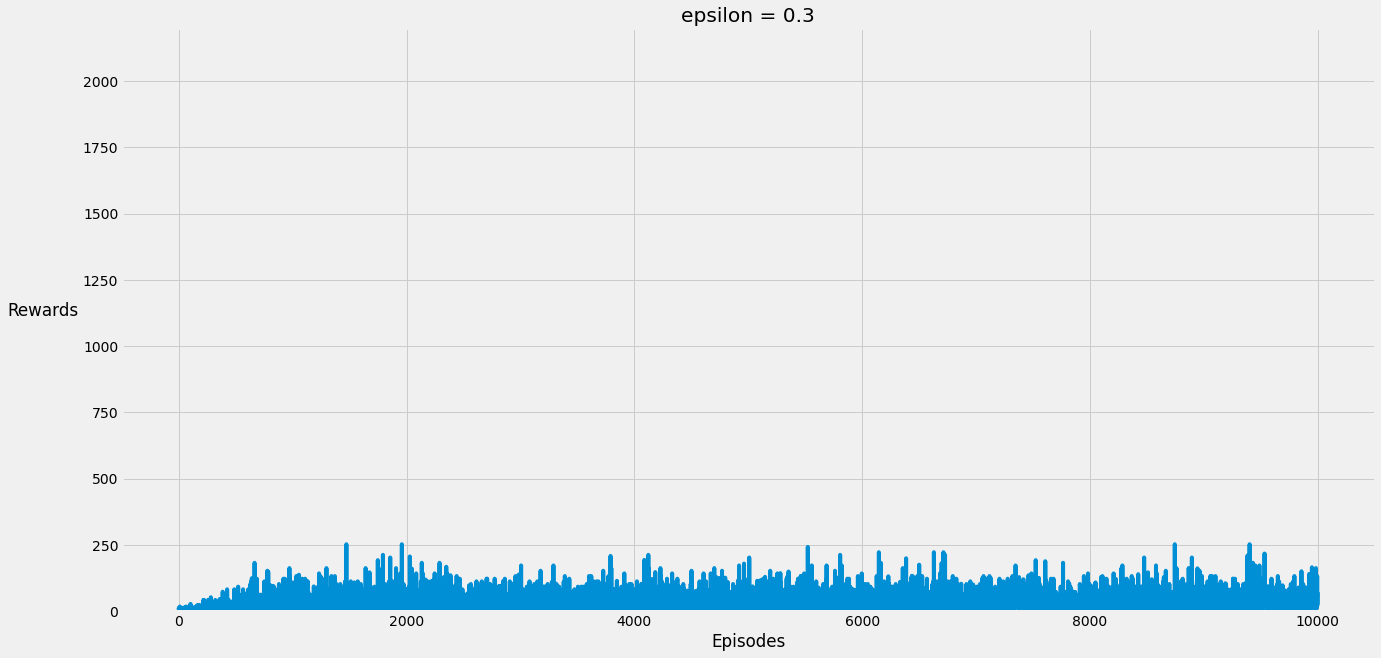

In [ ]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.ylim(0, 2200)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


epsilon = 0.05
Mean:  168.6876
Median:  103.0
Max:  2343
--------------------
epsilon = 0.1
Mean:  103.2619
Median:  72.0
Max:  1063
--------------------
epsilon = 0.15
Mean:  70.2237
Median:  52.0
Max:  753
--------------------
epsilon = 0.2
Mean:  52.7196
Median:  36.0
Max:  463
--------------------
epsilon = 0.25
Mean:  42.8616
Median:  33.0
Max:  333
--------------------
epsilon = 0.3
Mean:  36.7558
Median:  25.0
Max:  313
--------------------


Please see the results of the hyperparameter tuning of epsilon ϵ after 10,000 runs of 500 episodes:


| Epsilon ϵ| Mean | Median | Max |
|------|------|------|------|
|   0.05 | 168.69 | 103 | 2,343 |
|   0.1 | 103.27 | 72 | 1,063 |
|   0.15 | 70.22 | 52 | 753 |
|   0.2 | 52.72 | 36 | 463 |
|   0.25 | 42.86 | 33 | 333 |
|   0.3 | 36.76 | 25 | 313 |

Based on the median and average scores, the epsilon value to use to optimise the agent is ϵ=0.05. Therefore, the agent will almost behave in the greedy way.


#### Discount

In [ ]:
agent = ExpectedSarsaAgent()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]
discounts = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]

every_scores = []
every_rewards = []

for discount in tqdm(discounts):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay":1.0, "step_size": 0.4, "step_size_decay": 1.0, "discount": discount}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 20000 # The number of runs
    num_episodes = 1000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)
                  agent.epsilon = agent.epsilon * agent.eps_decay

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)
                    break

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)



100%|██████████| 7/7 [55:15<00:00, 473.64s/it]


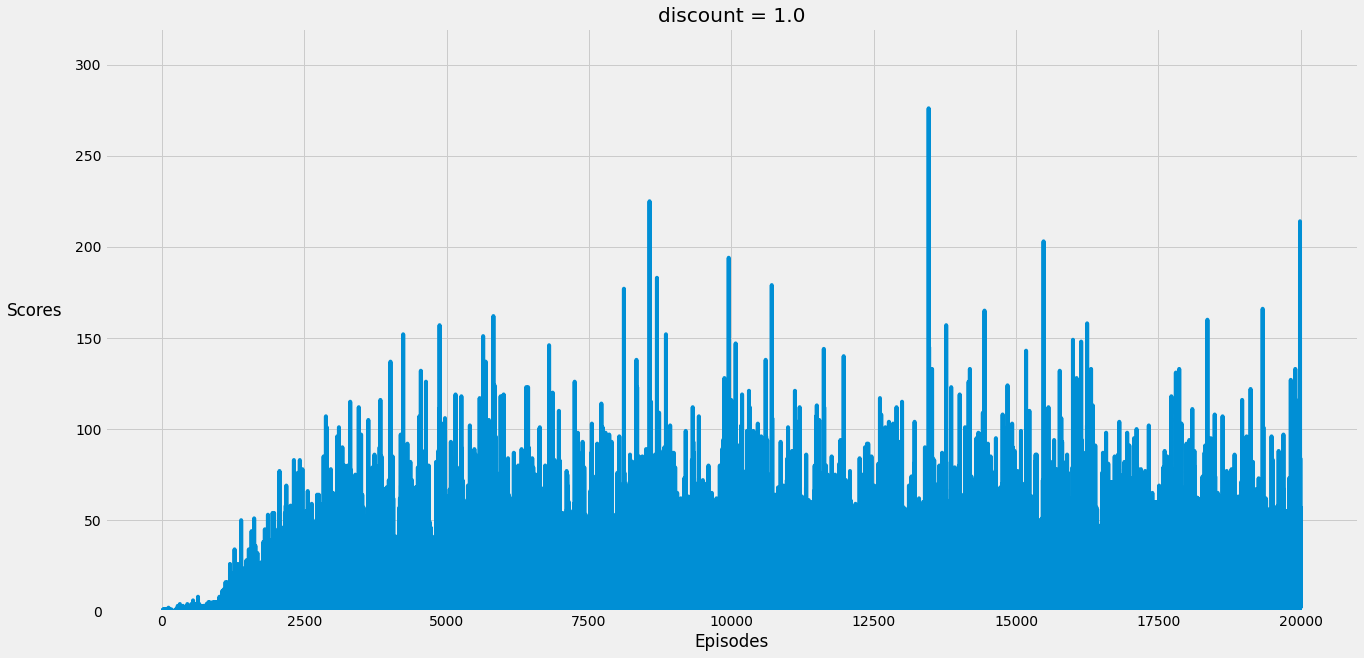

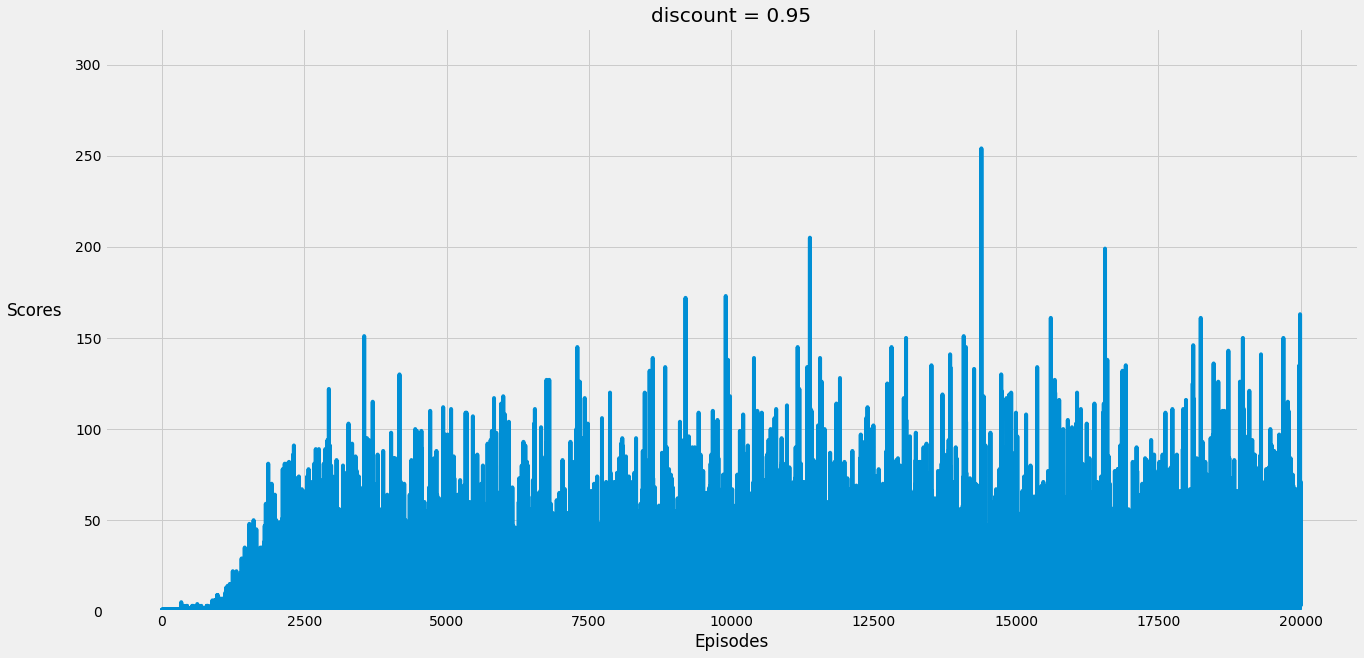

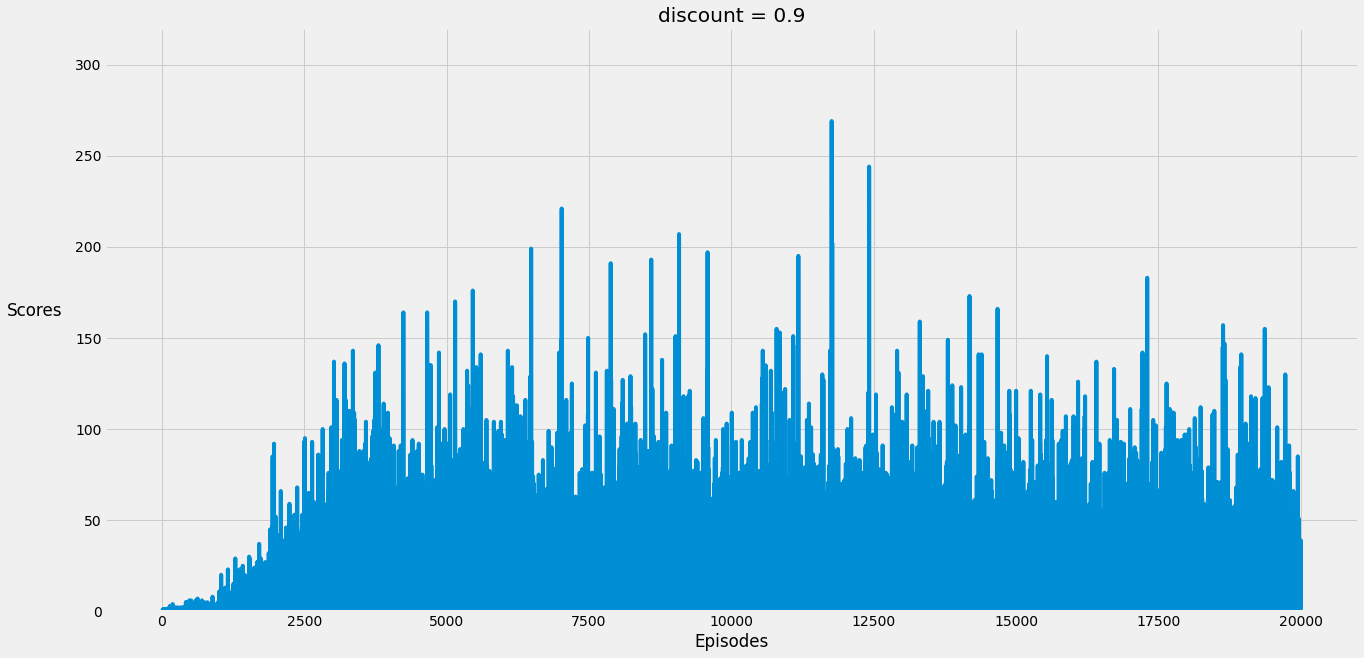

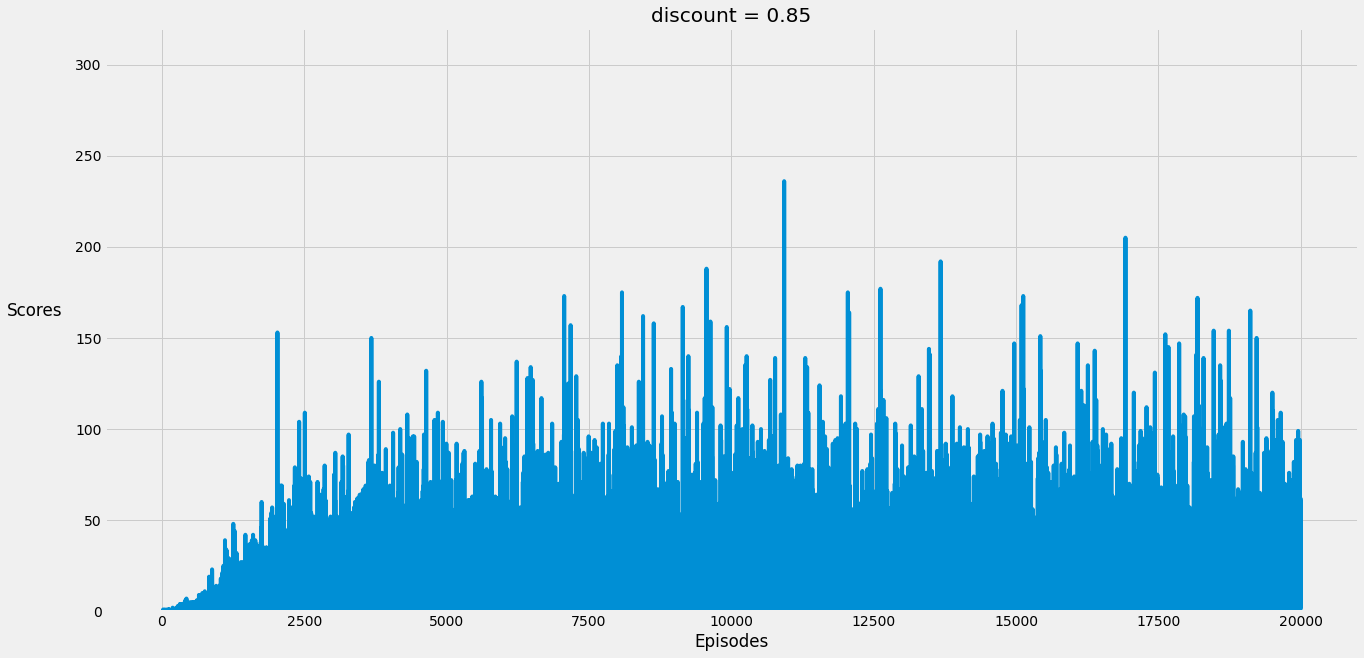

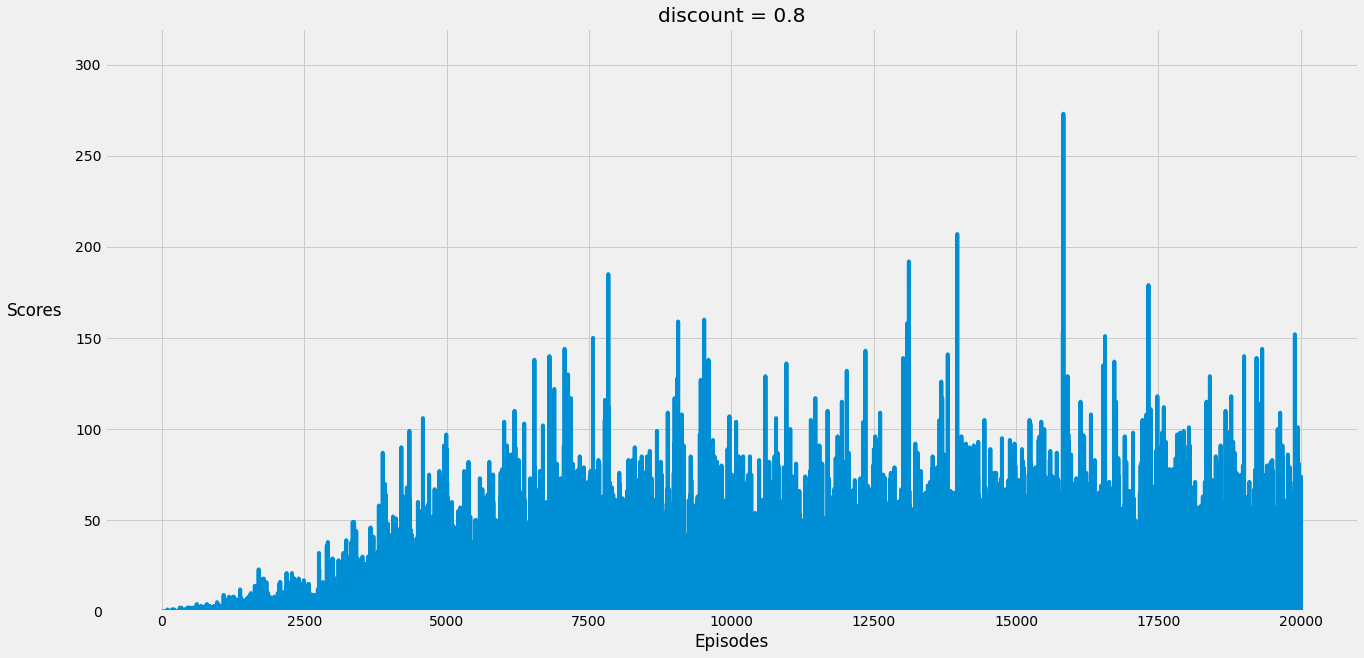

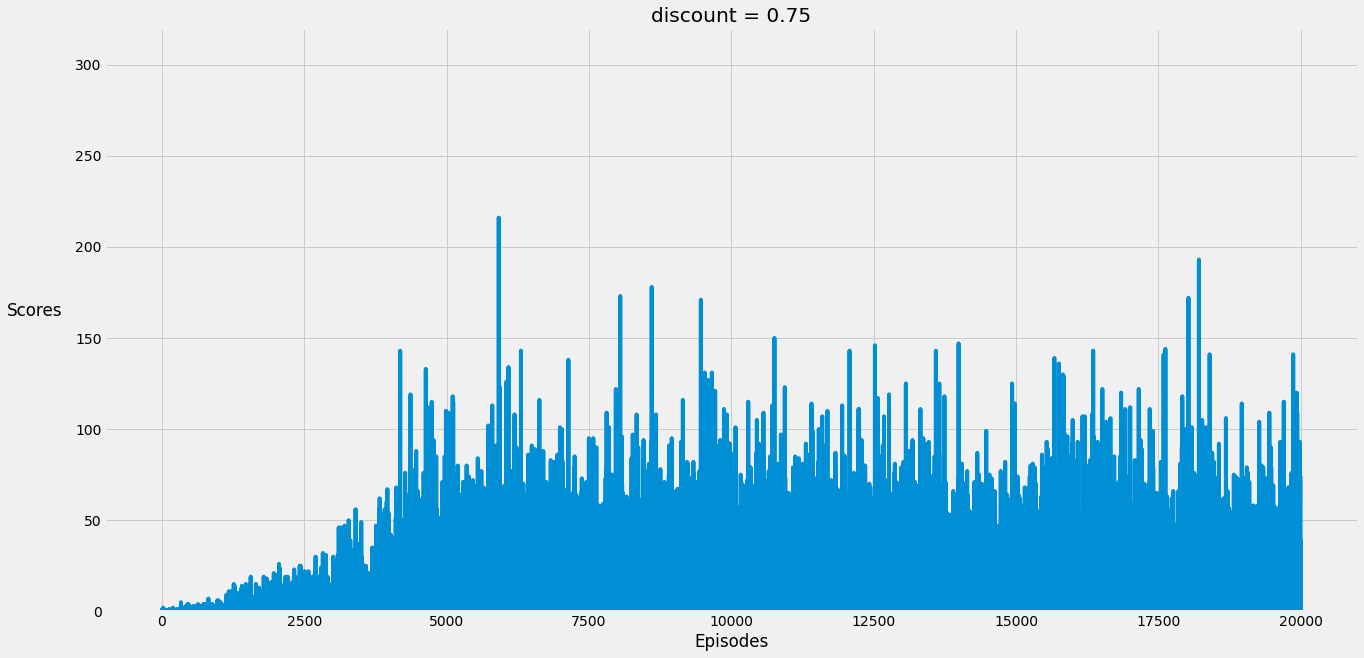

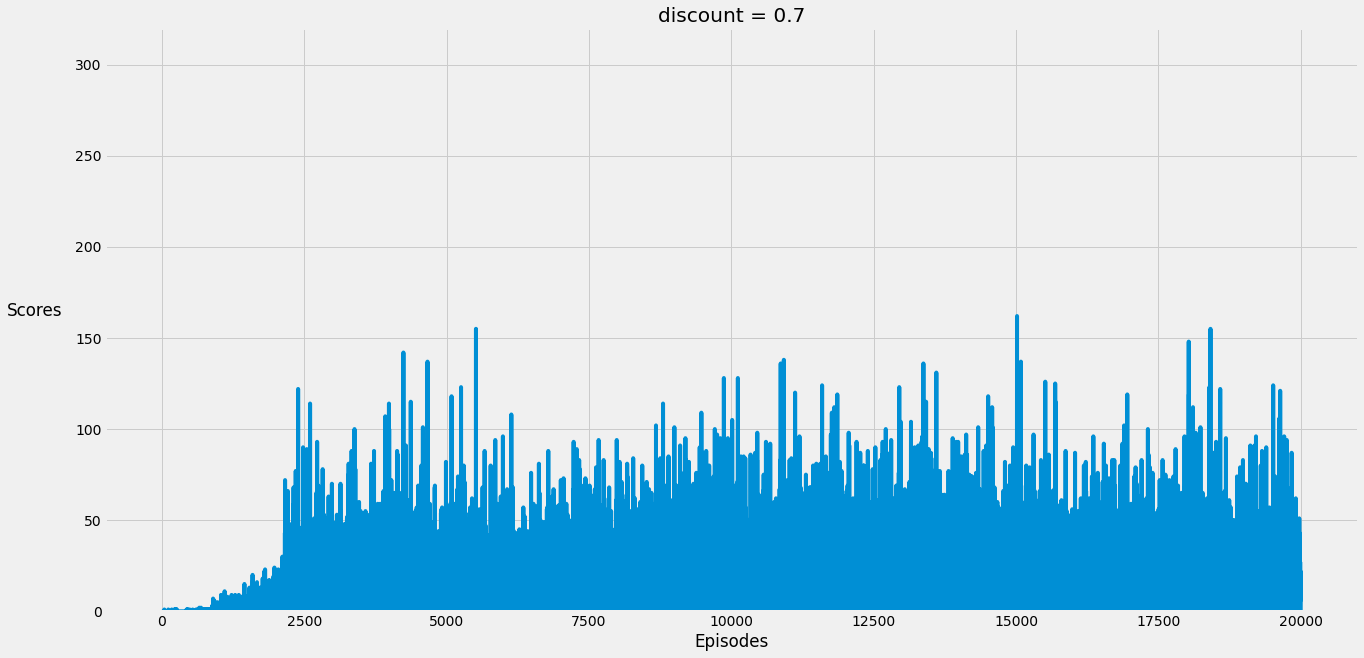

In [ ]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 320)
  plt.title(labels[i])
  plt.show()

In [ ]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


discount = 1.0
Mean:  18.1981
Median:  12.0
Max:  276
--------------------
discount = 0.95
Mean:  18.1111
Median:  12.0
Max:  254
--------------------
discount = 0.9
Mean:  19.59155
Median:  12.0
Max:  269
--------------------
discount = 0.85
Mean:  18.525
Median:  12.0
Max:  236
--------------------
discount = 0.8
Mean:  15.4964
Median:  9.0
Max:  273
--------------------
discount = 0.75
Mean:  15.43185
Median:  9.0
Max:  216
--------------------
discount = 0.7
Mean:  15.2296
Median:  10.0
Max:  162
--------------------


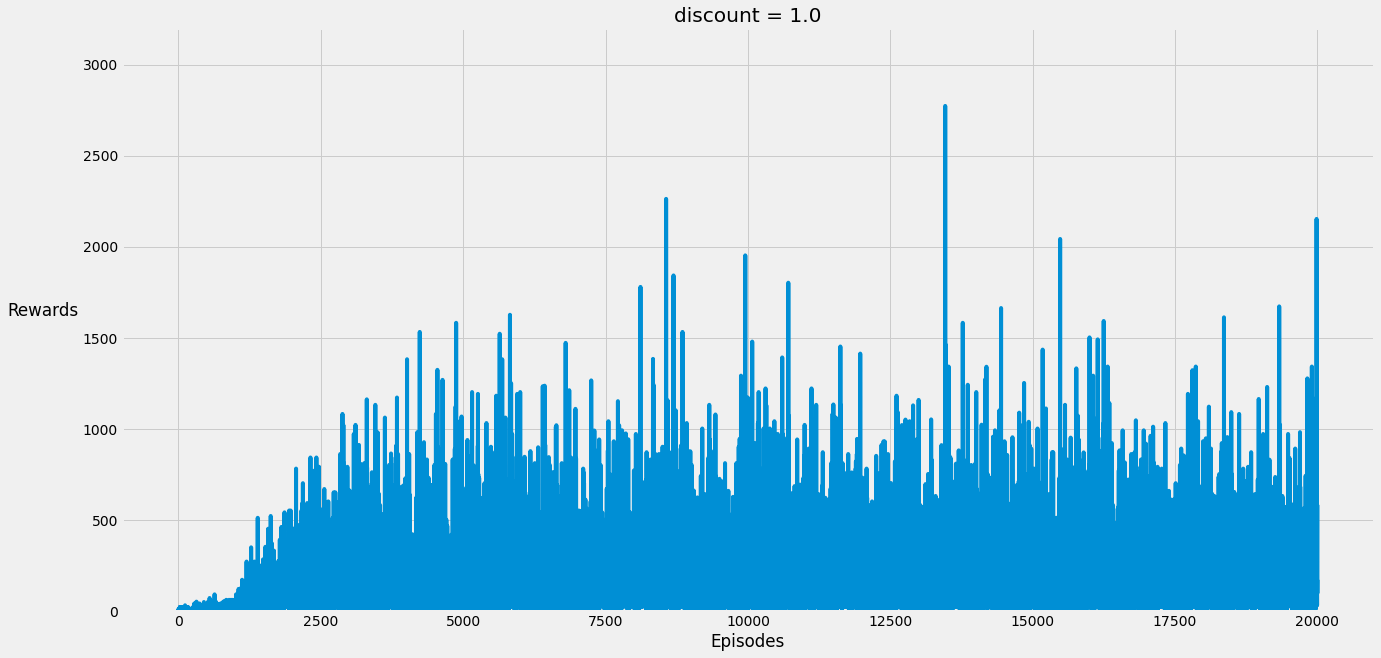

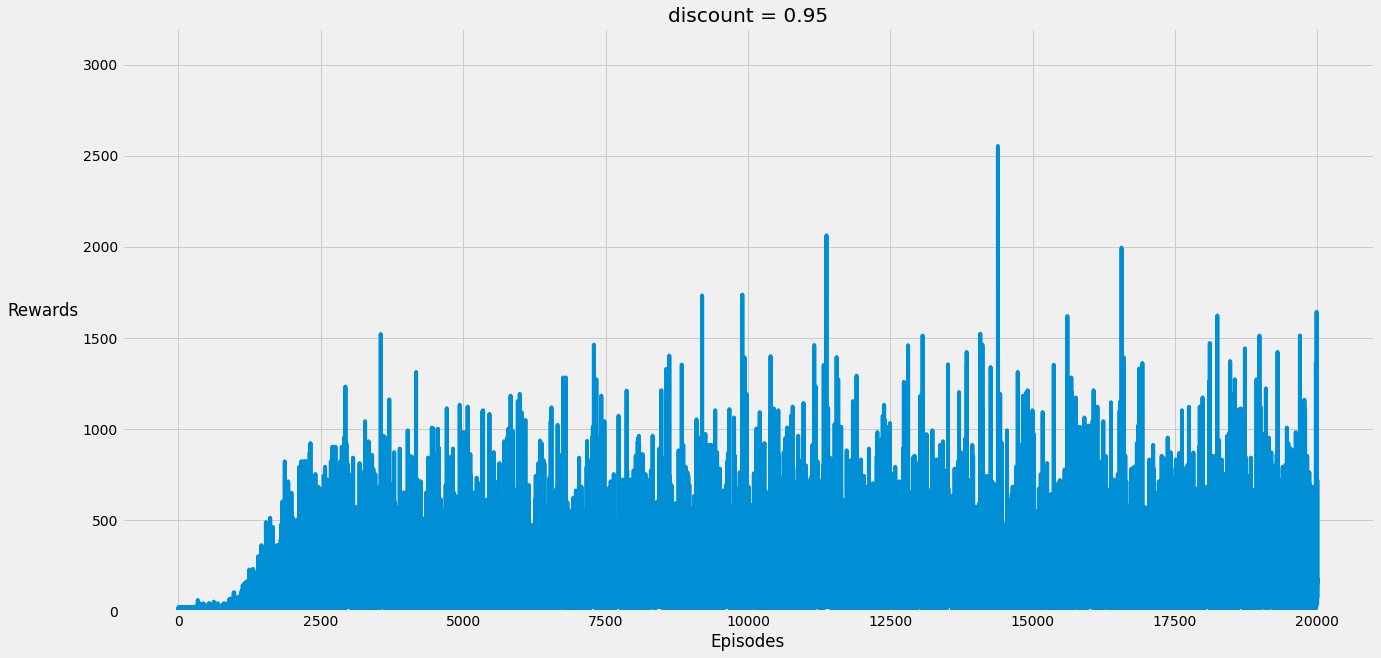

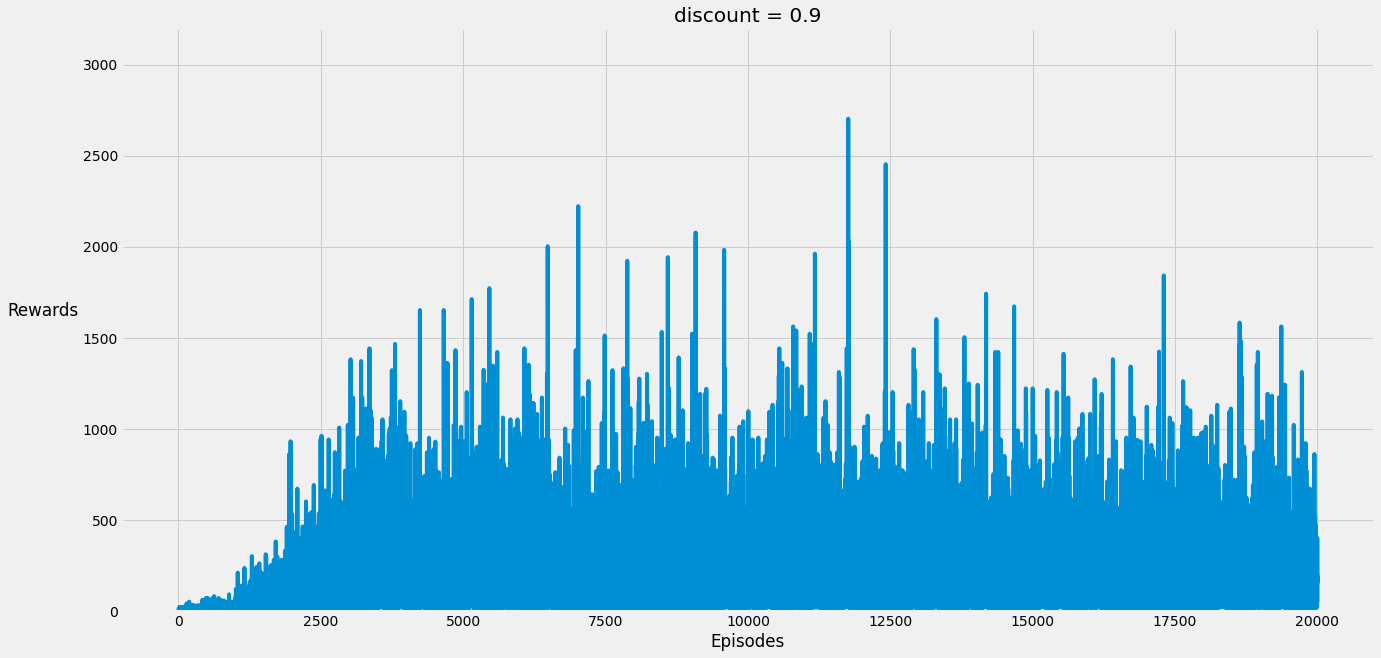

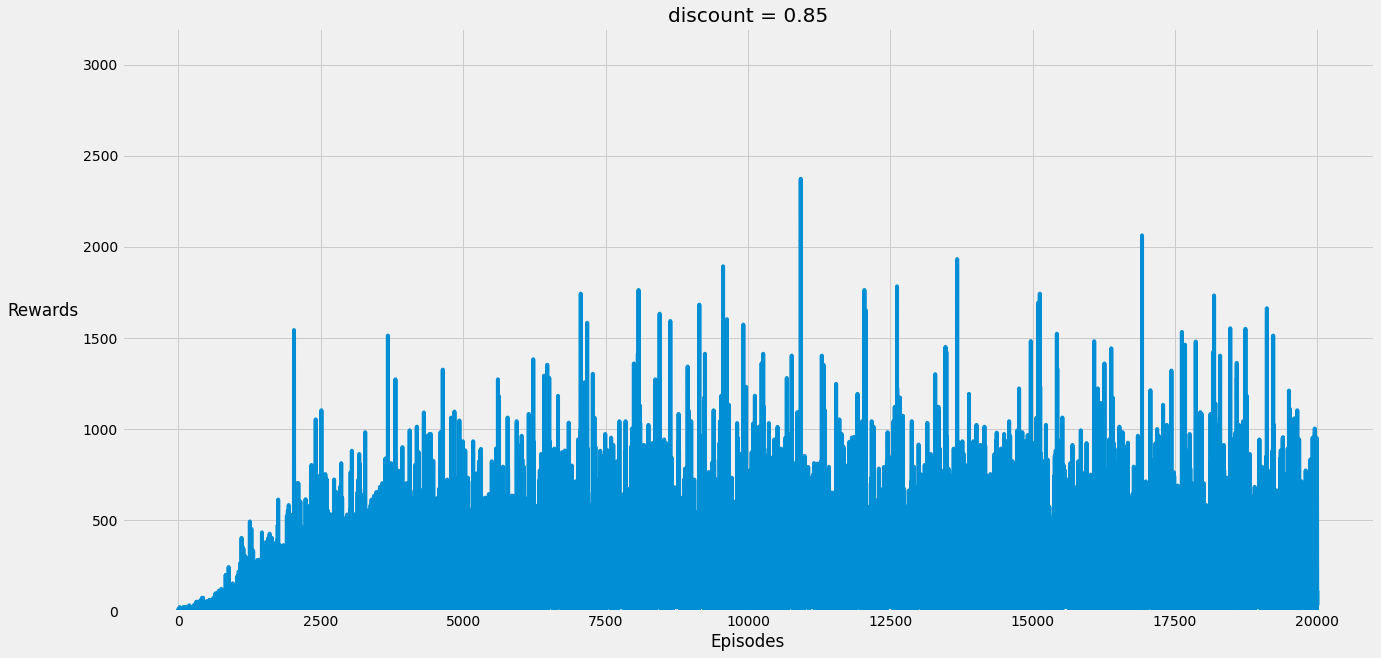

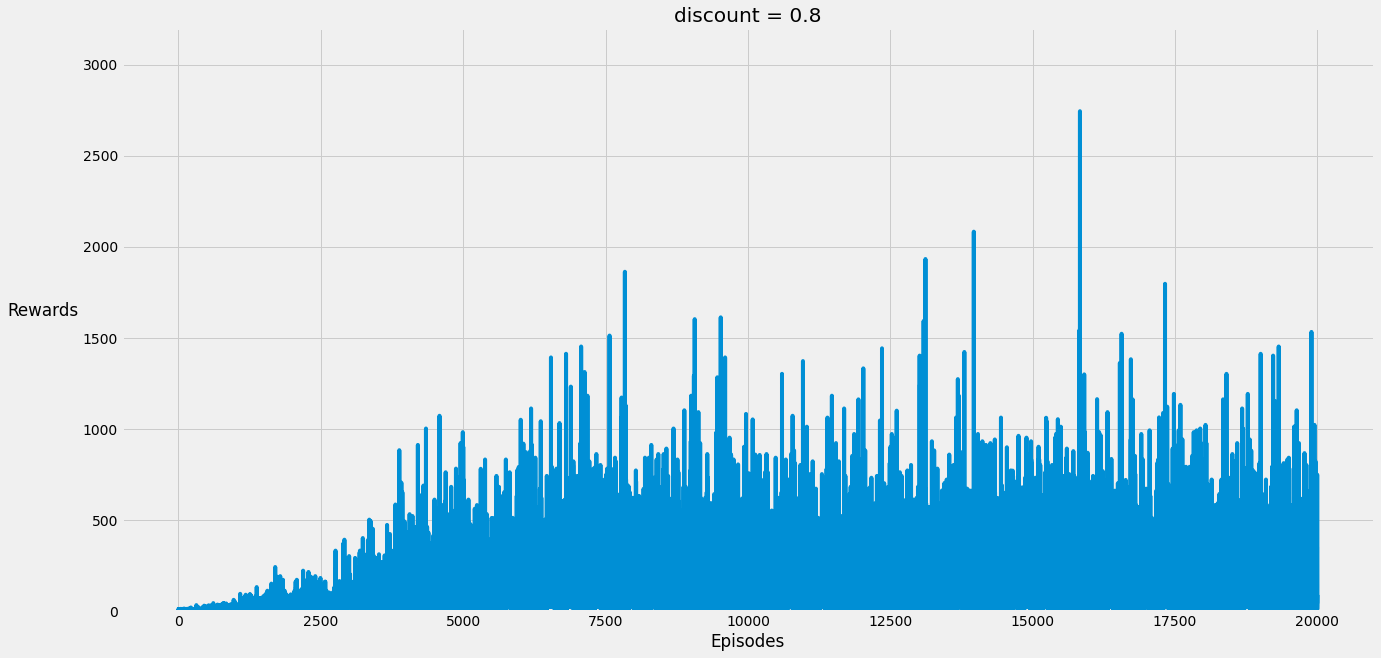

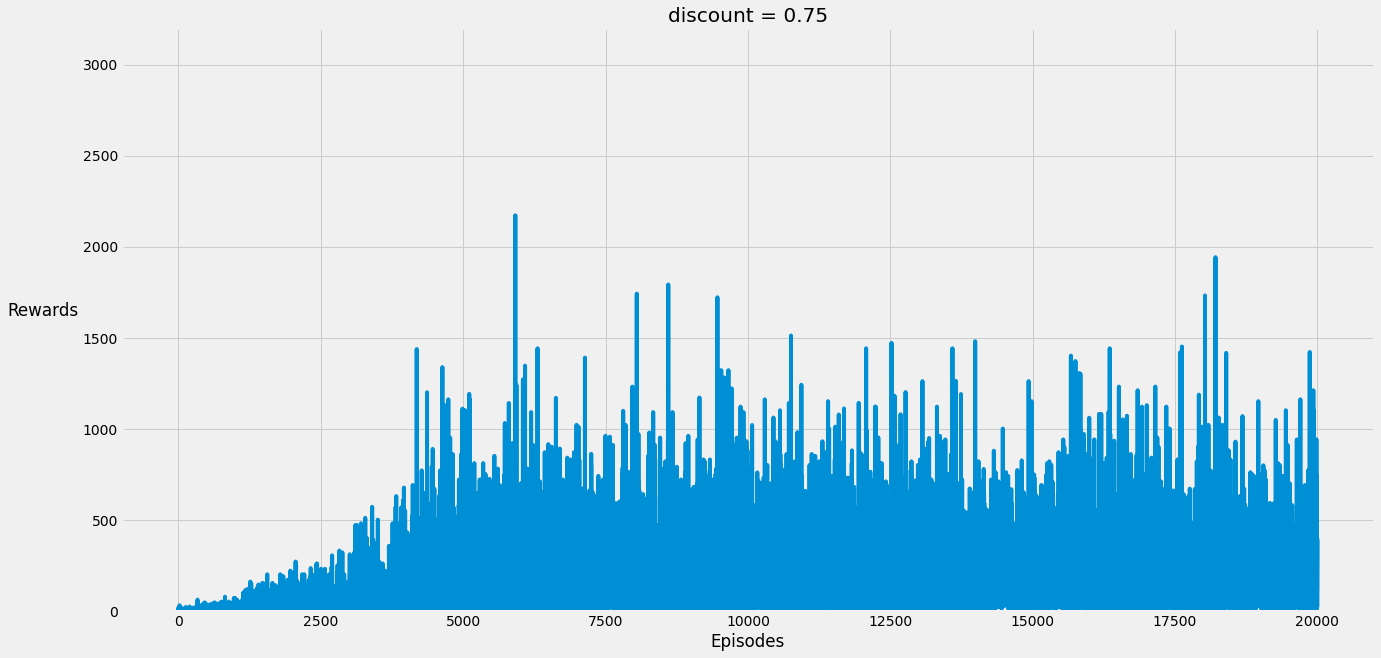

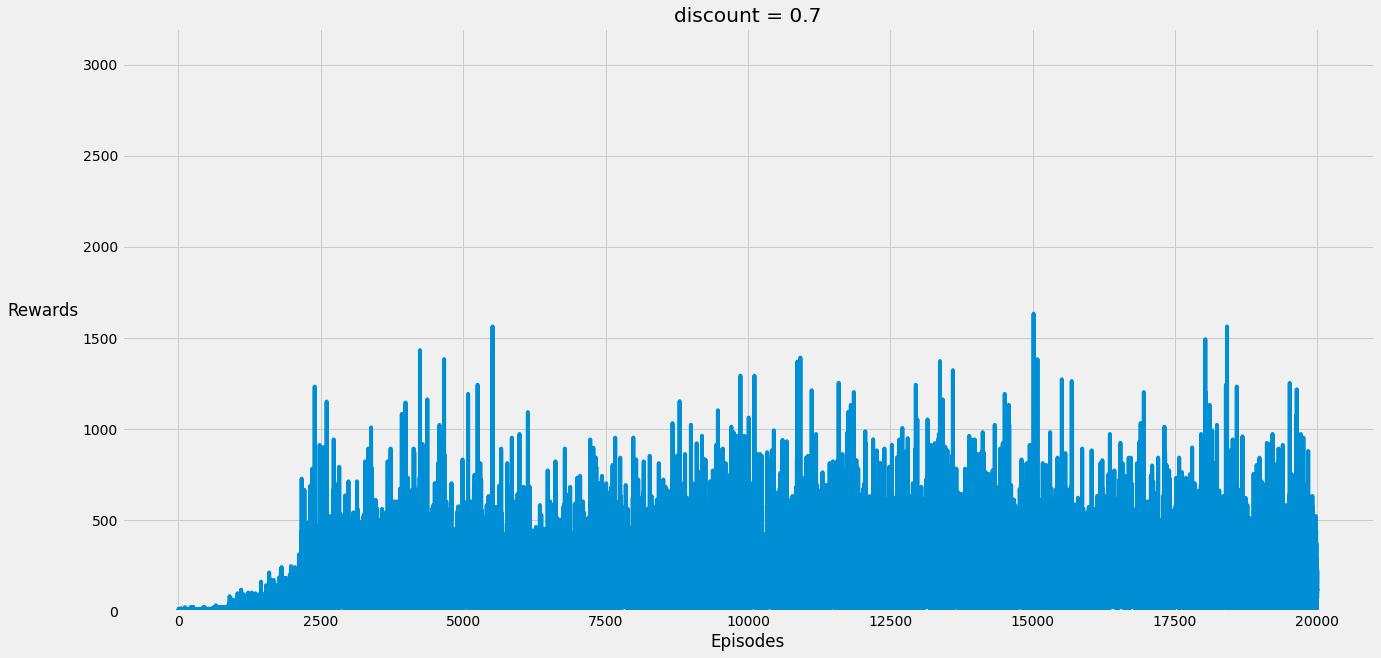

In [ ]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.ylim(0, 3200)
  plt.show()

In [ ]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


discount = 1.0
Mean:  193.87785
Median:  132.0
Max:  2773
--------------------
discount = 0.95
Mean:  193.1033
Median:  128.0
Max:  2553
--------------------
discount = 0.9
Mean:  207.9669
Median:  133.0
Max:  2703
--------------------
discount = 0.85
Mean:  197.24
Median:  133.0
Max:  2373
--------------------
discount = 0.8
Mean:  167.0489
Median:  103.0
Max:  2744
--------------------
discount = 0.75
Mean:  166.4206
Median:  103.0
Max:  2173
--------------------
discount = 0.7
Mean:  164.503
Median:  105.0
Max:  1633
--------------------


Please see the results of the hyperparameter tuning of the discount rate γ after 20,000 runs of 500 episodes:


| Discount γ| Mean | Median | Max |
|------|------|------|------|
|   1.0 | 193.87 | 132 | 2,773 |
|   0.95 | 193.10 | 128 | 2,553 |
|   0.9 | 207.96 | 133 | 2,703 |
|   0.85 | 197.24 | 133 | 2,373 |
|   0.8 | 167.04 | 103 | 2,744 |
|   0.75 | 166.42 | 103 | 2,173 |
|   0.7 | 164.50 | 105 | 1,633 |

Based on the median and average scores, the discount rate γ to use to optimise the agent is γ=0.9.


#### Step-size decay

In [24]:
agent = ExpectedSarsaAgent()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999", "decay = 0.999","decay = 0.99", "decay = 0.95", "decay = 0.9", "decay = 0.85"]
ss_decays = [1.0, 0.99999, 0.9999, 0.999, 0.99, 0.95, 0.9, 0.85]

every_scores = []
every_rewards = []

for step_size_decay in tqdm(ss_decays):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay":1.0, "step_size": 0.4, "step_size_decay": step_size_decay, "discount": 0.9}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 40000 # The number of runs
    num_episodes = 1000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)
                  agent.epsilon = agent.epsilon * agent.eps_decay

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)
                    break

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)


100%|██████████| 8/8 [2:04:18<00:00, 932.32s/it]


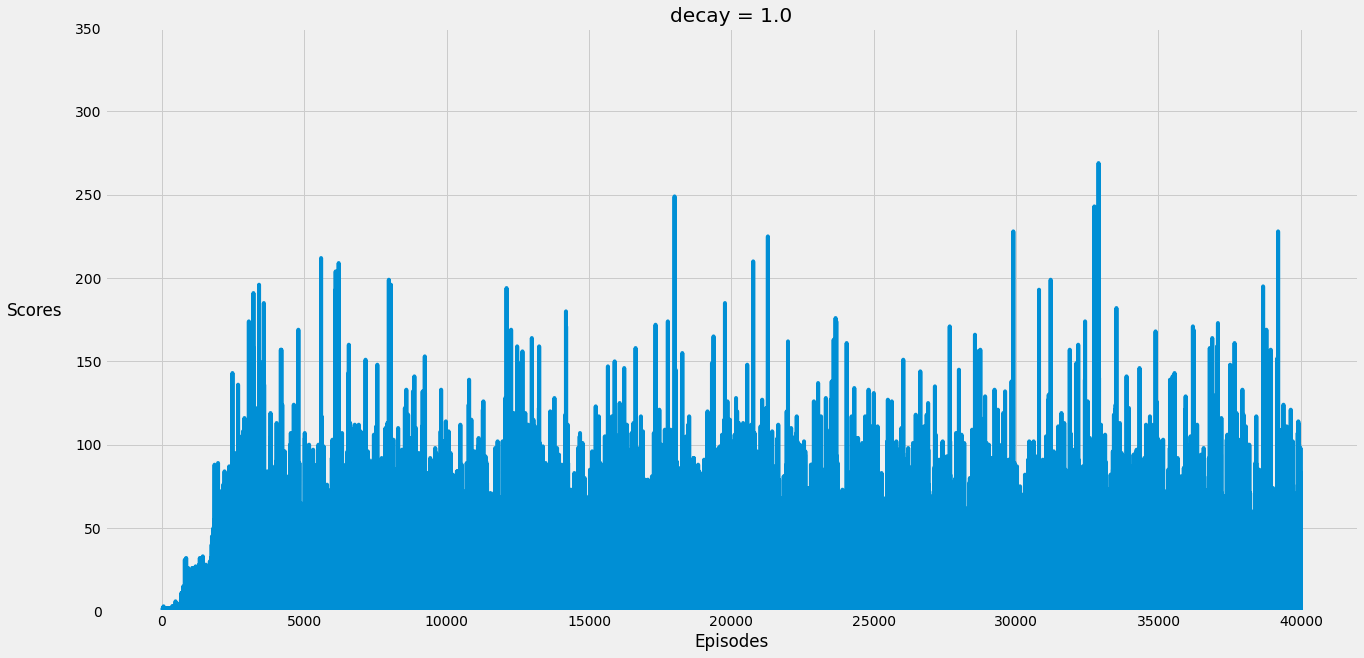

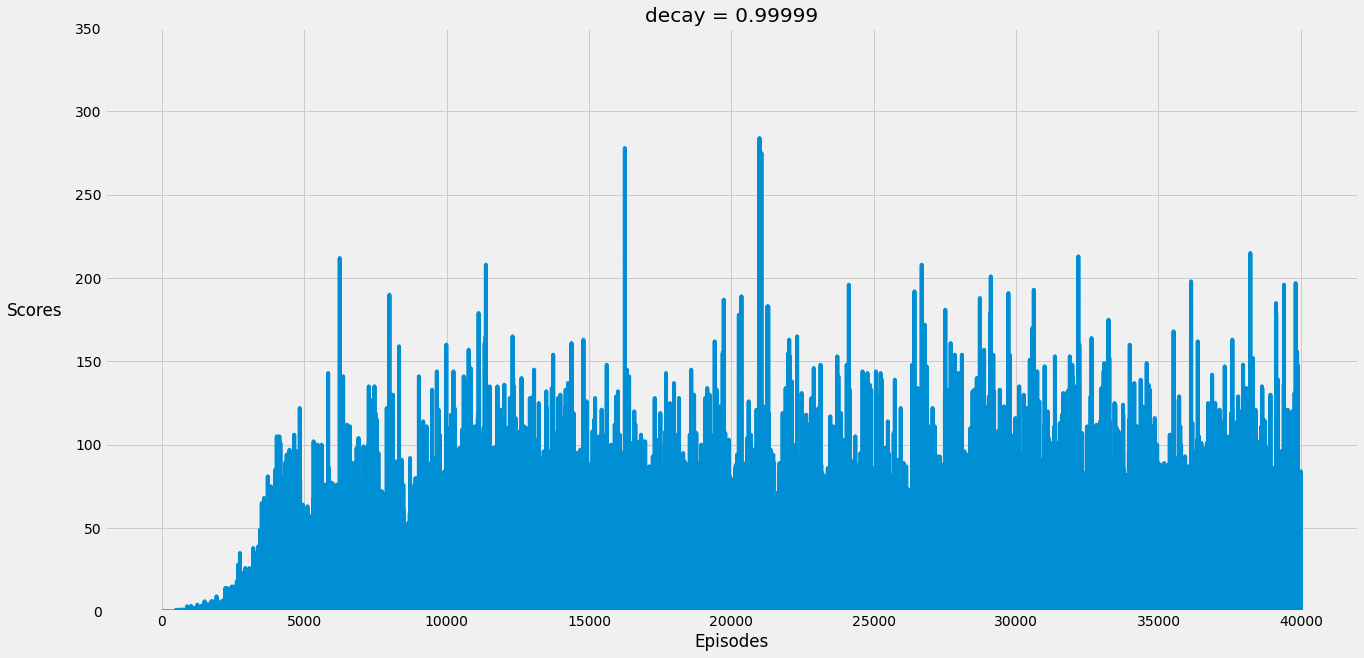

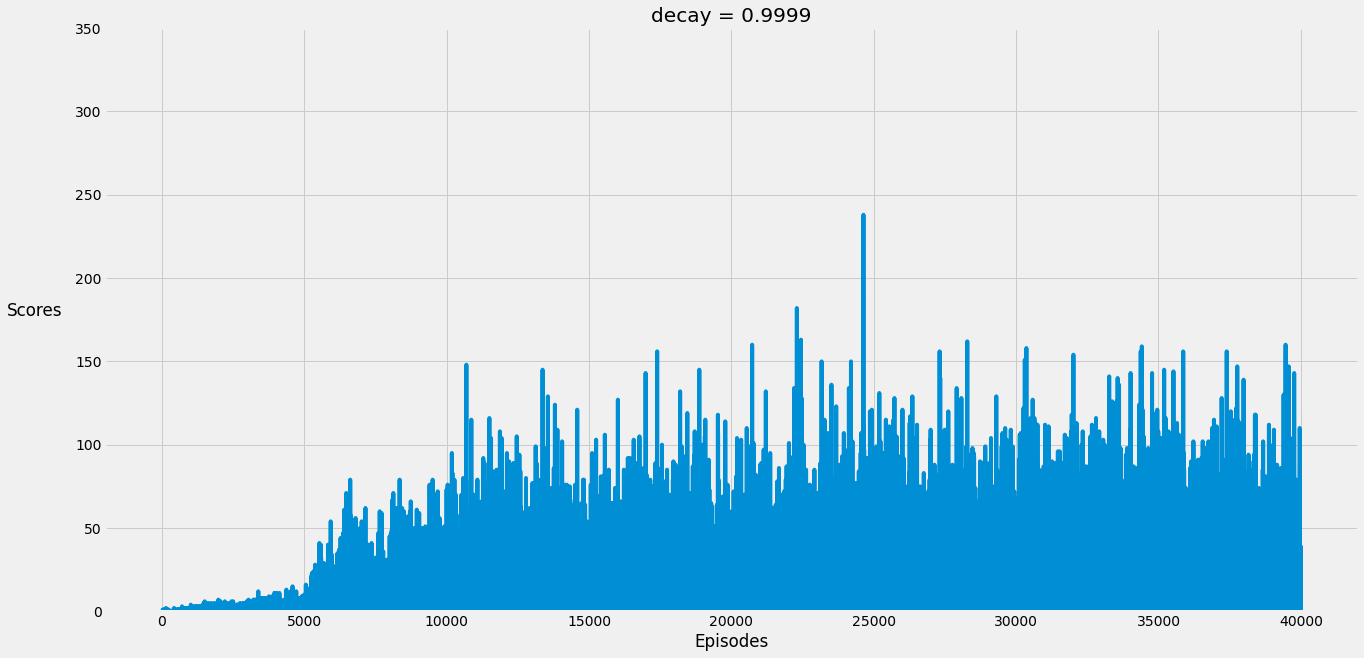

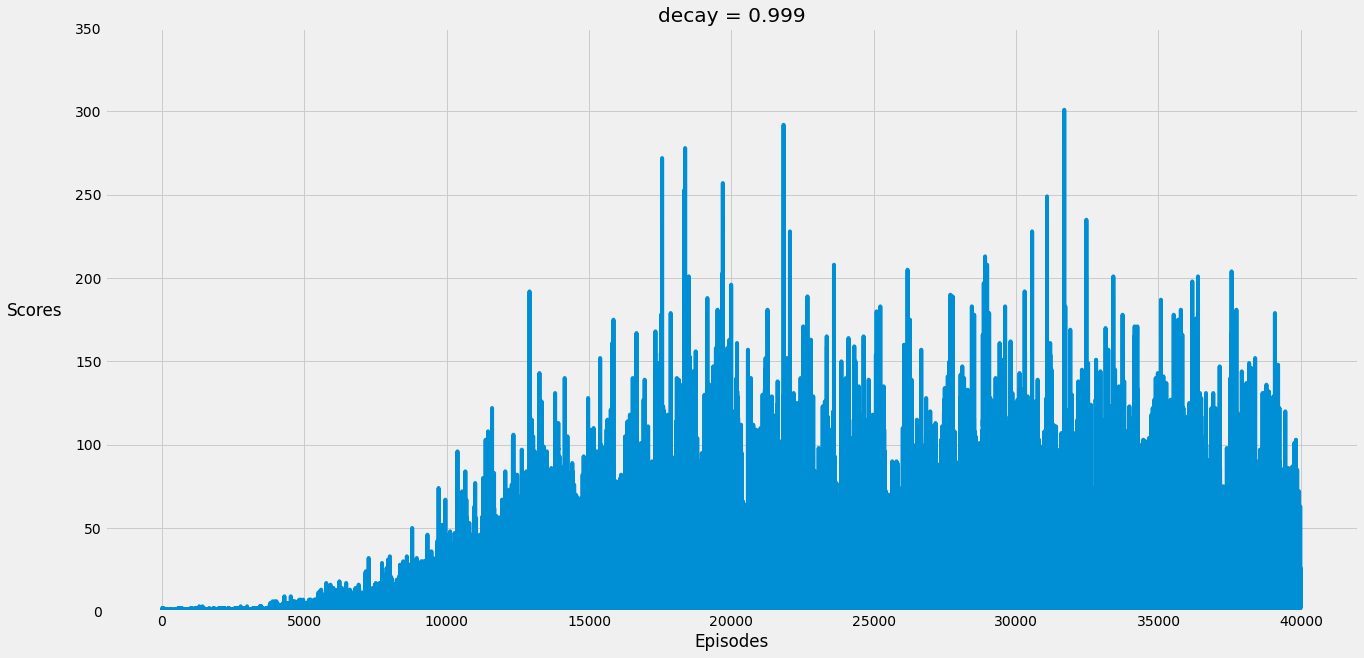

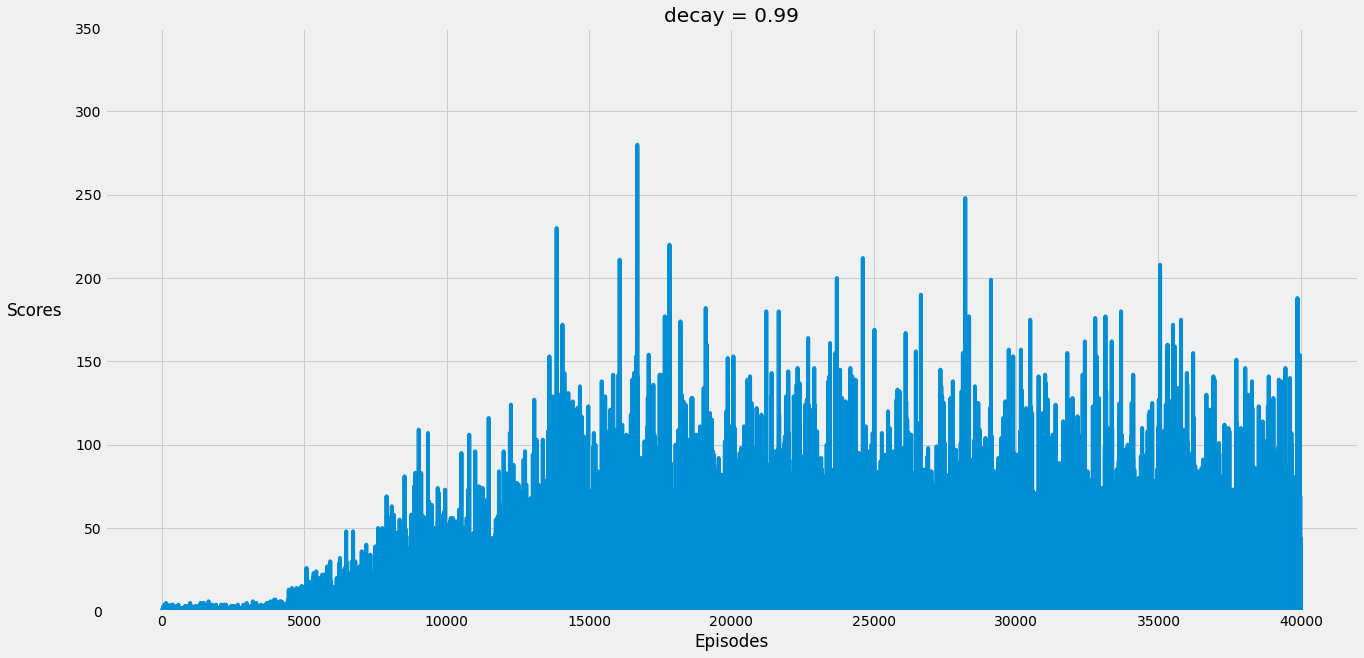

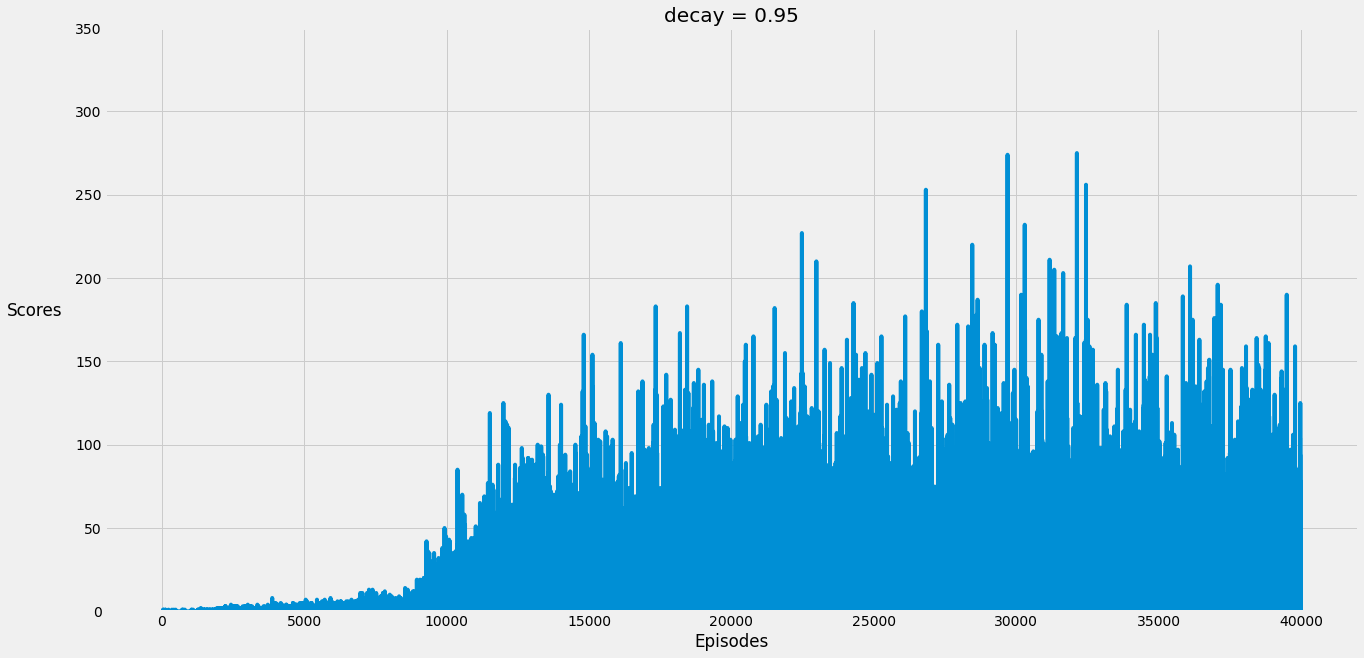

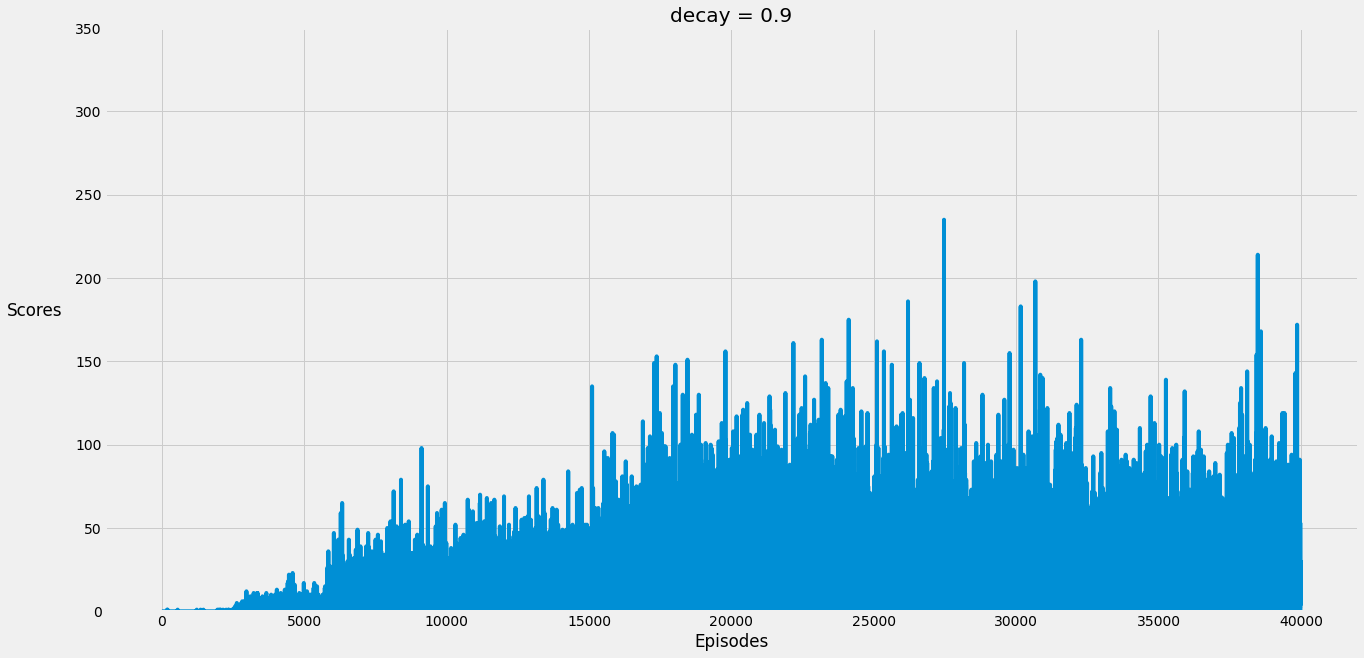

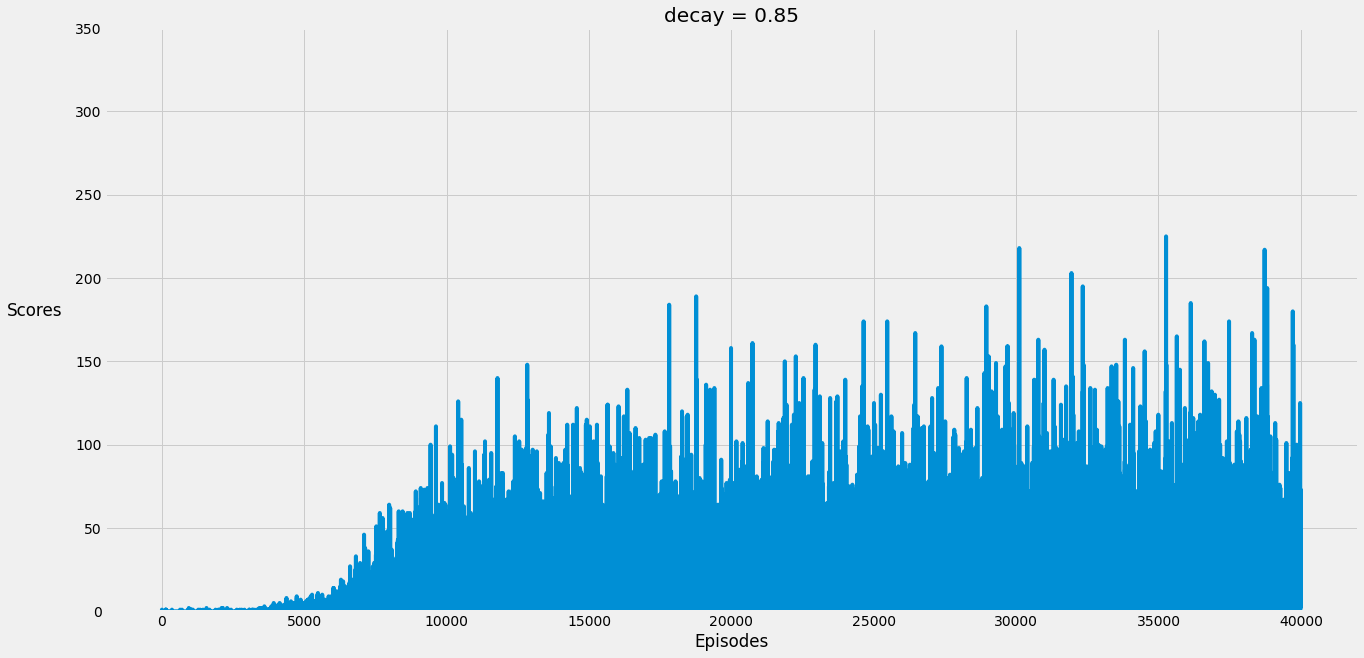

In [30]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.ylim(0, 350)
  plt.title(labels[i])
  plt.show()

In [28]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i]))
  print("Median: ", np.median(every_scores[i]))
  print("Max: ", np.max(every_scores[i]))
  print('-'*20)


decay = 1.0
Mean:  20.01295
Median:  13.0
Max:  269
--------------------
decay = 0.99999
Mean:  20.638975
Median:  13.0
Max:  284
--------------------
decay = 0.9999
Mean:  15.314725
Median:  9.0
Max:  238
--------------------
decay = 0.999
Mean:  18.244075
Median:  9.0
Max:  301
--------------------
decay = 0.99
Mean:  16.87705
Median:  9.0
Max:  280
--------------------
decay = 0.95
Mean:  17.430825
Median:  9.0
Max:  275
--------------------
decay = 0.9
Mean:  14.40145
Median:  8.0
Max:  235
--------------------
decay = 0.85
Mean:  15.93235
Median:  9.0
Max:  225
--------------------


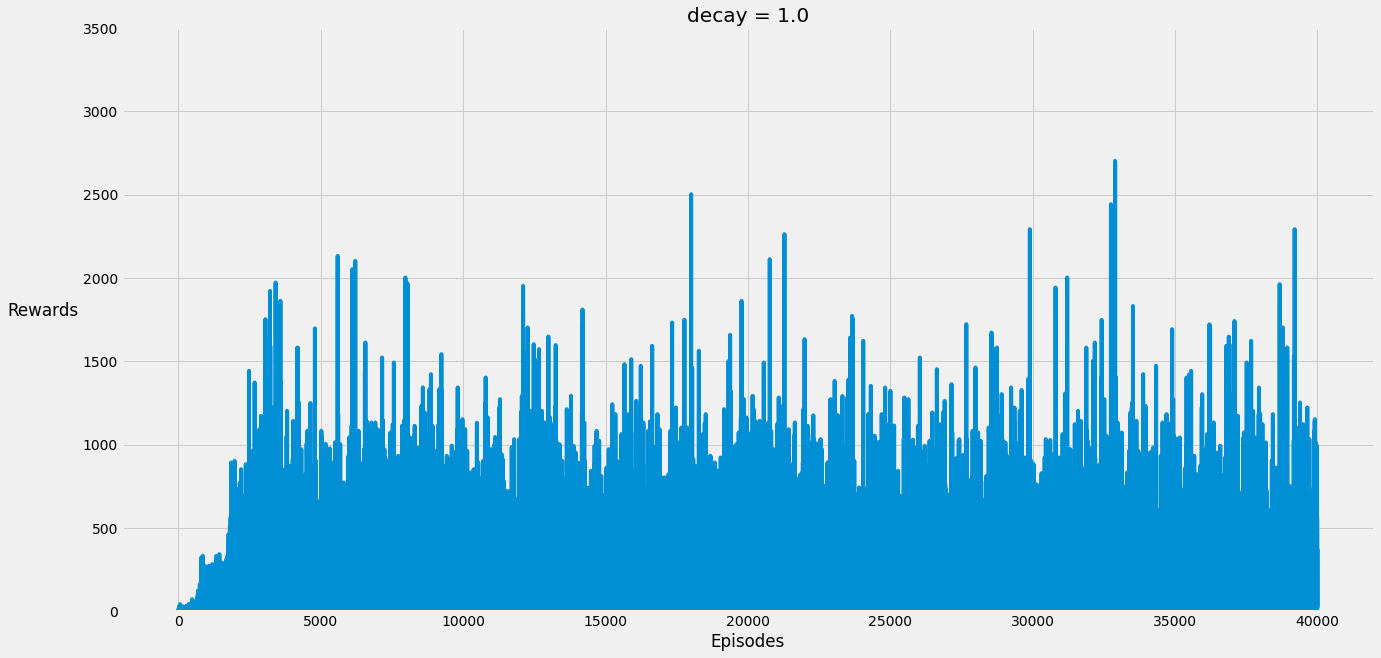

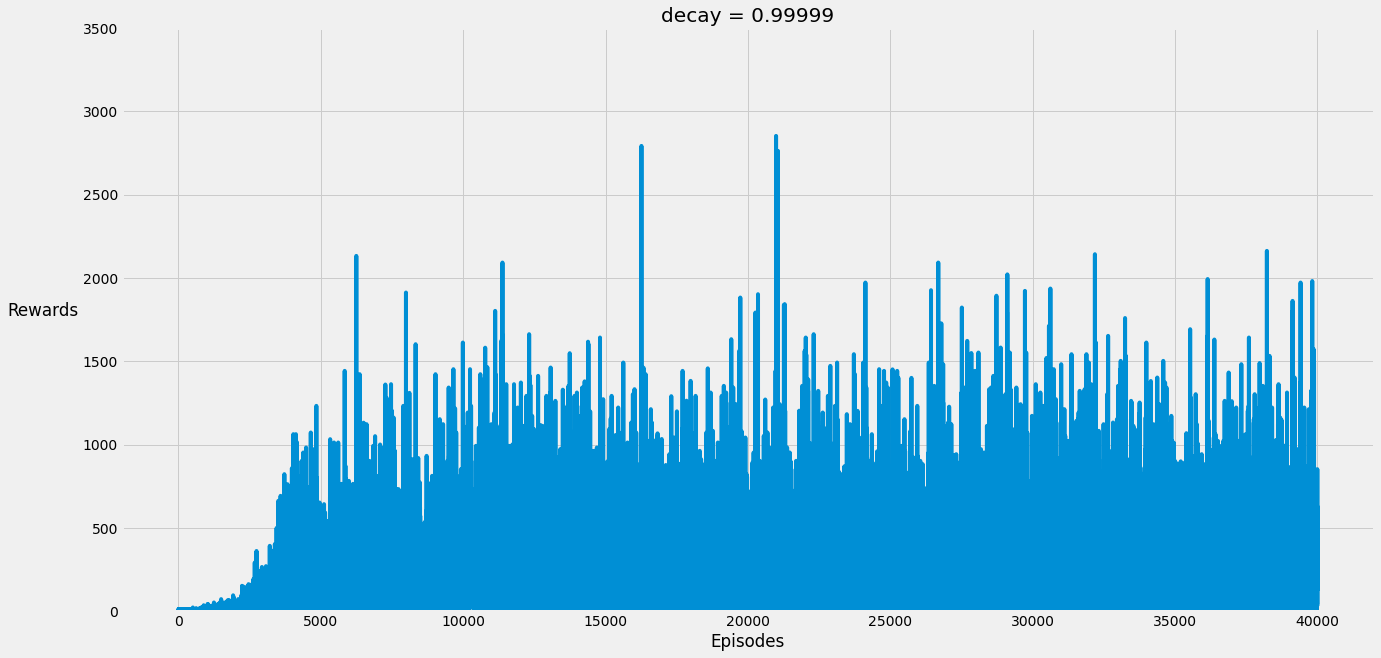

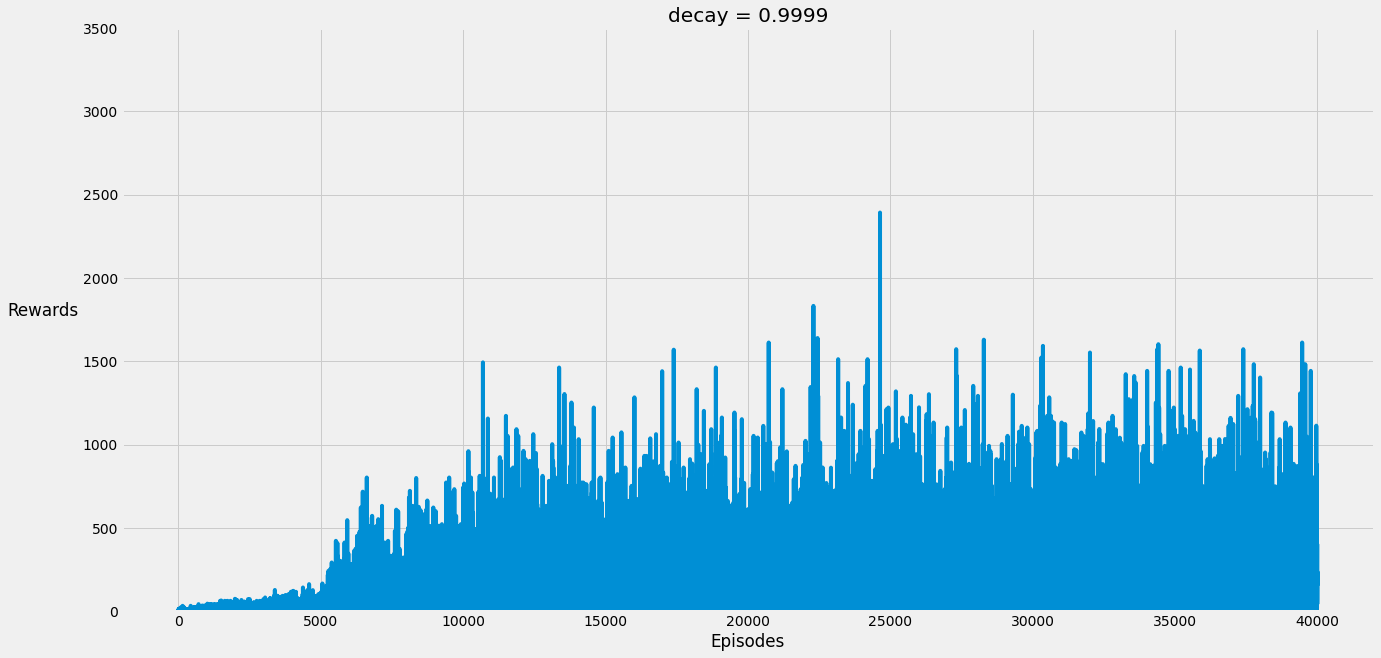

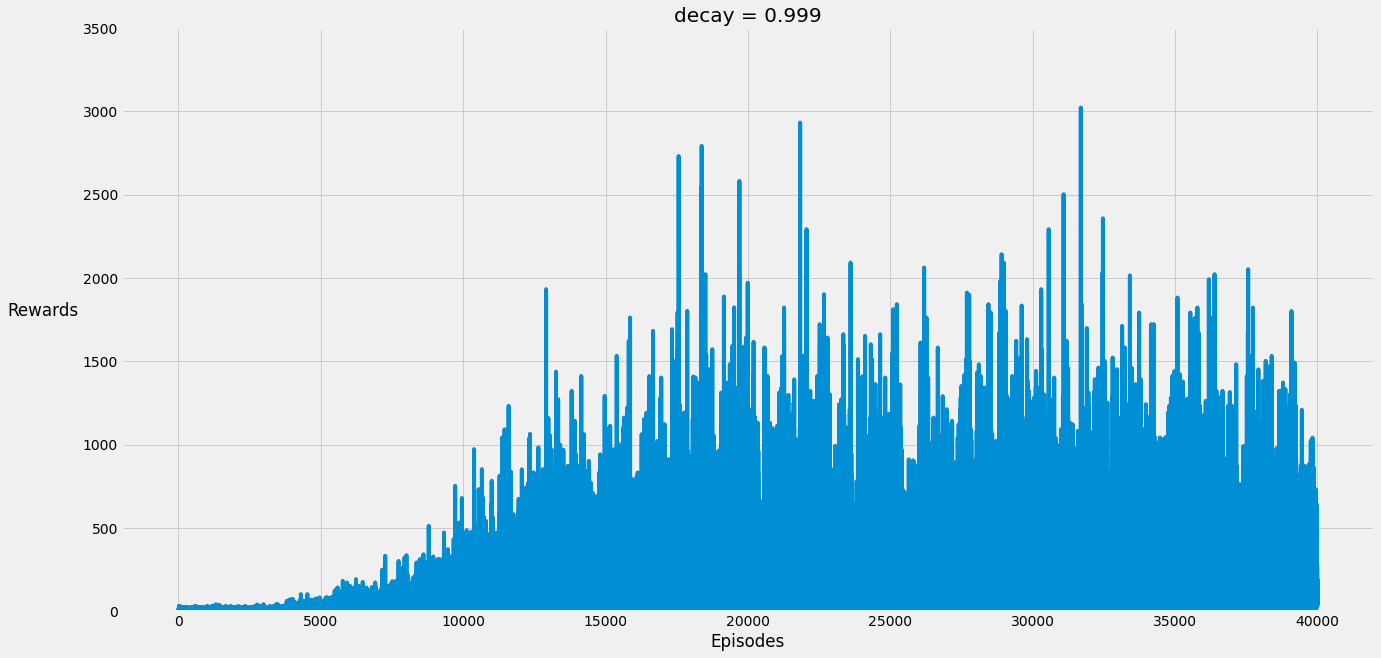

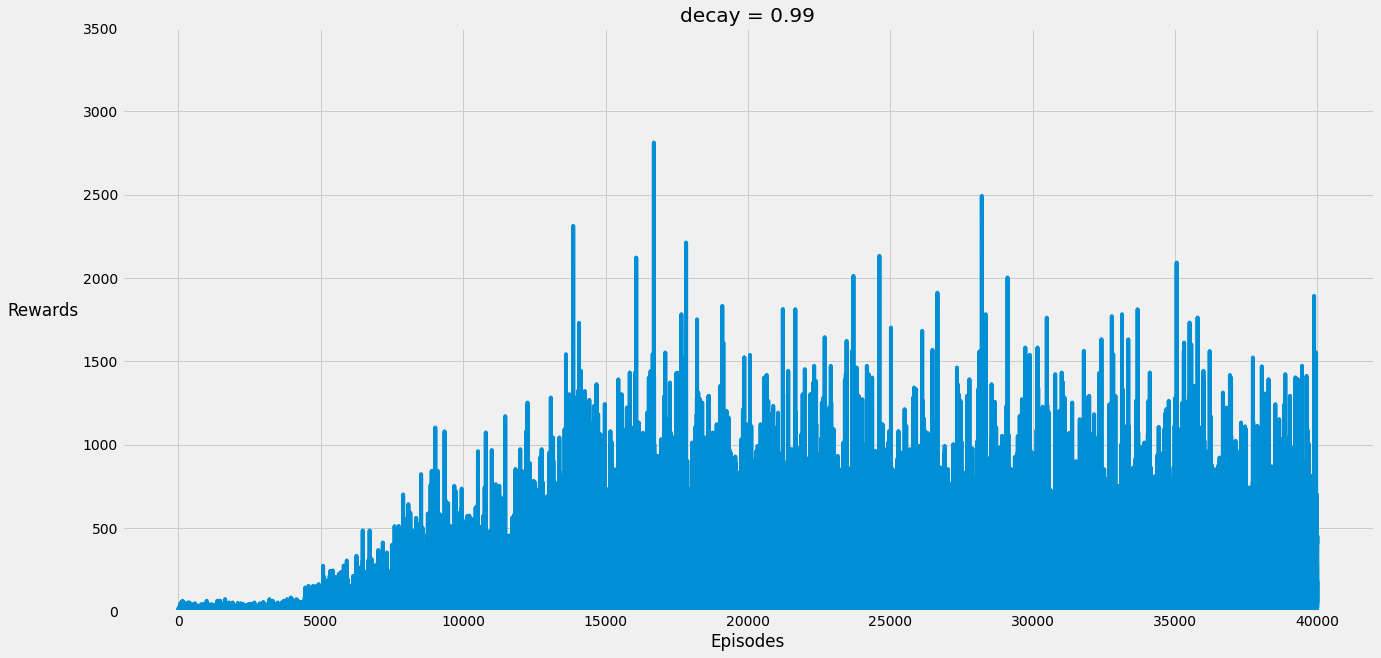

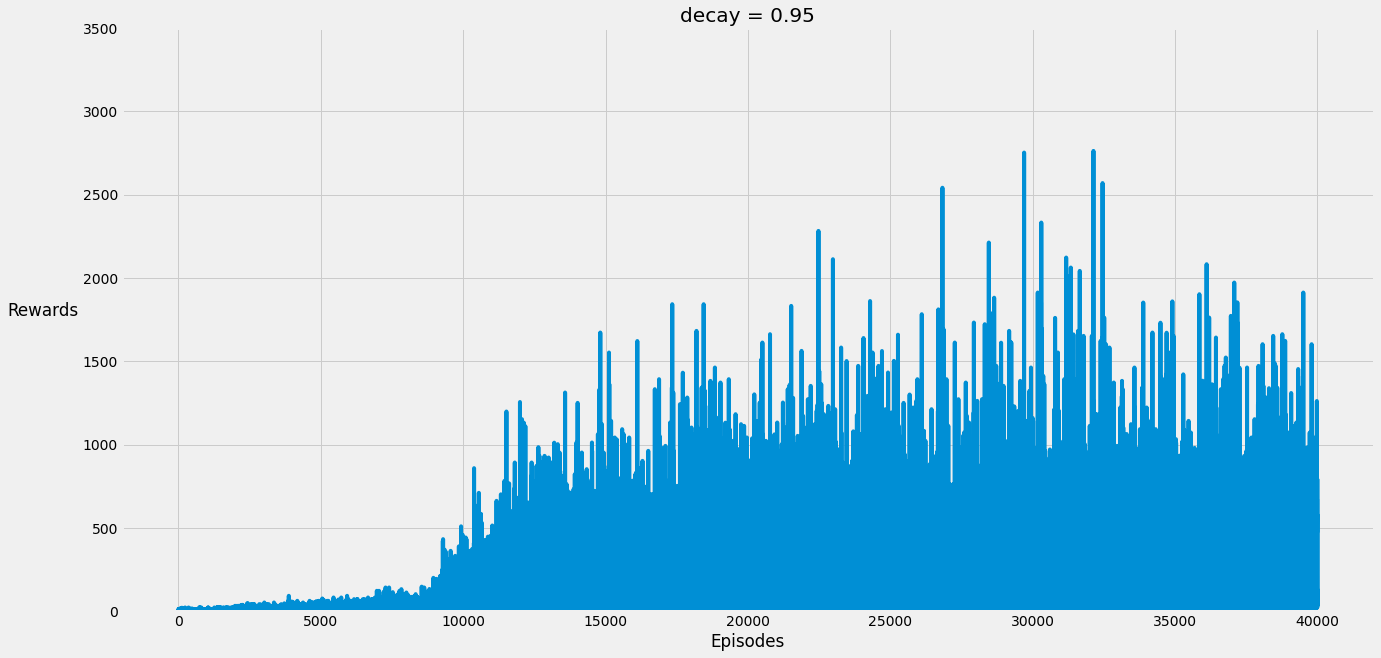

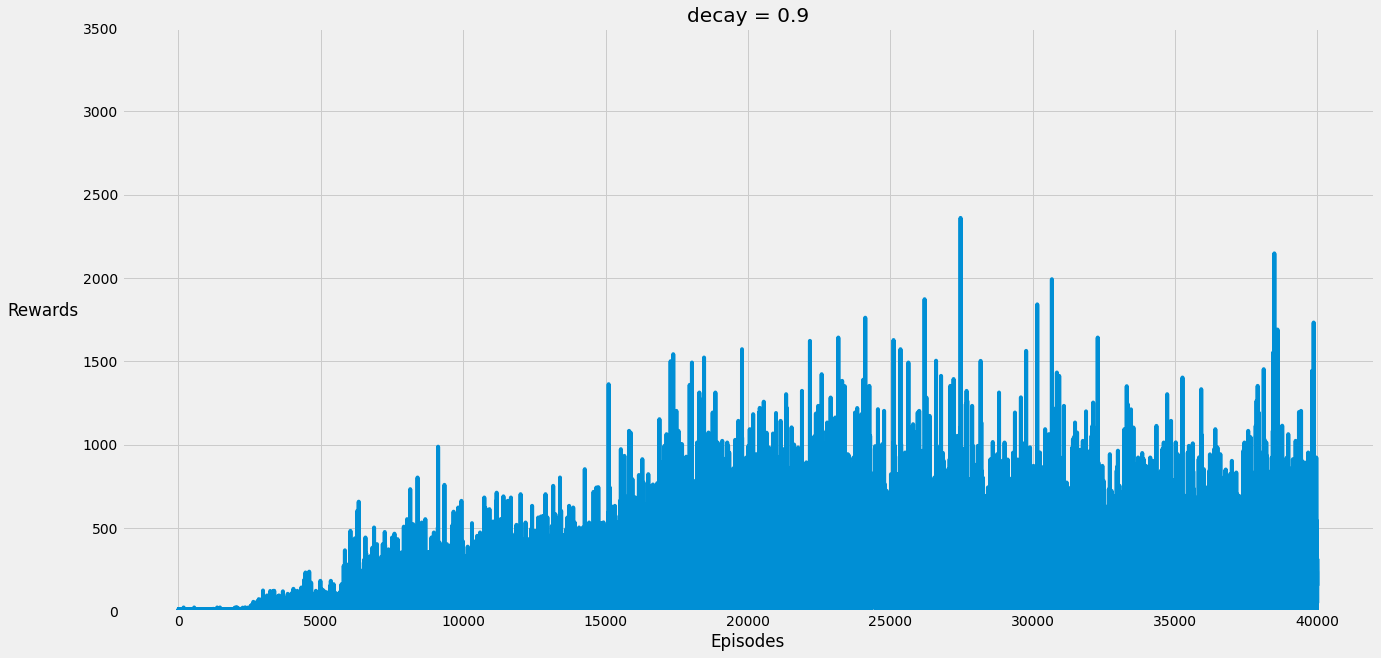

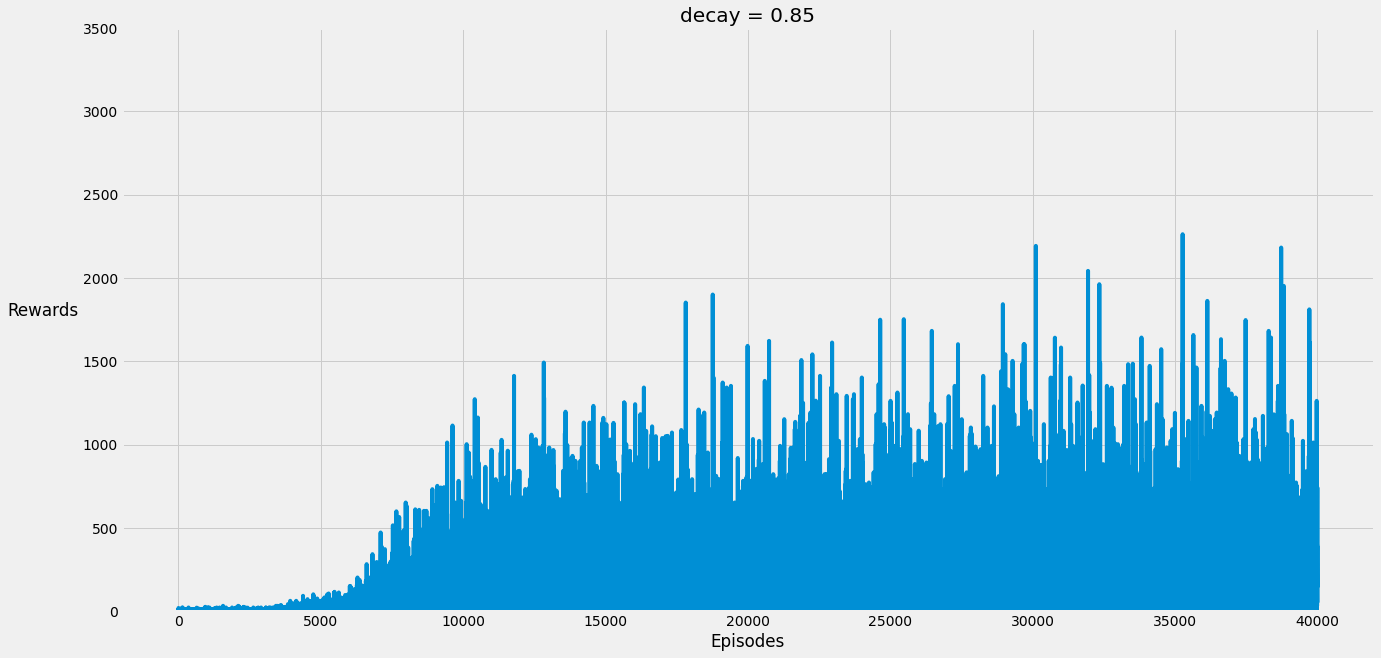

In [31]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.ylim(0, 3500)
  plt.show()

In [29]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i]))
  print("Median: ", np.median(every_rewards[i]))
  print("Max: ", np.max(every_rewards[i]))
  print('-'*20)


decay = 1.0
Mean:  212.162975
Median:  143.0
Max:  2703
--------------------
decay = 0.99999
Mean:  218.51995
Median:  143.0
Max:  2853
--------------------
decay = 0.9999
Mean:  165.196375
Median:  103.0
Max:  2393
--------------------
decay = 0.999
Mean:  194.120675
Median:  103.0
Max:  3023
--------------------
decay = 0.99
Mean:  180.476575
Median:  103.0
Max:  2813
--------------------
decay = 0.95
Mean:  186.1154
Median:  103.0
Max:  2763
--------------------
decay = 0.9
Mean:  155.8745
Median:  93.0
Max:  2361
--------------------
decay = 0.85
Mean:  171.11055
Median:  103.0
Max:  2263
--------------------


Please see the results of the hyperparameter tuning of the step-size decay over the last 5,000 runs (40,000 runs in total):


| Step-size decay| Mean | Median | Max |
|------|------|------|------|
|   1.0 | 212.16 | 143 | 2,703 |
|   0.99999 | 218.51  | 143 | 2,853 |
|   0.9999 | 165.19 | 103 | 2,393 |
|   0.999 | 194.12  | 103 | 3,023 |
|   0.99 | 180.47 | 103 | 2,813 |
|   0.95 | 186.11 | 103 | 2,763 |
|   0.9 | 155.87 | 93 | 2,361 |
|   0.85 | 171.11 | 103 | 2,263 |

Based on the median and average scores, the step-size decay to use to optimise the agent is 0.99999. 

#### Epsilon-decay

In [22]:
agent = ExpectedSarsaAgent()

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999"]
eps_decays = [1.0, 0.99999,  0.9999 ]

every_scores = []
every_rewards = []

for eps_decay in tqdm(eps_decays):

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info = {"num_actions": 2, "epsilon": 0.05, "eps_decay": eps_decay, "step_size": 0.5, "step_size_decay": 0.99999, "discount": 0.9}
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    num_runs = 40000 # The number of runs
    num_episodes = 1000 # The number of episodes in each run

    # Iteration over the number of runs
    for run in range(num_runs):

        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = {}

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            if episode == 0:
          
                # Keep track of the visited states
                state = env.reset()
                action = agent.agent_start(state)

                state_visits[state] = 1
                state, reward, done, info = env.step(action)
                reward_sums.append(reward)

            else:
                while not done:
                  action = agent.agent_step(reward, state)

                  if state not in state_visits: 
                      state_visits[state] = 1
                  else:
                      state_visits[state] += 1

                  state, reward, done, info = env.step(action)
                  reward_sums.append(reward)

                  # If terminal state
                  if done:
                    action = agent.agent_end(reward)
                    break

          
        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])

    every_scores.append(all_scores)
    every_rewards.append(all_reward_sums)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [16:53<00:00, 337.77s/it]


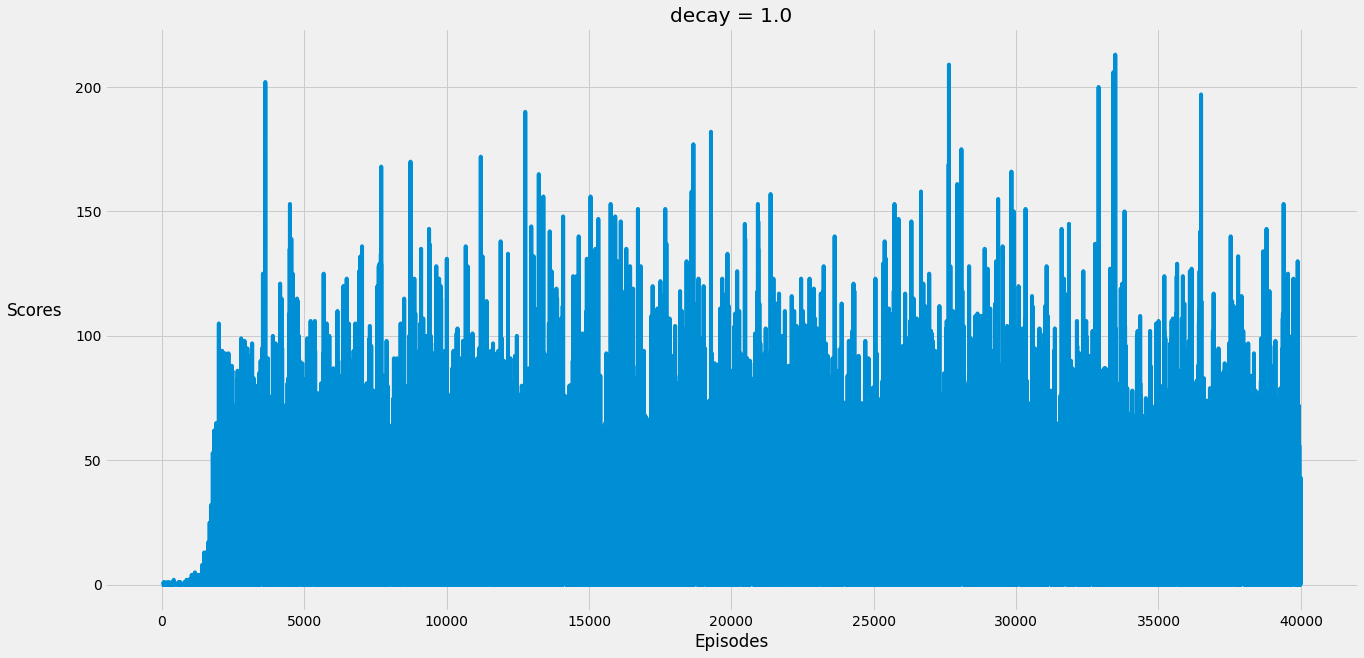

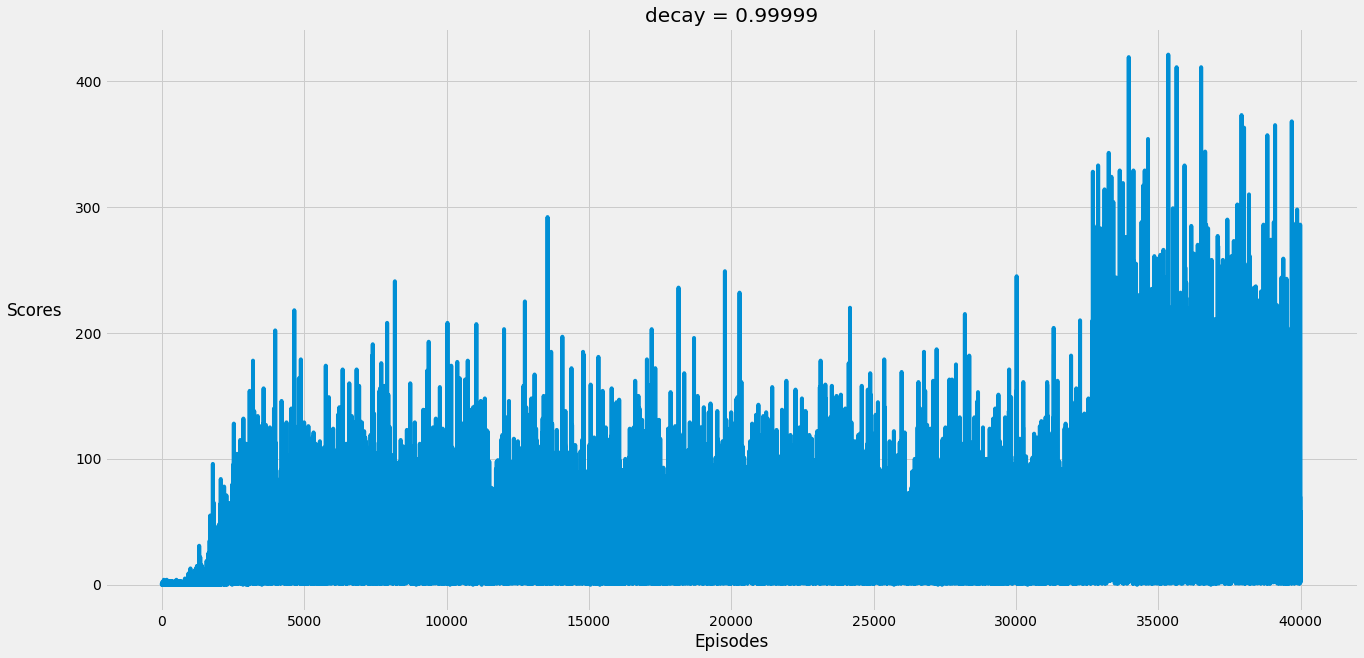

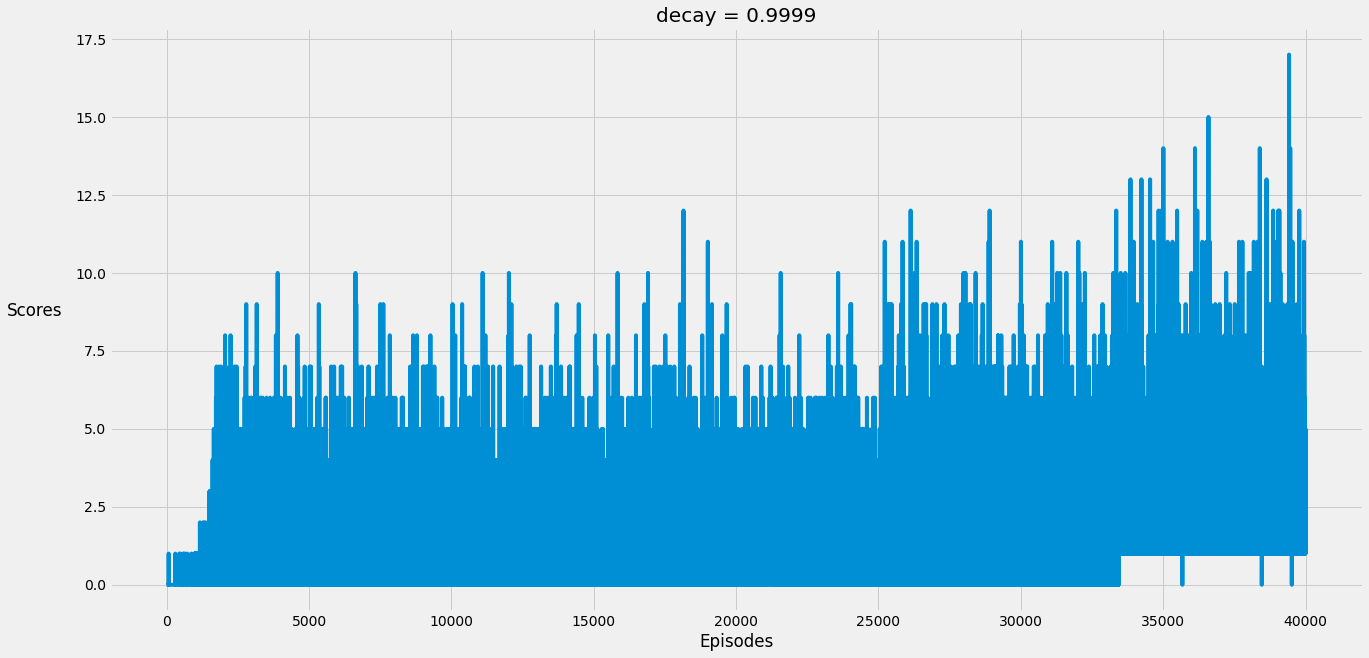

In [20]:
for i in range(len(every_scores)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_scores[i])
  plt.xlabel("Episodes")
  plt.ylabel("Scores",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.show()

In [23]:
for i in range(len(every_scores)):
  print(labels[i])
  print("Mean: ", np.mean(every_scores[i][:-5000]))
  print("Median: ", np.median(every_scores[i][:-5000]))
  print("Max: ", np.max(every_scores[i][:-5000]))
  print('-'*20)




decay = 1.0
Mean:  20.053171428571428
Median:  13.0
Max:  265
--------------------
decay = 0.99999
Mean:  34.1998
Median:  23.0
Max:  366
--------------------
decay = 0.9999
Mean:  4.7058285714285715
Median:  3.0
Max:  38
--------------------


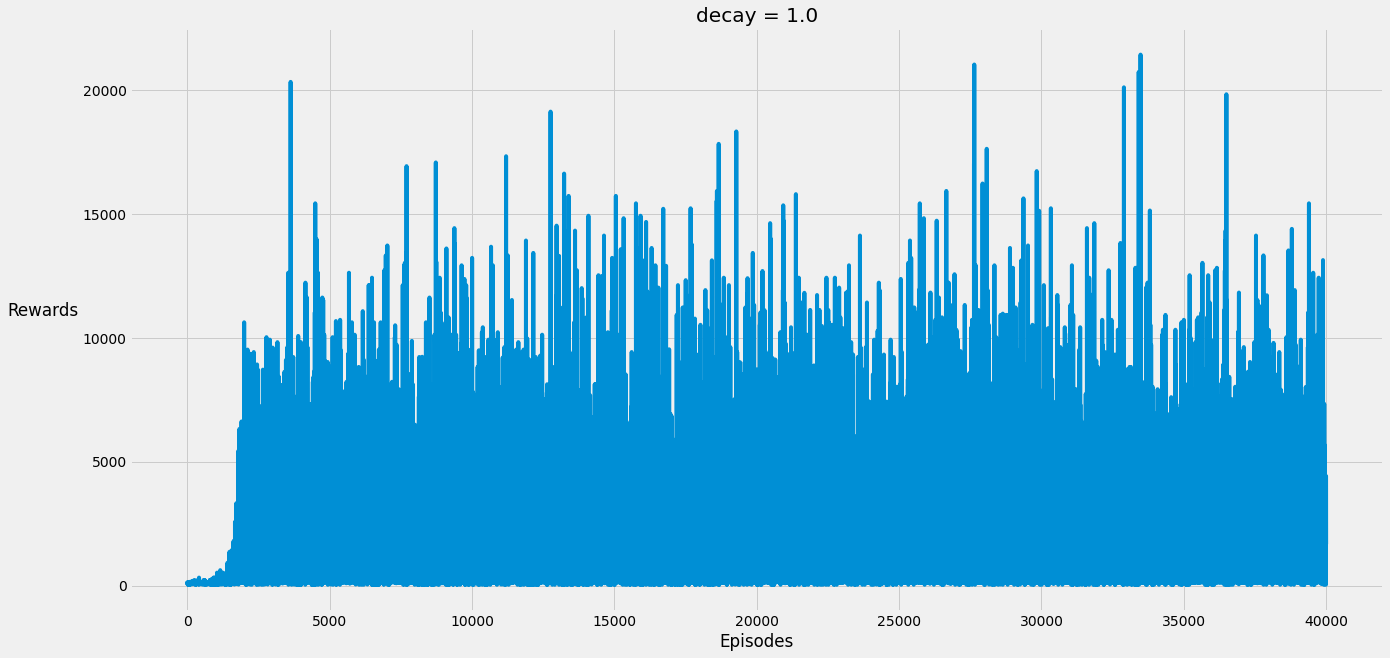

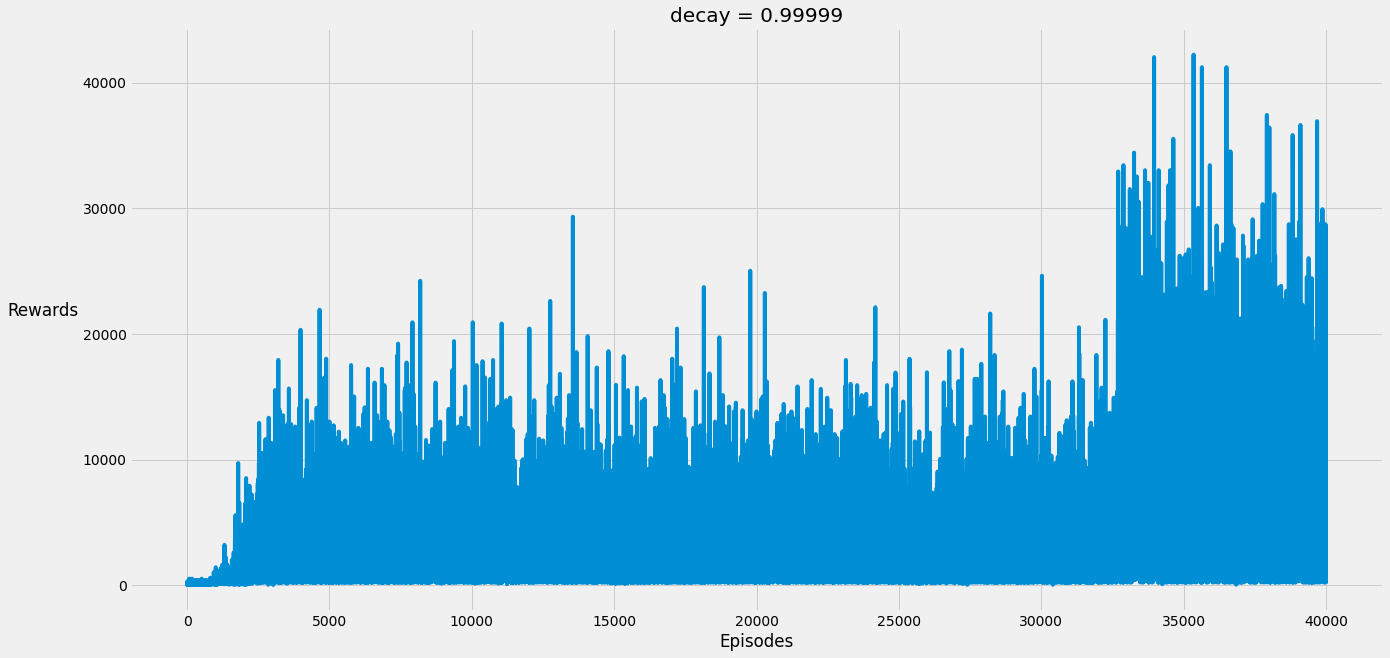

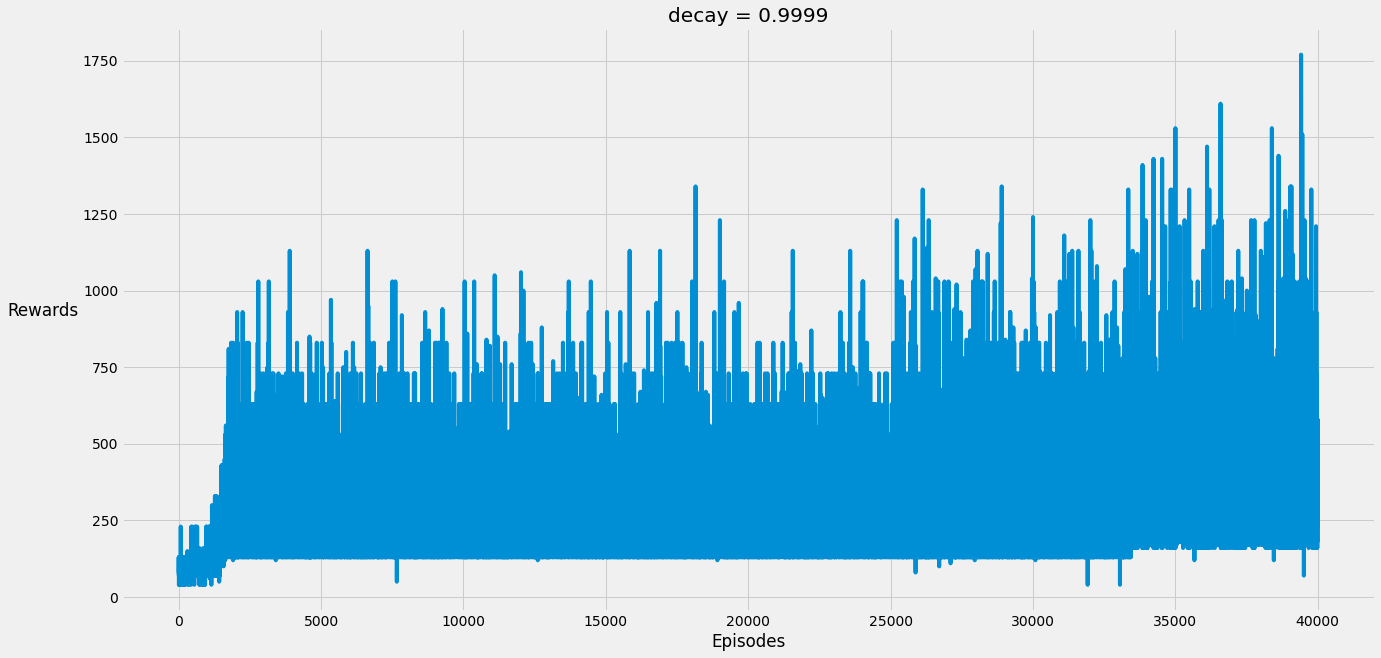

In [21]:
for i in range(len(every_rewards)):
  # Plot the results
  x = np.arange(num_runs)
  plt.figure(figsize=(20, 10))
  plt.plot(x, every_rewards[i])
  plt.xlabel("Episodes")
  plt.ylabel("Rewards",rotation=0, labelpad=40)
  plt.title(labels[i])
  plt.show()

In [24]:
for i in range(len(every_rewards)):
  print(labels[i])
  print("Mean: ", np.mean(every_rewards[i][:-5000]))
  print("Median: ", np.median(every_rewards[i][:-5000]))
  print("Max: ", np.max(every_rewards[i][:-5000]))
  print('-'*20)



decay = 1.0
Mean:  2128.252285714286
Median:  1430.0
Max:  26590
--------------------
decay = 0.99999
Mean:  3527.385714285714
Median:  2360.0
Max:  36660
--------------------
decay = 0.9999
Mean:  566.0251428571429
Median:  430.0
Max:  3860
--------------------


Please see the results of the hyperparameter tuning of the epsilon decay over the last 5,000 runs (40,000 runs in total):


| Step-size decay| Mean | Median | Max |
|------|------|------|------|
|   1.0 | 2,128.25 | 1,430 | 26,590 |
|   0.99999 | 3,527.38  | 2,360 | 36,660 |
|   0.9999 |  566.0 | 430 | 3,860 |

Based on the median and average rewards, the epsilon decay to use to optimise the agent is 0.99999. 

## State-Value Functions

### Agent n°1: Q-Learning

In [133]:
# Load the final q-table
q_table_ql = pickle.load(open('q_table_ql.pkl', 'rb'))

/var/folders/zm/kkmsx86x44jd62c4wv0jdz1m0000gn/T/ipykernel_8137/1006551769.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(surf, ticks=[-1, 0, 1])


[Text(1, -1, 'NOT VISITED'), Text(1, 0, '0 (IDLE)'), Text(1, 1, '1 (FLAP)')]

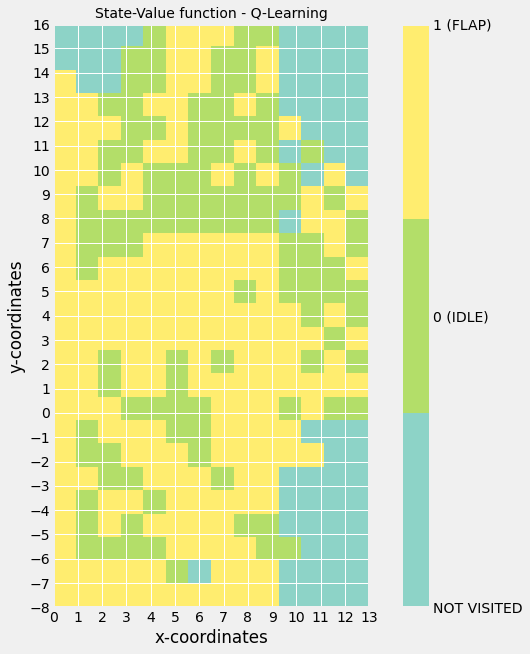

In [152]:
# Get the range of x/y-axis for the plot
x_values_QL = []
y_values_QL = []
q_table_ql.keys()

for key in q_table_ql.keys():
    
    x = key[0][0]
    y = key[0][1]
    
    if x not in x_values_QL:
        x_values_QL.append(x)
        
    
    if y not in y_values_QL:
        y_values_QL.append(y)
        
# Prepare the plot
x_range = sorted(x_values_QL)
y_range = sorted(y_values_QL)

X, Y = np.meshgrid(x_range, y_range)

Z = np.array([[get_qvalue(x, y, q_table_ql) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('Set3', 3), vmin=-1, vmax=1 , extent=[0, 13, -8, 16])
plt.title('State-Value function - Q-Learning', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['NOT VISITED', '0 (IDLE)','1 (FLAP)'])

### Agent n°2: Expected SARSA

In [141]:
# Load the final q-table
q_table_exp_sarsa = pickle.load(open('q_table_exp_sarsa.pkl', 'rb'))

/var/folders/zm/kkmsx86x44jd62c4wv0jdz1m0000gn/T/ipykernel_8137/1740148829.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(surf, ticks=[-1, 0, 1])


[Text(1, -1, 'NOT VISITED'), Text(1, 0, '0 (IDLE)'), Text(1, 1, '1 (FLAP)')]

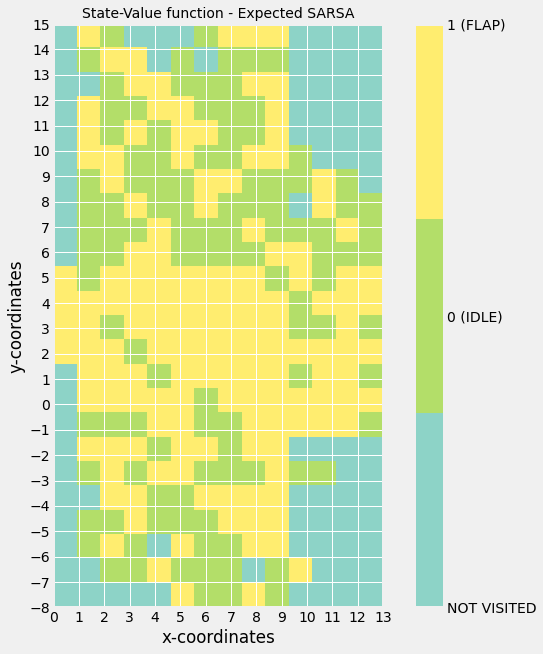

In [151]:
# Get the range of x/y-axis for the plot
x_values_ES = []
y_values_ES = []
q_table_exp_sarsa.keys()

for key in q_table_exp_sarsa.keys():
    
    x = key[0][0]
    y = key[0][1]
    
    if x not in x_values_ES:
        x_values_ES.append(x)
        
    
    if y not in y_values_ES:
        y_values_ES.append(y)
        
# Prepare the plot
x_range = sorted(x_values_ES)
y_range = sorted(y_values_ES)

X, Y = np.meshgrid(x_range, y_range)

Z = np.array([[get_qvalue(x, y, q_table_exp_sarsa) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('Set3', 3), vmin=-1, vmax=1 , extent=[0, 13, -8, 15])
plt.title('State-Value function - Expected SARSA', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['NOT VISITED', '0 (IDLE)','1 (FLAP)'])